This notebook is for building Adversarial Autoencoder network

Modifying https://github.com/natalya-patrikeeva/Keras-GAN/blob/master/aae/aae.py notebook 

In [1]:
import plaidml.keras
plaidml.keras.install_backend()

import keras
from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU

from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import petname

from keras.datasets import mnist

In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 10

### Discriminator model


In [3]:
# Build and compile the discriminator

def build_discriminator():

        model = Sequential()
        model.add(Dense(512, input_dim = latent_dim ))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation="sigmoid"))
        model.summary()

        encoded_repr = Input(shape=(latent_dim, ))
        validity = model(encoded_repr)
        
        print(validity)
        return Model(inputs = encoded_repr, outputs = validity)
    

- the number of parameters (weights and biases for the first dense layer) are $512 \times 10 + 512 = 5632$

- the number of parameters (weights and biases for the second dense layer) are $ 256 \times 512+256 = 131328$

- last dense layer: $ 1 \times 256 + 1 = 257$

In [4]:
discriminator = build_discriminator()

INFO:plaidml:Opening device "metal_intel(r)_iris(tm)_graphics_6100.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
Sigmoid FLOAT32(<tile.Value SymbolicDim UINT64()>, 1)


In [5]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 137217    
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________


In [6]:
optimizer = Adam(0.0002, 0.5)

In [7]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

In [8]:
# Build the encoder / decoder

def build_encoder():
    
        # Encoder
        img = Input(shape = img_shape)

        h = Flatten()(img)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        mu = Dense( latent_dim )(h)
        log_var = Dense( latent_dim )(h)
        
        # had to rewrite as a Lambda layer instead of merge layer                                          
        latent_repr = Lambda(lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2),
                             output_shape=lambda p: p[0])([mu, log_var])   
    
        return Model(img, latent_repr)

In [9]:
encoder = build_encoder()

In [10]:
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      flatten_1[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 512)          0           dense_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (D

In [11]:
def build_decoder():
    
        # Decoder
        model = Sequential()

        model.add(Dense(512, input_dim = latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.prod(img_shape), activation='tanh'))
        model.add(Reshape(img_shape))

        model.summary()

        z = Input(shape=(latent_dim,))
        img = model(z)

        return Model(z, img)

In [12]:
decoder = build_decoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 784)               402192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 670,480
Trainable params: 670,480
Non-trainable params: 0
_________________________________________________________________


In [13]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         670480    
Total params: 670,480
Trainable params: 670,480
Non-trainable params: 0
_________________________________________________________________


### Input the images:


In [14]:
img = Input(shape = img_shape)
print(img)

input_4 Placeholder FLOAT32(<tile.Value SymbolicDim UINT64()>, 28, 28, 1)


### Generator = Autoencoder (encoder + decoder) model

In [15]:
# The generator takes the image, encodes it and reconstructs it
# from the encoding

encoded_repr = encoder(img)
reconstructed_img = decoder(encoded_repr)

In [16]:
# generator is an autoencoder
generator = Model(inputs = img, outputs = reconstructed_img)

In [17]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_2 (Model)              (None, 10)                674836    
_________________________________________________________________
model_3 (Model)              (None, 28, 28, 1)         670480    
Total params: 1,345,316
Trainable params: 1,345,316
Non-trainable params: 0
_________________________________________________________________


To "freeze" a layer (or a whole discriminator model with multiple layers) means to exclude it from training, i.e. its weights will never be updated. This is useful in the context of fine-tuning a model, or using fixed embeddings for a text input.

Additionally, you can set the trainable property of a layer to `True` or `False` after instantiation. For this to take effect, you will need to call `compile()` on your model after modifying the `trainable` property. 

In [18]:
# For the adversarial_autoencoder model we will only train the generator
discriminator.trainable = False

Maybe need to rerun this cell after setting `trainable` to `False`:

```Python
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
```

In [19]:
# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

### Adversarial Autoencoder model  

In [20]:
# The adversarial_autoencoder model  
# stacked generator and discriminator
adversarial_autoencoder = Model(inputs = img, outputs = [reconstructed_img, validity])

In [21]:
adversarial_autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 10)           674836      input_4[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 (None, 28, 28, 1)    670480      model_2[1][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            137217      model_2[1][0]                    
Total params: 1,482,533
Trainable params: 1,345,316
Non-trainable params: 137,217
___________________________

In [22]:
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
                                loss_weights=[0.999, 0.001],
                                optimizer=optimizer)

### Train AAE

In [23]:
def sample_images(epoch):
        r, c = 5, 5

        z = np.random.normal(size=(r*c, latent_dim))
        gen_imgs = decoder.predict(z)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        for i in range(r):
            for j in range(c):
                
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d_mnist.png" % epoch)
        plt.close()

In [24]:
def train(epochs, batch_size = 128, sample_interval = 50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis = 3)
        # X_train shape: (60000, 28, 28, 1)
        
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # save results
        d_loss_list = []
        d_acc_list = []
        g_loss_list = []
        g_mse_list = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            latent_fake = encoder.predict(imgs)
            
            # size is a tuple of ints which specifies the output shape
            # where batch_size * latent_dim samples are drawn from the normal distribution
            latent_real = np.random.normal(size = (batch_size, latent_dim))

            # Train the discriminator
            # train_on_batch runs a single gradient update on a single batch of data.
            d_loss_real = discriminator.train_on_batch(x = latent_real, y = valid)
            
            d_loss_fake = discriminator.train_on_batch(x = latent_fake, y = fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = adversarial_autoencoder.train_on_batch(x = imgs, y = [imgs, valid])

            # Plot the progress
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
            
            # save results into lists for plotting later
            d_loss_list.append(d_loss[0])
            d_acc_list.append(d_loss[1])
            g_loss_list.append(g_loss[0])
            g_mse_list.append(g_loss[1])
            
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                sample_images(epoch)
            
        return(d_loss_list, d_acc_list, g_loss_list, g_mse_list)

In [25]:
%%time

epochs = 20000
batch_size = 32
sample_interval = 200

d_loss_list, d_acc_list, g_loss_list, g_mse_list = train(epochs = epochs, batch_size = batch_size, sample_interval = sample_interval)

/Users/nrapstine/anaconda/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.752068, acc: 43.75%] [G loss: 0.947976, mse: 0.948329]
1 [D loss: 0.775633, acc: 48.44%] [G loss: 0.918361, mse: 0.918709]
2 [D loss: 0.806077, acc: 46.88%] [G loss: 0.896564, mse: 0.896860]
3 [D loss: 0.709802, acc: 46.88%] [G loss: 0.857789, mse: 0.857828]
4 [D loss: 0.599038, acc: 92.19%] [G loss: 0.813586, mse: 0.813335]
5 [D loss: 0.624723, acc: 71.88%] [G loss: 0.786344, mse: 0.786034]
6 [D loss: 0.749376, acc: 43.75%] [G loss: 0.821239, mse: 0.821379]
7 [D loss: 1.062313, acc: 29.69%] [G loss: 0.782039, mse: 0.782148]
8 [D loss: 1.133841, acc: 32.81%] [G loss: 0.769904, mse: 0.770105]
9 [D loss: 1.048000, acc: 28.12%] [G loss: 0.686858, mse: 0.686832]
10 [D loss: 0.821689, acc: 32.81%] [G loss: 0.592873, mse: 0.592356]
11 [D loss: 0.701892, acc: 50.00%] [G loss: 0.526805, mse: 0.525871]
12 [D loss: 0.628757, acc: 54.69%] [G loss: 0.490048, mse: 0.488795]
13 [D loss: 0.570009, acc: 67.19%] [G loss: 0.487809, mse: 0.486506]
14 [D loss: 0.643281, acc: 54.69%] [G loss: 

122 [D loss: 0.703558, acc: 53.12%] [G loss: 0.284148, mse: 0.283701]
123 [D loss: 0.704484, acc: 42.19%] [G loss: 0.277768, mse: 0.277335]
124 [D loss: 0.709980, acc: 32.81%] [G loss: 0.271155, mse: 0.270753]
125 [D loss: 0.715426, acc: 26.56%] [G loss: 0.275600, mse: 0.275213]
126 [D loss: 0.728524, acc: 29.69%] [G loss: 0.277230, mse: 0.276834]
127 [D loss: 0.719115, acc: 32.81%] [G loss: 0.274322, mse: 0.273915]
128 [D loss: 0.706316, acc: 37.50%] [G loss: 0.274979, mse: 0.274560]
129 [D loss: 0.688353, acc: 54.69%] [G loss: 0.259573, mse: 0.259106]
130 [D loss: 0.688390, acc: 56.25%] [G loss: 0.254507, mse: 0.254030]
131 [D loss: 0.693051, acc: 54.69%] [G loss: 0.273506, mse: 0.273038]
132 [D loss: 0.688465, acc: 50.00%] [G loss: 0.283641, mse: 0.283212]
133 [D loss: 0.689631, acc: 51.56%] [G loss: 0.277506, mse: 0.277062]
134 [D loss: 0.693884, acc: 50.00%] [G loss: 0.278491, mse: 0.278085]
135 [D loss: 0.732309, acc: 34.38%] [G loss: 0.284288, mse: 0.283911]
136 [D loss: 0.75967

241 [D loss: 0.740610, acc: 29.69%] [G loss: 0.286594, mse: 0.286174]
242 [D loss: 0.722433, acc: 32.81%] [G loss: 0.267797, mse: 0.267337]
243 [D loss: 0.707595, acc: 39.06%] [G loss: 0.235904, mse: 0.235390]
244 [D loss: 0.693389, acc: 56.25%] [G loss: 0.268314, mse: 0.267820]
245 [D loss: 0.698913, acc: 54.69%] [G loss: 0.275502, mse: 0.275032]
246 [D loss: 0.704310, acc: 45.31%] [G loss: 0.266215, mse: 0.265783]
247 [D loss: 0.719596, acc: 35.94%] [G loss: 0.273166, mse: 0.272759]
248 [D loss: 0.749917, acc: 15.62%] [G loss: 0.266292, mse: 0.265874]
249 [D loss: 0.739031, acc: 23.44%] [G loss: 0.257418, mse: 0.257000]
250 [D loss: 0.726288, acc: 23.44%] [G loss: 0.256021, mse: 0.255554]
251 [D loss: 0.698804, acc: 48.44%] [G loss: 0.247413, mse: 0.246906]
252 [D loss: 0.714928, acc: 39.06%] [G loss: 0.271652, mse: 0.271194]
253 [D loss: 0.708483, acc: 42.19%] [G loss: 0.246452, mse: 0.245955]
254 [D loss: 0.697270, acc: 60.94%] [G loss: 0.262561, mse: 0.262081]
255 [D loss: 0.69295

362 [D loss: 0.733684, acc: 23.44%] [G loss: 0.221354, mse: 0.220909]
363 [D loss: 0.734621, acc: 20.31%] [G loss: 0.238438, mse: 0.237987]
364 [D loss: 0.711407, acc: 35.94%] [G loss: 0.220663, mse: 0.220155]
365 [D loss: 0.720324, acc: 32.81%] [G loss: 0.232427, mse: 0.231935]
366 [D loss: 0.713723, acc: 35.94%] [G loss: 0.215886, mse: 0.215383]
367 [D loss: 0.730949, acc: 23.44%] [G loss: 0.242707, mse: 0.242255]
368 [D loss: 0.743274, acc: 15.62%] [G loss: 0.221518, mse: 0.221053]
369 [D loss: 0.715675, acc: 29.69%] [G loss: 0.238317, mse: 0.237853]
370 [D loss: 0.733644, acc: 15.62%] [G loss: 0.233688, mse: 0.233202]
371 [D loss: 0.720359, acc: 35.94%] [G loss: 0.251117, mse: 0.250631]
372 [D loss: 0.718547, acc: 37.50%] [G loss: 0.245452, mse: 0.244972]
373 [D loss: 0.705470, acc: 45.31%] [G loss: 0.243684, mse: 0.243190]
374 [D loss: 0.710353, acc: 35.94%] [G loss: 0.246129, mse: 0.245630]
375 [D loss: 0.708498, acc: 48.44%] [G loss: 0.237117, mse: 0.236602]
376 [D loss: 0.70454

481 [D loss: 0.683371, acc: 48.44%] [G loss: 0.237165, mse: 0.236650]
482 [D loss: 0.692235, acc: 40.62%] [G loss: 0.243838, mse: 0.243333]
483 [D loss: 0.701654, acc: 43.75%] [G loss: 0.211453, mse: 0.210944]
484 [D loss: 0.717520, acc: 35.94%] [G loss: 0.217845, mse: 0.217363]
485 [D loss: 0.707762, acc: 39.06%] [G loss: 0.240690, mse: 0.240204]
486 [D loss: 0.741893, acc: 21.88%] [G loss: 0.243665, mse: 0.243171]
487 [D loss: 0.725819, acc: 26.56%] [G loss: 0.234341, mse: 0.233847]
488 [D loss: 0.737978, acc: 28.12%] [G loss: 0.247136, mse: 0.246632]
489 [D loss: 0.748876, acc: 25.00%] [G loss: 0.223378, mse: 0.222892]
490 [D loss: 0.777661, acc: 23.44%] [G loss: 0.227060, mse: 0.226615]
491 [D loss: 0.797899, acc: 12.50%] [G loss: 0.214303, mse: 0.213856]
492 [D loss: 0.761707, acc: 21.88%] [G loss: 0.237568, mse: 0.237066]
493 [D loss: 0.725366, acc: 34.38%] [G loss: 0.239689, mse: 0.239069]
494 [D loss: 0.692215, acc: 57.81%] [G loss: 0.234640, mse: 0.233988]
495 [D loss: 0.69277

600 [D loss: 0.726234, acc: 28.12%] [G loss: 0.251383, mse: 0.250888]
601 [D loss: 0.707737, acc: 62.50%] [G loss: 0.244164, mse: 0.243611]
602 [D loss: 0.688809, acc: 62.50%] [G loss: 0.224752, mse: 0.224152]
603 [D loss: 0.676195, acc: 71.88%] [G loss: 0.221132, mse: 0.220573]
604 [D loss: 0.696344, acc: 57.81%] [G loss: 0.223069, mse: 0.222555]
605 [D loss: 0.720225, acc: 42.19%] [G loss: 0.242417, mse: 0.241968]
606 [D loss: 0.739845, acc: 15.62%] [G loss: 0.208620, mse: 0.208158]
607 [D loss: 0.742922, acc: 17.19%] [G loss: 0.227572, mse: 0.227128]
608 [D loss: 0.731006, acc: 14.06%] [G loss: 0.225954, mse: 0.225494]
609 [D loss: 0.725555, acc: 17.19%] [G loss: 0.194421, mse: 0.193909]
610 [D loss: 0.720934, acc: 29.69%] [G loss: 0.236439, mse: 0.235958]
611 [D loss: 0.703338, acc: 56.25%] [G loss: 0.224610, mse: 0.224116]
612 [D loss: 0.704089, acc: 54.69%] [G loss: 0.221562, mse: 0.221057]
613 [D loss: 0.708241, acc: 50.00%] [G loss: 0.214371, mse: 0.213863]
614 [D loss: 0.70462

722 [D loss: 0.730700, acc: 26.56%] [G loss: 0.205261, mse: 0.204699]
723 [D loss: 0.745452, acc: 29.69%] [G loss: 0.198194, mse: 0.197643]
724 [D loss: 0.752109, acc: 14.06%] [G loss: 0.230683, mse: 0.230162]
725 [D loss: 0.766194, acc: 21.88%] [G loss: 0.198960, mse: 0.198427]
726 [D loss: 0.758581, acc: 14.06%] [G loss: 0.216753, mse: 0.216225]
727 [D loss: 0.740464, acc: 17.19%] [G loss: 0.214723, mse: 0.214115]
728 [D loss: 0.680068, acc: 54.69%] [G loss: 0.217033, mse: 0.216309]
729 [D loss: 0.686518, acc: 53.12%] [G loss: 0.217165, mse: 0.216484]
730 [D loss: 0.721126, acc: 46.88%] [G loss: 0.218835, mse: 0.218272]
731 [D loss: 0.735267, acc: 26.56%] [G loss: 0.245595, mse: 0.245133]
732 [D loss: 0.745848, acc: 12.50%] [G loss: 0.215886, mse: 0.215405]
733 [D loss: 0.751331, acc: 15.62%] [G loss: 0.203306, mse: 0.202810]
734 [D loss: 0.731419, acc: 9.38%] [G loss: 0.204260, mse: 0.203770]
735 [D loss: 0.744341, acc: 26.56%] [G loss: 0.190860, mse: 0.190335]
736 [D loss: 0.732495

840 [D loss: 0.709867, acc: 40.62%] [G loss: 0.207762, mse: 0.207277]
841 [D loss: 0.706400, acc: 34.38%] [G loss: 0.219682, mse: 0.219228]
842 [D loss: 0.709232, acc: 34.38%] [G loss: 0.194188, mse: 0.193717]
843 [D loss: 0.720222, acc: 26.56%] [G loss: 0.186888, mse: 0.186421]
844 [D loss: 0.730584, acc: 28.12%] [G loss: 0.195123, mse: 0.194670]
845 [D loss: 0.750887, acc: 23.44%] [G loss: 0.188260, mse: 0.187803]
846 [D loss: 0.736495, acc: 34.38%] [G loss: 0.211114, mse: 0.210643]
847 [D loss: 0.716007, acc: 25.00%] [G loss: 0.198494, mse: 0.197928]
848 [D loss: 0.695482, acc: 56.25%] [G loss: 0.199884, mse: 0.199279]
849 [D loss: 0.682540, acc: 67.19%] [G loss: 0.195248, mse: 0.194642]
850 [D loss: 0.684899, acc: 64.06%] [G loss: 0.215464, mse: 0.214921]
851 [D loss: 0.710276, acc: 37.50%] [G loss: 0.200530, mse: 0.200018]
852 [D loss: 0.714536, acc: 35.94%] [G loss: 0.183900, mse: 0.183377]
853 [D loss: 0.719820, acc: 25.00%] [G loss: 0.199840, mse: 0.199362]
854 [D loss: 0.70890

962 [D loss: 0.714223, acc: 29.69%] [G loss: 0.190321, mse: 0.189749]
963 [D loss: 0.717905, acc: 34.38%] [G loss: 0.198513, mse: 0.197952]
964 [D loss: 0.715903, acc: 40.62%] [G loss: 0.195432, mse: 0.194878]
965 [D loss: 0.725300, acc: 28.12%] [G loss: 0.178238, mse: 0.177659]
966 [D loss: 0.709432, acc: 43.75%] [G loss: 0.190892, mse: 0.190329]
967 [D loss: 0.702968, acc: 54.69%] [G loss: 0.197836, mse: 0.197271]
968 [D loss: 0.714275, acc: 56.25%] [G loss: 0.186430, mse: 0.185863]
969 [D loss: 0.703004, acc: 57.81%] [G loss: 0.175263, mse: 0.174695]
970 [D loss: 0.707633, acc: 54.69%] [G loss: 0.194405, mse: 0.193858]
971 [D loss: 0.716119, acc: 53.12%] [G loss: 0.199171, mse: 0.198638]
972 [D loss: 0.710475, acc: 60.94%] [G loss: 0.169676, mse: 0.169115]
973 [D loss: 0.703181, acc: 59.38%] [G loss: 0.191253, mse: 0.190729]
974 [D loss: 0.707697, acc: 43.75%] [G loss: 0.183844, mse: 0.183324]
975 [D loss: 0.715363, acc: 40.62%] [G loss: 0.190319, mse: 0.189810]
976 [D loss: 0.71555

1080 [D loss: 0.701829, acc: 45.31%] [G loss: 0.183847, mse: 0.183326]
1081 [D loss: 0.699615, acc: 51.56%] [G loss: 0.167247, mse: 0.166711]
1082 [D loss: 0.696629, acc: 53.12%] [G loss: 0.172455, mse: 0.171923]
1083 [D loss: 0.702105, acc: 40.62%] [G loss: 0.176816, mse: 0.176295]
1084 [D loss: 0.696410, acc: 42.19%] [G loss: 0.189309, mse: 0.188802]
1085 [D loss: 0.703189, acc: 34.38%] [G loss: 0.178082, mse: 0.177570]
1086 [D loss: 0.703020, acc: 28.12%] [G loss: 0.169324, mse: 0.168807]
1087 [D loss: 0.708126, acc: 23.44%] [G loss: 0.191612, mse: 0.191124]
1088 [D loss: 0.705961, acc: 29.69%] [G loss: 0.179096, mse: 0.178604]
1089 [D loss: 0.716212, acc: 25.00%] [G loss: 0.184618, mse: 0.184140]
1090 [D loss: 0.718472, acc: 28.12%] [G loss: 0.179559, mse: 0.179078]
1091 [D loss: 0.702965, acc: 35.94%] [G loss: 0.186540, mse: 0.186064]
1092 [D loss: 0.712148, acc: 29.69%] [G loss: 0.173641, mse: 0.173153]
1093 [D loss: 0.697081, acc: 43.75%] [G loss: 0.184849, mse: 0.184368]
1094 [

1200 [D loss: 0.721587, acc: 25.00%] [G loss: 0.163755, mse: 0.163224]
1201 [D loss: 0.737791, acc: 20.31%] [G loss: 0.201192, mse: 0.200714]
1202 [D loss: 0.724407, acc: 17.19%] [G loss: 0.167117, mse: 0.166615]
1203 [D loss: 0.727042, acc: 17.19%] [G loss: 0.169718, mse: 0.169216]
1204 [D loss: 0.724408, acc: 15.62%] [G loss: 0.162802, mse: 0.162277]
1205 [D loss: 0.720312, acc: 32.81%] [G loss: 0.155099, mse: 0.154540]
1206 [D loss: 0.710306, acc: 39.06%] [G loss: 0.159530, mse: 0.158962]
1207 [D loss: 0.699925, acc: 57.81%] [G loss: 0.163151, mse: 0.162559]
1208 [D loss: 0.687408, acc: 56.25%] [G loss: 0.160040, mse: 0.159438]
1209 [D loss: 0.690356, acc: 56.25%] [G loss: 0.181244, mse: 0.180688]
1210 [D loss: 0.713810, acc: 34.38%] [G loss: 0.165412, mse: 0.164869]
1211 [D loss: 0.716680, acc: 40.62%] [G loss: 0.171648, mse: 0.171117]
1212 [D loss: 0.720516, acc: 29.69%] [G loss: 0.164360, mse: 0.163848]
1213 [D loss: 0.733751, acc: 14.06%] [G loss: 0.172117, mse: 0.171629]
1214 [

1317 [D loss: 0.678868, acc: 73.44%] [G loss: 0.172446, mse: 0.171890]
1318 [D loss: 0.687500, acc: 56.25%] [G loss: 0.152192, mse: 0.151628]
1319 [D loss: 0.685508, acc: 46.88%] [G loss: 0.151872, mse: 0.151318]
1320 [D loss: 0.698640, acc: 37.50%] [G loss: 0.174430, mse: 0.173919]
1321 [D loss: 0.700101, acc: 39.06%] [G loss: 0.177257, mse: 0.176752]
1322 [D loss: 0.708449, acc: 26.56%] [G loss: 0.171546, mse: 0.171043]
1323 [D loss: 0.712716, acc: 25.00%] [G loss: 0.148132, mse: 0.147607]
1324 [D loss: 0.706996, acc: 28.12%] [G loss: 0.160600, mse: 0.160081]
1325 [D loss: 0.699862, acc: 32.81%] [G loss: 0.147610, mse: 0.147069]
1326 [D loss: 0.692379, acc: 46.88%] [G loss: 0.149884, mse: 0.149327]
1327 [D loss: 0.690675, acc: 51.56%] [G loss: 0.174272, mse: 0.173740]
1328 [D loss: 0.681460, acc: 70.31%] [G loss: 0.162345, mse: 0.161790]
1329 [D loss: 0.686571, acc: 54.69%] [G loss: 0.163464, mse: 0.162907]
1330 [D loss: 0.689339, acc: 68.75%] [G loss: 0.160033, mse: 0.159465]
1331 [

1436 [D loss: 0.692898, acc: 45.31%] [G loss: 0.152580, mse: 0.152051]
1437 [D loss: 0.698852, acc: 35.94%] [G loss: 0.158516, mse: 0.157990]
1438 [D loss: 0.697367, acc: 40.62%] [G loss: 0.160503, mse: 0.159980]
1439 [D loss: 0.701592, acc: 31.25%] [G loss: 0.163281, mse: 0.162768]
1440 [D loss: 0.698414, acc: 43.75%] [G loss: 0.146903, mse: 0.146376]
1441 [D loss: 0.700505, acc: 42.19%] [G loss: 0.168077, mse: 0.167571]
1442 [D loss: 0.702907, acc: 39.06%] [G loss: 0.158716, mse: 0.158206]
1443 [D loss: 0.693191, acc: 42.19%] [G loss: 0.147209, mse: 0.146682]
1444 [D loss: 0.695984, acc: 39.06%] [G loss: 0.153853, mse: 0.153331]
1445 [D loss: 0.701730, acc: 31.25%] [G loss: 0.163716, mse: 0.163199]
1446 [D loss: 0.691983, acc: 39.06%] [G loss: 0.151278, mse: 0.150748]
1447 [D loss: 0.697715, acc: 39.06%] [G loss: 0.157313, mse: 0.156785]
1448 [D loss: 0.684983, acc: 56.25%] [G loss: 0.140114, mse: 0.139569]
1449 [D loss: 0.693298, acc: 50.00%] [G loss: 0.166255, mse: 0.165739]
1450 [

1553 [D loss: 0.697872, acc: 34.38%] [G loss: 0.151578, mse: 0.151059]
1554 [D loss: 0.707284, acc: 31.25%] [G loss: 0.144662, mse: 0.144135]
1555 [D loss: 0.707744, acc: 37.50%] [G loss: 0.152050, mse: 0.151538]
1556 [D loss: 0.719043, acc: 26.56%] [G loss: 0.139538, mse: 0.139012]
1557 [D loss: 0.712969, acc: 32.81%] [G loss: 0.153822, mse: 0.153307]
1558 [D loss: 0.725642, acc: 28.12%] [G loss: 0.147660, mse: 0.147128]
1559 [D loss: 0.719767, acc: 21.88%] [G loss: 0.149494, mse: 0.148916]
1560 [D loss: 0.697762, acc: 45.31%] [G loss: 0.170922, mse: 0.170332]
1561 [D loss: 0.686333, acc: 60.94%] [G loss: 0.164417, mse: 0.163788]
1562 [D loss: 0.679193, acc: 68.75%] [G loss: 0.149075, mse: 0.148426]
1563 [D loss: 0.686698, acc: 60.94%] [G loss: 0.151353, mse: 0.150726]
1564 [D loss: 0.691633, acc: 57.81%] [G loss: 0.139629, mse: 0.139033]
1565 [D loss: 0.717494, acc: 31.25%] [G loss: 0.139118, mse: 0.138549]
1566 [D loss: 0.704202, acc: 37.50%] [G loss: 0.143635, mse: 0.143075]
1567 [

1670 [D loss: 0.696282, acc: 40.62%] [G loss: 0.150583, mse: 0.150043]
1671 [D loss: 0.701754, acc: 34.38%] [G loss: 0.140211, mse: 0.139657]
1672 [D loss: 0.702403, acc: 39.06%] [G loss: 0.162584, mse: 0.162057]
1673 [D loss: 0.704964, acc: 28.12%] [G loss: 0.147038, mse: 0.146493]
1674 [D loss: 0.702577, acc: 35.94%] [G loss: 0.143376, mse: 0.142820]
1675 [D loss: 0.701087, acc: 37.50%] [G loss: 0.145095, mse: 0.144538]
1676 [D loss: 0.697837, acc: 37.50%] [G loss: 0.137350, mse: 0.136780]
1677 [D loss: 0.694128, acc: 53.12%] [G loss: 0.147250, mse: 0.146684]
1678 [D loss: 0.691348, acc: 57.81%] [G loss: 0.167961, mse: 0.167413]
1679 [D loss: 0.698110, acc: 45.31%] [G loss: 0.150439, mse: 0.149887]
1680 [D loss: 0.698611, acc: 42.19%] [G loss: 0.159671, mse: 0.159124]
1681 [D loss: 0.694457, acc: 59.38%] [G loss: 0.136524, mse: 0.135958]
1682 [D loss: 0.696860, acc: 45.31%] [G loss: 0.155488, mse: 0.154947]
1683 [D loss: 0.703610, acc: 37.50%] [G loss: 0.137443, mse: 0.136891]
1684 [

1788 [D loss: 0.715151, acc: 25.00%] [G loss: 0.134461, mse: 0.133906]
1789 [D loss: 0.711238, acc: 29.69%] [G loss: 0.147040, mse: 0.146496]
1790 [D loss: 0.706004, acc: 39.06%] [G loss: 0.162609, mse: 0.162062]
1791 [D loss: 0.696869, acc: 51.56%] [G loss: 0.140978, mse: 0.140390]
1792 [D loss: 0.699488, acc: 53.12%] [G loss: 0.157645, mse: 0.157074]
1793 [D loss: 0.693996, acc: 59.38%] [G loss: 0.136543, mse: 0.135949]
1794 [D loss: 0.690751, acc: 59.38%] [G loss: 0.162522, mse: 0.161960]
1795 [D loss: 0.694087, acc: 59.38%] [G loss: 0.135258, mse: 0.134674]
1796 [D loss: 0.695042, acc: 53.12%] [G loss: 0.154176, mse: 0.153609]
1797 [D loss: 0.697386, acc: 56.25%] [G loss: 0.143575, mse: 0.143005]
1798 [D loss: 0.699930, acc: 39.06%] [G loss: 0.136873, mse: 0.136299]
1799 [D loss: 0.700747, acc: 37.50%] [G loss: 0.148600, mse: 0.148039]
1800 [D loss: 0.706196, acc: 29.69%] [G loss: 0.145683, mse: 0.145126]
1801 [D loss: 0.700869, acc: 45.31%] [G loss: 0.146461, mse: 0.145896]
1802 [

1905 [D loss: 0.706743, acc: 28.12%] [G loss: 0.154000, mse: 0.153456]
1906 [D loss: 0.681784, acc: 67.19%] [G loss: 0.127980, mse: 0.127376]
1907 [D loss: 0.685775, acc: 60.94%] [G loss: 0.130846, mse: 0.130237]
1908 [D loss: 0.674052, acc: 76.56%] [G loss: 0.140231, mse: 0.139626]
1909 [D loss: 0.678055, acc: 60.94%] [G loss: 0.147504, mse: 0.146920]
1910 [D loss: 0.679469, acc: 67.19%] [G loss: 0.151384, mse: 0.150805]
1911 [D loss: 0.685737, acc: 60.94%] [G loss: 0.135284, mse: 0.134701]
1912 [D loss: 0.680644, acc: 70.31%] [G loss: 0.137872, mse: 0.137296]
1913 [D loss: 0.687587, acc: 56.25%] [G loss: 0.138038, mse: 0.137466]
1914 [D loss: 0.691512, acc: 50.00%] [G loss: 0.149665, mse: 0.149114]
1915 [D loss: 0.696296, acc: 54.69%] [G loss: 0.163581, mse: 0.163047]
1916 [D loss: 0.701623, acc: 32.81%] [G loss: 0.146381, mse: 0.145840]
1917 [D loss: 0.705607, acc: 29.69%] [G loss: 0.127959, mse: 0.127405]
1918 [D loss: 0.699178, acc: 34.38%] [G loss: 0.136598, mse: 0.136055]
1919 [

2021 [D loss: 0.714919, acc: 25.00%] [G loss: 0.133246, mse: 0.132716]
2022 [D loss: 0.736314, acc: 28.12%] [G loss: 0.151737, mse: 0.151237]
2023 [D loss: 0.757279, acc: 15.62%] [G loss: 0.130529, mse: 0.130017]
2024 [D loss: 0.735034, acc: 17.19%] [G loss: 0.153337, mse: 0.152806]
2025 [D loss: 0.704265, acc: 35.94%] [G loss: 0.159913, mse: 0.159338]
2026 [D loss: 0.690175, acc: 53.12%] [G loss: 0.154285, mse: 0.153674]
2027 [D loss: 0.685829, acc: 56.25%] [G loss: 0.149179, mse: 0.148562]
2028 [D loss: 0.684412, acc: 57.81%] [G loss: 0.138199, mse: 0.137587]
2029 [D loss: 0.695458, acc: 57.81%] [G loss: 0.143641, mse: 0.143052]
2030 [D loss: 0.695356, acc: 50.00%] [G loss: 0.137148, mse: 0.136560]
2031 [D loss: 0.694775, acc: 59.38%] [G loss: 0.143840, mse: 0.143266]
2032 [D loss: 0.701493, acc: 51.56%] [G loss: 0.141096, mse: 0.140520]
2033 [D loss: 0.694188, acc: 64.06%] [G loss: 0.159417, mse: 0.158861]
2034 [D loss: 0.704414, acc: 45.31%] [G loss: 0.157885, mse: 0.157339]
2035 [

2140 [D loss: 0.701171, acc: 39.06%] [G loss: 0.141069, mse: 0.140520]
2141 [D loss: 0.695003, acc: 53.12%] [G loss: 0.126521, mse: 0.125949]
2142 [D loss: 0.687504, acc: 56.25%] [G loss: 0.157173, mse: 0.156624]
2143 [D loss: 0.688170, acc: 62.50%] [G loss: 0.130869, mse: 0.130289]
2144 [D loss: 0.685620, acc: 68.75%] [G loss: 0.117764, mse: 0.117170]
2145 [D loss: 0.684208, acc: 70.31%] [G loss: 0.139926, mse: 0.139351]
2146 [D loss: 0.685881, acc: 62.50%] [G loss: 0.138257, mse: 0.137679]
2147 [D loss: 0.685242, acc: 62.50%] [G loss: 0.131704, mse: 0.131123]
2148 [D loss: 0.682119, acc: 70.31%] [G loss: 0.127124, mse: 0.126535]
2149 [D loss: 0.689445, acc: 57.81%] [G loss: 0.133771, mse: 0.133205]
2150 [D loss: 0.687551, acc: 51.56%] [G loss: 0.129220, mse: 0.128646]
2151 [D loss: 0.688126, acc: 65.62%] [G loss: 0.149485, mse: 0.148932]
2152 [D loss: 0.688884, acc: 56.25%] [G loss: 0.140975, mse: 0.140421]
2153 [D loss: 0.696038, acc: 45.31%] [G loss: 0.131276, mse: 0.130721]
2154 [

2256 [D loss: 0.691782, acc: 53.12%] [G loss: 0.142955, mse: 0.142401]
2257 [D loss: 0.694983, acc: 46.88%] [G loss: 0.126243, mse: 0.125670]
2258 [D loss: 0.691996, acc: 54.69%] [G loss: 0.130836, mse: 0.130266]
2259 [D loss: 0.694000, acc: 50.00%] [G loss: 0.121463, mse: 0.120886]
2260 [D loss: 0.698256, acc: 43.75%] [G loss: 0.135247, mse: 0.134694]
2261 [D loss: 0.697022, acc: 51.56%] [G loss: 0.114592, mse: 0.114006]
2262 [D loss: 0.691091, acc: 50.00%] [G loss: 0.120193, mse: 0.119620]
2263 [D loss: 0.699083, acc: 32.81%] [G loss: 0.141700, mse: 0.141160]
2264 [D loss: 0.697338, acc: 45.31%] [G loss: 0.123826, mse: 0.123271]
2265 [D loss: 0.698241, acc: 40.62%] [G loss: 0.107191, mse: 0.106616]
2266 [D loss: 0.696645, acc: 40.62%] [G loss: 0.122379, mse: 0.121819]
2267 [D loss: 0.692910, acc: 45.31%] [G loss: 0.130030, mse: 0.129478]
2268 [D loss: 0.697574, acc: 40.62%] [G loss: 0.139741, mse: 0.139200]
2269 [D loss: 0.698545, acc: 39.06%] [G loss: 0.128717, mse: 0.128164]
2270 [

2376 [D loss: 0.692733, acc: 43.75%] [G loss: 0.120650, mse: 0.120085]
2377 [D loss: 0.694620, acc: 42.19%] [G loss: 0.140464, mse: 0.139914]
2378 [D loss: 0.697013, acc: 35.94%] [G loss: 0.119615, mse: 0.119043]
2379 [D loss: 0.691523, acc: 51.56%] [G loss: 0.124604, mse: 0.124034]
2380 [D loss: 0.689198, acc: 56.25%] [G loss: 0.115760, mse: 0.115177]
2381 [D loss: 0.695504, acc: 45.31%] [G loss: 0.108018, mse: 0.107431]
2382 [D loss: 0.692788, acc: 50.00%] [G loss: 0.129306, mse: 0.128732]
2383 [D loss: 0.685985, acc: 62.50%] [G loss: 0.127458, mse: 0.126877]
2384 [D loss: 0.686353, acc: 65.62%] [G loss: 0.130430, mse: 0.129849]
2385 [D loss: 0.687718, acc: 64.06%] [G loss: 0.119982, mse: 0.119392]
2386 [D loss: 0.682022, acc: 62.50%] [G loss: 0.133161, mse: 0.132582]
2387 [D loss: 0.683980, acc: 53.12%] [G loss: 0.125614, mse: 0.125032]
2388 [D loss: 0.689570, acc: 51.56%] [G loss: 0.122599, mse: 0.122023]
2389 [D loss: 0.686822, acc: 67.19%] [G loss: 0.130251, mse: 0.129675]
2390 [

2495 [D loss: 0.704740, acc: 35.94%] [G loss: 0.114936, mse: 0.114364]
2496 [D loss: 0.703694, acc: 29.69%] [G loss: 0.124043, mse: 0.123472]
2497 [D loss: 0.697934, acc: 40.62%] [G loss: 0.133519, mse: 0.132951]
2498 [D loss: 0.691781, acc: 51.56%] [G loss: 0.130444, mse: 0.129861]
2499 [D loss: 0.697298, acc: 43.75%] [G loss: 0.139499, mse: 0.138927]
2500 [D loss: 0.698554, acc: 40.62%] [G loss: 0.126009, mse: 0.125429]
2501 [D loss: 0.685177, acc: 62.50%] [G loss: 0.137007, mse: 0.136427]
2502 [D loss: 0.688196, acc: 57.81%] [G loss: 0.126394, mse: 0.125805]
2503 [D loss: 0.694105, acc: 45.31%] [G loss: 0.133148, mse: 0.132571]
2504 [D loss: 0.694737, acc: 45.31%] [G loss: 0.111718, mse: 0.111127]
2505 [D loss: 0.696867, acc: 43.75%] [G loss: 0.125530, mse: 0.124954]
2506 [D loss: 0.702202, acc: 37.50%] [G loss: 0.137606, mse: 0.137047]
2507 [D loss: 0.689249, acc: 56.25%] [G loss: 0.133918, mse: 0.133349]
2508 [D loss: 0.695669, acc: 46.88%] [G loss: 0.130176, mse: 0.129607]
2509 [

2611 [D loss: 0.685887, acc: 65.62%] [G loss: 0.124122, mse: 0.123532]
2612 [D loss: 0.684656, acc: 71.88%] [G loss: 0.125043, mse: 0.124451]
2613 [D loss: 0.683290, acc: 73.44%] [G loss: 0.120603, mse: 0.120014]
2614 [D loss: 0.685151, acc: 60.94%] [G loss: 0.115906, mse: 0.115311]
2615 [D loss: 0.689529, acc: 60.94%] [G loss: 0.111594, mse: 0.111000]
2616 [D loss: 0.683171, acc: 64.06%] [G loss: 0.121779, mse: 0.121199]
2617 [D loss: 0.698992, acc: 46.88%] [G loss: 0.120656, mse: 0.120086]
2618 [D loss: 0.692408, acc: 43.75%] [G loss: 0.123563, mse: 0.123004]
2619 [D loss: 0.696267, acc: 39.06%] [G loss: 0.139380, mse: 0.138838]
2620 [D loss: 0.699662, acc: 40.62%] [G loss: 0.124243, mse: 0.123689]
2621 [D loss: 0.701864, acc: 31.25%] [G loss: 0.129374, mse: 0.128833]
2622 [D loss: 0.704081, acc: 37.50%] [G loss: 0.132039, mse: 0.131499]
2623 [D loss: 0.709014, acc: 34.38%] [G loss: 0.124674, mse: 0.124132]
2624 [D loss: 0.698111, acc: 32.81%] [G loss: 0.127113, mse: 0.126561]
2625 [

2730 [D loss: 0.695191, acc: 48.44%] [G loss: 0.115235, mse: 0.114656]
2731 [D loss: 0.699723, acc: 34.38%] [G loss: 0.136248, mse: 0.135691]
2732 [D loss: 0.697901, acc: 42.19%] [G loss: 0.133489, mse: 0.132925]
2733 [D loss: 0.695980, acc: 50.00%] [G loss: 0.116253, mse: 0.115667]
2734 [D loss: 0.695983, acc: 46.88%] [G loss: 0.114806, mse: 0.114218]
2735 [D loss: 0.690314, acc: 54.69%] [G loss: 0.108853, mse: 0.108253]
2736 [D loss: 0.691194, acc: 56.25%] [G loss: 0.110905, mse: 0.110303]
2737 [D loss: 0.685895, acc: 65.62%] [G loss: 0.100378, mse: 0.099762]
2738 [D loss: 0.691339, acc: 56.25%] [G loss: 0.116941, mse: 0.116344]
2739 [D loss: 0.690488, acc: 51.56%] [G loss: 0.140389, mse: 0.139826]
2740 [D loss: 0.691654, acc: 64.06%] [G loss: 0.119523, mse: 0.118942]
2741 [D loss: 0.691642, acc: 57.81%] [G loss: 0.115461, mse: 0.114877]
2742 [D loss: 0.694100, acc: 53.12%] [G loss: 0.115973, mse: 0.115387]
2743 [D loss: 0.691816, acc: 56.25%] [G loss: 0.123328, mse: 0.122751]
2744 [

2846 [D loss: 0.693966, acc: 42.19%] [G loss: 0.113245, mse: 0.112672]
2847 [D loss: 0.692387, acc: 60.94%] [G loss: 0.124932, mse: 0.124362]
2848 [D loss: 0.697778, acc: 50.00%] [G loss: 0.117169, mse: 0.116596]
2849 [D loss: 0.692501, acc: 45.31%] [G loss: 0.131211, mse: 0.130650]
2850 [D loss: 0.693813, acc: 45.31%] [G loss: 0.112434, mse: 0.111850]
2851 [D loss: 0.693834, acc: 51.56%] [G loss: 0.130806, mse: 0.130244]
2852 [D loss: 0.693088, acc: 50.00%] [G loss: 0.112490, mse: 0.111905]
2853 [D loss: 0.690910, acc: 53.12%] [G loss: 0.121900, mse: 0.121318]
2854 [D loss: 0.689457, acc: 62.50%] [G loss: 0.127215, mse: 0.126637]
2855 [D loss: 0.690703, acc: 62.50%] [G loss: 0.110384, mse: 0.109794]
2856 [D loss: 0.686727, acc: 65.62%] [G loss: 0.129247, mse: 0.128671]
2857 [D loss: 0.688575, acc: 65.62%] [G loss: 0.116503, mse: 0.115917]
2858 [D loss: 0.691744, acc: 62.50%] [G loss: 0.125412, mse: 0.124838]
2859 [D loss: 0.693347, acc: 51.56%] [G loss: 0.117815, mse: 0.117232]
2860 [

2966 [D loss: 0.705038, acc: 31.25%] [G loss: 0.127411, mse: 0.126850]
2967 [D loss: 0.700364, acc: 37.50%] [G loss: 0.143384, mse: 0.142841]
2968 [D loss: 0.705062, acc: 29.69%] [G loss: 0.116170, mse: 0.115608]
2969 [D loss: 0.709246, acc: 17.19%] [G loss: 0.123865, mse: 0.123310]
2970 [D loss: 0.698231, acc: 35.94%] [G loss: 0.124492, mse: 0.123935]
2971 [D loss: 0.704470, acc: 35.94%] [G loss: 0.133129, mse: 0.132582]
2972 [D loss: 0.706556, acc: 29.69%] [G loss: 0.122684, mse: 0.122119]
2973 [D loss: 0.699896, acc: 34.38%] [G loss: 0.124592, mse: 0.124023]
2974 [D loss: 0.703796, acc: 32.81%] [G loss: 0.121414, mse: 0.120844]
2975 [D loss: 0.704151, acc: 35.94%] [G loss: 0.122323, mse: 0.121755]
2976 [D loss: 0.694278, acc: 42.19%] [G loss: 0.119017, mse: 0.118430]
2977 [D loss: 0.700683, acc: 39.06%] [G loss: 0.134734, mse: 0.134172]
2978 [D loss: 0.702034, acc: 54.69%] [G loss: 0.125649, mse: 0.125080]
2979 [D loss: 0.706439, acc: 32.81%] [G loss: 0.122467, mse: 0.121897]
2980 [

3085 [D loss: 0.695564, acc: 43.75%] [G loss: 0.114252, mse: 0.113679]
3086 [D loss: 0.698523, acc: 39.06%] [G loss: 0.116644, mse: 0.116080]
3087 [D loss: 0.710938, acc: 29.69%] [G loss: 0.110844, mse: 0.110286]
3088 [D loss: 0.710196, acc: 25.00%] [G loss: 0.121912, mse: 0.121359]
3089 [D loss: 0.708164, acc: 34.38%] [G loss: 0.109037, mse: 0.108464]
3090 [D loss: 0.694272, acc: 54.69%] [G loss: 0.123772, mse: 0.123192]
3091 [D loss: 0.689008, acc: 59.38%] [G loss: 0.131776, mse: 0.131184]
3092 [D loss: 0.684050, acc: 60.94%] [G loss: 0.130743, mse: 0.130139]
3093 [D loss: 0.685252, acc: 60.94%] [G loss: 0.126575, mse: 0.125974]
3094 [D loss: 0.685620, acc: 73.44%] [G loss: 0.132620, mse: 0.132034]
3095 [D loss: 0.686548, acc: 60.94%] [G loss: 0.113994, mse: 0.113391]
3096 [D loss: 0.691927, acc: 59.38%] [G loss: 0.134318, mse: 0.133744]
3097 [D loss: 0.688819, acc: 60.94%] [G loss: 0.113580, mse: 0.112985]
3098 [D loss: 0.689599, acc: 59.38%] [G loss: 0.110952, mse: 0.110361]
3099 [

3201 [D loss: 0.689233, acc: 65.62%] [G loss: 0.109381, mse: 0.108775]
3202 [D loss: 0.692137, acc: 60.94%] [G loss: 0.112524, mse: 0.111923]
3203 [D loss: 0.690334, acc: 57.81%] [G loss: 0.129265, mse: 0.128684]
3204 [D loss: 0.689788, acc: 59.38%] [G loss: 0.115604, mse: 0.115016]
3205 [D loss: 0.692058, acc: 62.50%] [G loss: 0.132114, mse: 0.131543]
3206 [D loss: 0.688923, acc: 53.12%] [G loss: 0.105175, mse: 0.104580]
3207 [D loss: 0.689193, acc: 54.69%] [G loss: 0.111510, mse: 0.110927]
3208 [D loss: 0.694167, acc: 40.62%] [G loss: 0.119795, mse: 0.119223]
3209 [D loss: 0.694484, acc: 39.06%] [G loss: 0.110391, mse: 0.109815]
3210 [D loss: 0.695675, acc: 42.19%] [G loss: 0.113743, mse: 0.113176]
3211 [D loss: 0.699865, acc: 31.25%] [G loss: 0.117754, mse: 0.117196]
3212 [D loss: 0.694278, acc: 34.38%] [G loss: 0.126607, mse: 0.126054]
3213 [D loss: 0.695793, acc: 42.19%] [G loss: 0.119630, mse: 0.119073]
3214 [D loss: 0.698248, acc: 35.94%] [G loss: 0.108918, mse: 0.108349]
3215 [

3317 [D loss: 0.700073, acc: 32.81%] [G loss: 0.119718, mse: 0.119145]
3318 [D loss: 0.704181, acc: 26.56%] [G loss: 0.117850, mse: 0.117288]
3319 [D loss: 0.697054, acc: 34.38%] [G loss: 0.109966, mse: 0.109390]
3320 [D loss: 0.700940, acc: 31.25%] [G loss: 0.099924, mse: 0.099332]
3321 [D loss: 0.698365, acc: 29.69%] [G loss: 0.109952, mse: 0.109361]
3322 [D loss: 0.695271, acc: 54.69%] [G loss: 0.122152, mse: 0.121573]
3323 [D loss: 0.693473, acc: 54.69%] [G loss: 0.127694, mse: 0.127108]
3324 [D loss: 0.688315, acc: 64.06%] [G loss: 0.115398, mse: 0.114799]
3325 [D loss: 0.690215, acc: 59.38%] [G loss: 0.117698, mse: 0.117107]
3326 [D loss: 0.690454, acc: 56.25%] [G loss: 0.122868, mse: 0.122278]
3327 [D loss: 0.682718, acc: 67.19%] [G loss: 0.093254, mse: 0.092629]
3328 [D loss: 0.685600, acc: 70.31%] [G loss: 0.102613, mse: 0.102005]
3329 [D loss: 0.683617, acc: 65.62%] [G loss: 0.099727, mse: 0.099121]
3330 [D loss: 0.687033, acc: 59.38%] [G loss: 0.128142, mse: 0.127565]
3331 [

3436 [D loss: 0.697507, acc: 39.06%] [G loss: 0.116449, mse: 0.115871]
3437 [D loss: 0.695370, acc: 45.31%] [G loss: 0.113256, mse: 0.112673]
3438 [D loss: 0.691149, acc: 53.12%] [G loss: 0.107354, mse: 0.106759]
3439 [D loss: 0.697086, acc: 46.88%] [G loss: 0.127780, mse: 0.127206]
3440 [D loss: 0.688243, acc: 54.69%] [G loss: 0.109167, mse: 0.108572]
3441 [D loss: 0.692195, acc: 57.81%] [G loss: 0.125534, mse: 0.124950]
3442 [D loss: 0.689243, acc: 65.62%] [G loss: 0.104980, mse: 0.104376]
3443 [D loss: 0.684188, acc: 65.62%] [G loss: 0.109683, mse: 0.109083]
3444 [D loss: 0.687107, acc: 59.38%] [G loss: 0.125554, mse: 0.124970]
3445 [D loss: 0.689183, acc: 50.00%] [G loss: 0.116356, mse: 0.115758]
3446 [D loss: 0.693983, acc: 50.00%] [G loss: 0.090211, mse: 0.089602]
3447 [D loss: 0.694860, acc: 46.88%] [G loss: 0.110167, mse: 0.109587]
3448 [D loss: 0.702708, acc: 43.75%] [G loss: 0.119634, mse: 0.119071]
3449 [D loss: 0.703922, acc: 31.25%] [G loss: 0.118711, mse: 0.118143]
3450 [

3555 [D loss: 0.683098, acc: 62.50%] [G loss: 0.113880, mse: 0.113261]
3556 [D loss: 0.692106, acc: 53.12%] [G loss: 0.118926, mse: 0.118330]
3557 [D loss: 0.695143, acc: 53.12%] [G loss: 0.109325, mse: 0.108719]
3558 [D loss: 0.702946, acc: 45.31%] [G loss: 0.106427, mse: 0.105818]
3559 [D loss: 0.701300, acc: 42.19%] [G loss: 0.101585, mse: 0.100986]
3560 [D loss: 0.704338, acc: 29.69%] [G loss: 0.130351, mse: 0.129779]
3561 [D loss: 0.704864, acc: 37.50%] [G loss: 0.119457, mse: 0.118878]
3562 [D loss: 0.702325, acc: 37.50%] [G loss: 0.117571, mse: 0.116988]
3563 [D loss: 0.715207, acc: 18.75%] [G loss: 0.133465, mse: 0.132913]
3564 [D loss: 0.710188, acc: 25.00%] [G loss: 0.126630, mse: 0.126064]
3565 [D loss: 0.714065, acc: 20.31%] [G loss: 0.132887, mse: 0.132317]
3566 [D loss: 0.701005, acc: 34.38%] [G loss: 0.127333, mse: 0.126738]
3567 [D loss: 0.694727, acc: 60.94%] [G loss: 0.126105, mse: 0.125499]
3568 [D loss: 0.689041, acc: 59.38%] [G loss: 0.111179, mse: 0.110553]
3569 [

3674 [D loss: 0.702306, acc: 32.81%] [G loss: 0.121709, mse: 0.121145]
3675 [D loss: 0.695495, acc: 53.12%] [G loss: 0.129876, mse: 0.129316]
3676 [D loss: 0.700942, acc: 37.50%] [G loss: 0.115419, mse: 0.114852]
3677 [D loss: 0.700950, acc: 32.81%] [G loss: 0.117798, mse: 0.117222]
3678 [D loss: 0.697991, acc: 39.06%] [G loss: 0.115049, mse: 0.114468]
3679 [D loss: 0.694070, acc: 45.31%] [G loss: 0.100418, mse: 0.099816]
3680 [D loss: 0.689761, acc: 54.69%] [G loss: 0.111670, mse: 0.111068]
3681 [D loss: 0.698041, acc: 35.94%] [G loss: 0.106963, mse: 0.106367]
3682 [D loss: 0.691027, acc: 54.69%] [G loss: 0.118838, mse: 0.118253]
3683 [D loss: 0.682877, acc: 73.44%] [G loss: 0.121163, mse: 0.120570]
3684 [D loss: 0.695424, acc: 53.12%] [G loss: 0.123555, mse: 0.122980]
3685 [D loss: 0.694002, acc: 57.81%] [G loss: 0.118170, mse: 0.117589]
3686 [D loss: 0.687764, acc: 64.06%] [G loss: 0.115376, mse: 0.114790]
3687 [D loss: 0.695061, acc: 48.44%] [G loss: 0.115423, mse: 0.114846]
3688 [

3793 [D loss: 0.693664, acc: 45.31%] [G loss: 0.102264, mse: 0.101668]
3794 [D loss: 0.692626, acc: 56.25%] [G loss: 0.117229, mse: 0.116655]
3795 [D loss: 0.692427, acc: 59.38%] [G loss: 0.093502, mse: 0.092895]
3796 [D loss: 0.691156, acc: 59.38%] [G loss: 0.107609, mse: 0.107016]
3797 [D loss: 0.691680, acc: 59.38%] [G loss: 0.112912, mse: 0.112328]
3798 [D loss: 0.689227, acc: 57.81%] [G loss: 0.111366, mse: 0.110780]
3799 [D loss: 0.692753, acc: 54.69%] [G loss: 0.089811, mse: 0.089205]
3800 [D loss: 0.695775, acc: 50.00%] [G loss: 0.127688, mse: 0.127131]
3801 [D loss: 0.691804, acc: 46.88%] [G loss: 0.108631, mse: 0.108047]
3802 [D loss: 0.694308, acc: 51.56%] [G loss: 0.095402, mse: 0.094805]
3803 [D loss: 0.696862, acc: 43.75%] [G loss: 0.108468, mse: 0.107888]
3804 [D loss: 0.693268, acc: 53.12%] [G loss: 0.118398, mse: 0.117826]
3805 [D loss: 0.694056, acc: 50.00%] [G loss: 0.102845, mse: 0.102259]
3806 [D loss: 0.694899, acc: 42.19%] [G loss: 0.117387, mse: 0.116816]
3807 [

3910 [D loss: 0.696191, acc: 42.19%] [G loss: 0.135577, mse: 0.135005]
3911 [D loss: 0.700546, acc: 39.06%] [G loss: 0.111623, mse: 0.111033]
3912 [D loss: 0.697036, acc: 46.88%] [G loss: 0.112908, mse: 0.112315]
3913 [D loss: 0.697034, acc: 43.75%] [G loss: 0.115179, mse: 0.114593]
3914 [D loss: 0.700068, acc: 34.38%] [G loss: 0.114454, mse: 0.113867]
3915 [D loss: 0.698592, acc: 37.50%] [G loss: 0.113131, mse: 0.112540]
3916 [D loss: 0.697218, acc: 45.31%] [G loss: 0.119611, mse: 0.119023]
3917 [D loss: 0.696517, acc: 50.00%] [G loss: 0.106031, mse: 0.105423]
3918 [D loss: 0.694180, acc: 46.88%] [G loss: 0.116583, mse: 0.115985]
3919 [D loss: 0.688731, acc: 56.25%] [G loss: 0.127027, mse: 0.126430]
3920 [D loss: 0.687432, acc: 53.12%] [G loss: 0.107965, mse: 0.107348]
3921 [D loss: 0.685410, acc: 60.94%] [G loss: 0.111275, mse: 0.110657]
3922 [D loss: 0.688893, acc: 67.19%] [G loss: 0.118706, mse: 0.118104]
3923 [D loss: 0.683479, acc: 71.88%] [G loss: 0.107625, mse: 0.107013]
3924 [

4028 [D loss: 0.693001, acc: 50.00%] [G loss: 0.116228, mse: 0.115651]
4029 [D loss: 0.695272, acc: 31.25%] [G loss: 0.118661, mse: 0.118087]
4030 [D loss: 0.690910, acc: 60.94%] [G loss: 0.100193, mse: 0.099597]
4031 [D loss: 0.689386, acc: 62.50%] [G loss: 0.113287, mse: 0.112701]
4032 [D loss: 0.690462, acc: 56.25%] [G loss: 0.097471, mse: 0.096870]
4033 [D loss: 0.690606, acc: 51.56%] [G loss: 0.098672, mse: 0.098069]
4034 [D loss: 0.688697, acc: 62.50%] [G loss: 0.100948, mse: 0.100348]
4035 [D loss: 0.688630, acc: 60.94%] [G loss: 0.106007, mse: 0.105411]
4036 [D loss: 0.694462, acc: 45.31%] [G loss: 0.105385, mse: 0.104797]
4037 [D loss: 0.691183, acc: 59.38%] [G loss: 0.110199, mse: 0.109615]
4038 [D loss: 0.693426, acc: 48.44%] [G loss: 0.108357, mse: 0.107772]
4039 [D loss: 0.697190, acc: 43.75%] [G loss: 0.092266, mse: 0.091671]
4040 [D loss: 0.696960, acc: 45.31%] [G loss: 0.105433, mse: 0.104852]
4041 [D loss: 0.701588, acc: 32.81%] [G loss: 0.110040, mse: 0.109467]
4042 [

4148 [D loss: 0.704036, acc: 29.69%] [G loss: 0.106373, mse: 0.105788]
4149 [D loss: 0.701505, acc: 35.94%] [G loss: 0.100975, mse: 0.100385]
4150 [D loss: 0.698044, acc: 37.50%] [G loss: 0.108240, mse: 0.107657]
4151 [D loss: 0.698942, acc: 29.69%] [G loss: 0.100018, mse: 0.099426]
4152 [D loss: 0.697687, acc: 35.94%] [G loss: 0.101342, mse: 0.100751]
4153 [D loss: 0.693735, acc: 43.75%] [G loss: 0.107408, mse: 0.106825]
4154 [D loss: 0.691873, acc: 53.12%] [G loss: 0.132526, mse: 0.131961]
4155 [D loss: 0.696786, acc: 50.00%] [G loss: 0.109185, mse: 0.108604]
4156 [D loss: 0.695357, acc: 42.19%] [G loss: 0.103063, mse: 0.102476]
4157 [D loss: 0.695253, acc: 43.75%] [G loss: 0.110647, mse: 0.110062]
4158 [D loss: 0.687925, acc: 64.06%] [G loss: 0.104086, mse: 0.103490]
4159 [D loss: 0.693477, acc: 48.44%] [G loss: 0.110140, mse: 0.109552]
4160 [D loss: 0.691378, acc: 59.38%] [G loss: 0.112823, mse: 0.112238]
4161 [D loss: 0.689390, acc: 64.06%] [G loss: 0.098107, mse: 0.097502]
4162 [

4268 [D loss: 0.693291, acc: 46.88%] [G loss: 0.128447, mse: 0.127858]
4269 [D loss: 0.691096, acc: 40.62%] [G loss: 0.106571, mse: 0.105950]
4270 [D loss: 0.688403, acc: 54.69%] [G loss: 0.106410, mse: 0.105783]
4271 [D loss: 0.681176, acc: 70.31%] [G loss: 0.102771, mse: 0.102137]
4272 [D loss: 0.687383, acc: 57.81%] [G loss: 0.104621, mse: 0.103988]
4273 [D loss: 0.688204, acc: 62.50%] [G loss: 0.117929, mse: 0.117318]
4274 [D loss: 0.683694, acc: 75.00%] [G loss: 0.107610, mse: 0.106991]
4275 [D loss: 0.681987, acc: 70.31%] [G loss: 0.119739, mse: 0.119126]
4276 [D loss: 0.692095, acc: 57.81%] [G loss: 0.104010, mse: 0.103399]
4277 [D loss: 0.694715, acc: 50.00%] [G loss: 0.112212, mse: 0.111622]
4278 [D loss: 0.698065, acc: 45.31%] [G loss: 0.113555, mse: 0.112969]
4279 [D loss: 0.700770, acc: 31.25%] [G loss: 0.110662, mse: 0.110086]
4280 [D loss: 0.701997, acc: 29.69%] [G loss: 0.110344, mse: 0.109771]
4281 [D loss: 0.707560, acc: 21.88%] [G loss: 0.112520, mse: 0.111954]
4282 [

4384 [D loss: 0.694206, acc: 45.31%] [G loss: 0.099341, mse: 0.098745]
4385 [D loss: 0.694163, acc: 50.00%] [G loss: 0.099812, mse: 0.099216]
4386 [D loss: 0.692151, acc: 59.38%] [G loss: 0.109878, mse: 0.109291]
4387 [D loss: 0.695085, acc: 46.88%] [G loss: 0.110104, mse: 0.109515]
4388 [D loss: 0.691298, acc: 54.69%] [G loss: 0.109291, mse: 0.108696]
4389 [D loss: 0.691921, acc: 46.88%] [G loss: 0.097640, mse: 0.097037]
4390 [D loss: 0.692329, acc: 50.00%] [G loss: 0.105863, mse: 0.105269]
4391 [D loss: 0.698872, acc: 42.19%] [G loss: 0.095385, mse: 0.094787]
4392 [D loss: 0.694087, acc: 46.88%] [G loss: 0.115630, mse: 0.115049]
4393 [D loss: 0.692057, acc: 56.25%] [G loss: 0.093474, mse: 0.092866]
4394 [D loss: 0.690655, acc: 56.25%] [G loss: 0.104410, mse: 0.103812]
4395 [D loss: 0.690187, acc: 51.56%] [G loss: 0.126599, mse: 0.126023]
4396 [D loss: 0.692448, acc: 54.69%] [G loss: 0.102996, mse: 0.102401]
4397 [D loss: 0.691394, acc: 51.56%] [G loss: 0.105332, mse: 0.104736]
4398 [

4502 [D loss: 0.695181, acc: 42.19%] [G loss: 0.092114, mse: 0.091507]
4503 [D loss: 0.694405, acc: 43.75%] [G loss: 0.106667, mse: 0.106074]
4504 [D loss: 0.692702, acc: 57.81%] [G loss: 0.113334, mse: 0.112741]
4505 [D loss: 0.697077, acc: 50.00%] [G loss: 0.092089, mse: 0.091490]
4506 [D loss: 0.691660, acc: 56.25%] [G loss: 0.094694, mse: 0.094081]
4507 [D loss: 0.694170, acc: 45.31%] [G loss: 0.112847, mse: 0.112259]
4508 [D loss: 0.692673, acc: 48.44%] [G loss: 0.095289, mse: 0.094682]
4509 [D loss: 0.691024, acc: 53.12%] [G loss: 0.113760, mse: 0.113172]
4510 [D loss: 0.693556, acc: 45.31%] [G loss: 0.097603, mse: 0.096999]
4511 [D loss: 0.690761, acc: 59.38%] [G loss: 0.108261, mse: 0.107668]
4512 [D loss: 0.692421, acc: 48.44%] [G loss: 0.100546, mse: 0.099949]
4513 [D loss: 0.696179, acc: 39.06%] [G loss: 0.097277, mse: 0.096682]
4514 [D loss: 0.692010, acc: 56.25%] [G loss: 0.111150, mse: 0.110567]
4515 [D loss: 0.694324, acc: 43.75%] [G loss: 0.097482, mse: 0.096885]
4516 [

4620 [D loss: 0.692246, acc: 53.12%] [G loss: 0.102296, mse: 0.101690]
4621 [D loss: 0.695943, acc: 42.19%] [G loss: 0.101715, mse: 0.101112]
4622 [D loss: 0.693907, acc: 50.00%] [G loss: 0.091648, mse: 0.091039]
4623 [D loss: 0.694342, acc: 46.88%] [G loss: 0.105514, mse: 0.104921]
4624 [D loss: 0.694865, acc: 45.31%] [G loss: 0.097222, mse: 0.096623]
4625 [D loss: 0.698071, acc: 40.62%] [G loss: 0.107606, mse: 0.107020]
4626 [D loss: 0.694962, acc: 45.31%] [G loss: 0.089594, mse: 0.088984]
4627 [D loss: 0.696755, acc: 37.50%] [G loss: 0.113172, mse: 0.112591]
4628 [D loss: 0.699536, acc: 35.94%] [G loss: 0.099207, mse: 0.098610]
4629 [D loss: 0.695927, acc: 46.88%] [G loss: 0.100942, mse: 0.100348]
4630 [D loss: 0.695177, acc: 46.88%] [G loss: 0.109457, mse: 0.108872]
4631 [D loss: 0.693202, acc: 51.56%] [G loss: 0.115767, mse: 0.115186]
4632 [D loss: 0.691710, acc: 50.00%] [G loss: 0.098897, mse: 0.098297]
4633 [D loss: 0.691812, acc: 54.69%] [G loss: 0.094564, mse: 0.093960]
4634 [

4739 [D loss: 0.690717, acc: 62.50%] [G loss: 0.109304, mse: 0.108718]
4740 [D loss: 0.696460, acc: 50.00%] [G loss: 0.102580, mse: 0.101989]
4741 [D loss: 0.695420, acc: 39.06%] [G loss: 0.101858, mse: 0.101266]
4742 [D loss: 0.693245, acc: 53.12%] [G loss: 0.102011, mse: 0.101421]
4743 [D loss: 0.696971, acc: 45.31%] [G loss: 0.100100, mse: 0.099514]
4744 [D loss: 0.692154, acc: 48.44%] [G loss: 0.096680, mse: 0.096081]
4745 [D loss: 0.691223, acc: 53.12%] [G loss: 0.090488, mse: 0.089882]
4746 [D loss: 0.692415, acc: 51.56%] [G loss: 0.108848, mse: 0.108260]
4747 [D loss: 0.688622, acc: 56.25%] [G loss: 0.099496, mse: 0.098894]
4748 [D loss: 0.687739, acc: 62.50%] [G loss: 0.101422, mse: 0.100821]
4749 [D loss: 0.695451, acc: 48.44%] [G loss: 0.100320, mse: 0.099725]
4750 [D loss: 0.693948, acc: 46.88%] [G loss: 0.098691, mse: 0.098093]
4751 [D loss: 0.695138, acc: 43.75%] [G loss: 0.093261, mse: 0.092661]
4752 [D loss: 0.696136, acc: 46.88%] [G loss: 0.105313, mse: 0.104726]
4753 [

4857 [D loss: 0.698891, acc: 32.81%] [G loss: 0.093289, mse: 0.092683]
4858 [D loss: 0.693322, acc: 46.88%] [G loss: 0.105202, mse: 0.104606]
4859 [D loss: 0.696120, acc: 35.94%] [G loss: 0.108185, mse: 0.107587]
4860 [D loss: 0.694210, acc: 51.56%] [G loss: 0.120469, mse: 0.119884]
4861 [D loss: 0.696285, acc: 54.69%] [G loss: 0.115607, mse: 0.115023]
4862 [D loss: 0.697022, acc: 42.19%] [G loss: 0.098612, mse: 0.098004]
4863 [D loss: 0.694971, acc: 48.44%] [G loss: 0.100620, mse: 0.100007]
4864 [D loss: 0.692056, acc: 53.12%] [G loss: 0.098733, mse: 0.098118]
4865 [D loss: 0.689047, acc: 62.50%] [G loss: 0.095973, mse: 0.095353]
4866 [D loss: 0.692425, acc: 56.25%] [G loss: 0.105453, mse: 0.104847]
4867 [D loss: 0.697983, acc: 43.75%] [G loss: 0.088906, mse: 0.088288]
4868 [D loss: 0.697849, acc: 39.06%] [G loss: 0.108381, mse: 0.107789]
4869 [D loss: 0.696336, acc: 42.19%] [G loss: 0.101150, mse: 0.100548]
4870 [D loss: 0.691830, acc: 54.69%] [G loss: 0.086391, mse: 0.085772]
4871 [

4975 [D loss: 0.698633, acc: 26.56%] [G loss: 0.088030, mse: 0.087434]
4976 [D loss: 0.692814, acc: 51.56%] [G loss: 0.093217, mse: 0.092617]
4977 [D loss: 0.694315, acc: 46.88%] [G loss: 0.099971, mse: 0.099375]
4978 [D loss: 0.691712, acc: 56.25%] [G loss: 0.094824, mse: 0.094218]
4979 [D loss: 0.690277, acc: 54.69%] [G loss: 0.080631, mse: 0.080014]
4980 [D loss: 0.693473, acc: 51.56%] [G loss: 0.087486, mse: 0.086876]
4981 [D loss: 0.689733, acc: 57.81%] [G loss: 0.103878, mse: 0.103282]
4982 [D loss: 0.687841, acc: 62.50%] [G loss: 0.089410, mse: 0.088796]
4983 [D loss: 0.683479, acc: 70.31%] [G loss: 0.113540, mse: 0.112948]
4984 [D loss: 0.687451, acc: 59.38%] [G loss: 0.097705, mse: 0.097104]
4985 [D loss: 0.691158, acc: 50.00%] [G loss: 0.092313, mse: 0.091712]
4986 [D loss: 0.685649, acc: 62.50%] [G loss: 0.107494, mse: 0.106904]
4987 [D loss: 0.694610, acc: 39.06%] [G loss: 0.094939, mse: 0.094343]
4988 [D loss: 0.697787, acc: 40.62%] [G loss: 0.096020, mse: 0.095431]
4989 [

5094 [D loss: 0.692065, acc: 48.44%] [G loss: 0.092323, mse: 0.091715]
5095 [D loss: 0.698624, acc: 40.62%] [G loss: 0.098639, mse: 0.098045]
5096 [D loss: 0.694458, acc: 50.00%] [G loss: 0.098970, mse: 0.098370]
5097 [D loss: 0.692564, acc: 50.00%] [G loss: 0.090219, mse: 0.089605]
5098 [D loss: 0.693147, acc: 45.31%] [G loss: 0.099752, mse: 0.099149]
5099 [D loss: 0.692797, acc: 46.88%] [G loss: 0.093801, mse: 0.093193]
5100 [D loss: 0.691674, acc: 54.69%] [G loss: 0.083824, mse: 0.083206]
5101 [D loss: 0.692424, acc: 50.00%] [G loss: 0.095662, mse: 0.095057]
5102 [D loss: 0.689411, acc: 62.50%] [G loss: 0.094750, mse: 0.094140]
5103 [D loss: 0.691680, acc: 59.38%] [G loss: 0.097801, mse: 0.097198]
5104 [D loss: 0.692320, acc: 54.69%] [G loss: 0.098858, mse: 0.098259]
5105 [D loss: 0.692418, acc: 48.44%] [G loss: 0.094479, mse: 0.093873]
5106 [D loss: 0.692790, acc: 53.12%] [G loss: 0.088038, mse: 0.087424]
5107 [D loss: 0.689130, acc: 65.62%] [G loss: 0.107235, mse: 0.106638]
5108 [

5210 [D loss: 0.689638, acc: 57.81%] [G loss: 0.114918, mse: 0.114329]
5211 [D loss: 0.693479, acc: 51.56%] [G loss: 0.098381, mse: 0.097777]
5212 [D loss: 0.696836, acc: 43.75%] [G loss: 0.092131, mse: 0.091534]
5213 [D loss: 0.693647, acc: 50.00%] [G loss: 0.093174, mse: 0.092568]
5214 [D loss: 0.693862, acc: 48.44%] [G loss: 0.085923, mse: 0.085308]
5215 [D loss: 0.695864, acc: 42.19%] [G loss: 0.093661, mse: 0.093057]
5216 [D loss: 0.691129, acc: 60.94%] [G loss: 0.100596, mse: 0.099993]
5217 [D loss: 0.694206, acc: 51.56%] [G loss: 0.101840, mse: 0.101243]
5218 [D loss: 0.692791, acc: 53.12%] [G loss: 0.091021, mse: 0.090412]
5219 [D loss: 0.693529, acc: 53.12%] [G loss: 0.094603, mse: 0.093997]
5220 [D loss: 0.690657, acc: 48.44%] [G loss: 0.093695, mse: 0.093085]
5221 [D loss: 0.694198, acc: 43.75%] [G loss: 0.097258, mse: 0.096655]
5222 [D loss: 0.692243, acc: 50.00%] [G loss: 0.099812, mse: 0.099211]
5223 [D loss: 0.690872, acc: 56.25%] [G loss: 0.093771, mse: 0.093166]
5224 [

5329 [D loss: 0.693540, acc: 48.44%] [G loss: 0.093291, mse: 0.092688]
5330 [D loss: 0.696466, acc: 39.06%] [G loss: 0.085645, mse: 0.085034]
5331 [D loss: 0.692358, acc: 51.56%] [G loss: 0.087839, mse: 0.087226]
5332 [D loss: 0.692338, acc: 48.44%] [G loss: 0.096262, mse: 0.095658]
5333 [D loss: 0.697017, acc: 42.19%] [G loss: 0.091894, mse: 0.091289]
5334 [D loss: 0.695132, acc: 53.12%] [G loss: 0.092384, mse: 0.091779]
5335 [D loss: 0.695976, acc: 46.88%] [G loss: 0.111905, mse: 0.111320]
5336 [D loss: 0.691178, acc: 62.50%] [G loss: 0.090745, mse: 0.090134]
5337 [D loss: 0.691153, acc: 59.38%] [G loss: 0.102943, mse: 0.102341]
5338 [D loss: 0.687833, acc: 64.06%] [G loss: 0.099817, mse: 0.099211]
5339 [D loss: 0.690602, acc: 53.12%] [G loss: 0.091161, mse: 0.090547]
5340 [D loss: 0.690400, acc: 56.25%] [G loss: 0.099938, mse: 0.099336]
5341 [D loss: 0.690050, acc: 54.69%] [G loss: 0.073178, mse: 0.072542]
5342 [D loss: 0.693447, acc: 45.31%] [G loss: 0.099176, mse: 0.098578]
5343 [

5449 [D loss: 0.691245, acc: 54.69%] [G loss: 0.096271, mse: 0.095664]
5450 [D loss: 0.694774, acc: 46.88%] [G loss: 0.091320, mse: 0.090713]
5451 [D loss: 0.691313, acc: 53.12%] [G loss: 0.088437, mse: 0.087822]
5452 [D loss: 0.696105, acc: 46.88%] [G loss: 0.103869, mse: 0.103275]
5453 [D loss: 0.692802, acc: 46.88%] [G loss: 0.101033, mse: 0.100436]
5454 [D loss: 0.690996, acc: 48.44%] [G loss: 0.098184, mse: 0.097581]
5455 [D loss: 0.692549, acc: 50.00%] [G loss: 0.094284, mse: 0.093680]
5456 [D loss: 0.687909, acc: 70.31%] [G loss: 0.082052, mse: 0.081435]
5457 [D loss: 0.696230, acc: 39.06%] [G loss: 0.104160, mse: 0.103576]
5458 [D loss: 0.693539, acc: 50.00%] [G loss: 0.102567, mse: 0.101976]
5459 [D loss: 0.693103, acc: 43.75%] [G loss: 0.085615, mse: 0.085007]
5460 [D loss: 0.692504, acc: 53.12%] [G loss: 0.095025, mse: 0.094425]
5461 [D loss: 0.693302, acc: 51.56%] [G loss: 0.088099, mse: 0.087486]
5462 [D loss: 0.695419, acc: 42.19%] [G loss: 0.101062, mse: 0.100467]
5463 [

5565 [D loss: 0.693578, acc: 51.56%] [G loss: 0.089440, mse: 0.088827]
5566 [D loss: 0.695360, acc: 40.62%] [G loss: 0.097554, mse: 0.096953]
5567 [D loss: 0.695202, acc: 51.56%] [G loss: 0.105062, mse: 0.104469]
5568 [D loss: 0.692600, acc: 57.81%] [G loss: 0.086042, mse: 0.085428]
5569 [D loss: 0.692864, acc: 51.56%] [G loss: 0.083668, mse: 0.083053]
5570 [D loss: 0.690410, acc: 57.81%] [G loss: 0.092404, mse: 0.091796]
5571 [D loss: 0.693252, acc: 46.88%] [G loss: 0.107194, mse: 0.106605]
5572 [D loss: 0.689284, acc: 60.94%] [G loss: 0.085478, mse: 0.084866]
5573 [D loss: 0.692830, acc: 51.56%] [G loss: 0.086629, mse: 0.086020]
5574 [D loss: 0.691211, acc: 56.25%] [G loss: 0.094983, mse: 0.094379]
5575 [D loss: 0.694596, acc: 50.00%] [G loss: 0.084953, mse: 0.084345]
5576 [D loss: 0.692842, acc: 54.69%] [G loss: 0.089077, mse: 0.088470]
5577 [D loss: 0.693018, acc: 59.38%] [G loss: 0.090916, mse: 0.090309]
5578 [D loss: 0.693700, acc: 50.00%] [G loss: 0.109155, mse: 0.108575]
5579 [

5683 [D loss: 0.695443, acc: 43.75%] [G loss: 0.092798, mse: 0.092193]
5684 [D loss: 0.692473, acc: 50.00%] [G loss: 0.095343, mse: 0.094740]
5685 [D loss: 0.693350, acc: 54.69%] [G loss: 0.098602, mse: 0.098003]
5686 [D loss: 0.693113, acc: 51.56%] [G loss: 0.090449, mse: 0.089843]
5687 [D loss: 0.689864, acc: 53.12%] [G loss: 0.088578, mse: 0.087968]
5688 [D loss: 0.694623, acc: 42.19%] [G loss: 0.090881, mse: 0.090273]
5689 [D loss: 0.693315, acc: 48.44%] [G loss: 0.090070, mse: 0.089461]
5690 [D loss: 0.694479, acc: 45.31%] [G loss: 0.110221, mse: 0.109632]
5691 [D loss: 0.691157, acc: 53.12%] [G loss: 0.099808, mse: 0.099206]
5692 [D loss: 0.694982, acc: 51.56%] [G loss: 0.097379, mse: 0.096778]
5693 [D loss: 0.694450, acc: 50.00%] [G loss: 0.081965, mse: 0.081346]
5694 [D loss: 0.697210, acc: 46.88%] [G loss: 0.088909, mse: 0.088302]
5695 [D loss: 0.694943, acc: 39.06%] [G loss: 0.090737, mse: 0.090132]
5696 [D loss: 0.694451, acc: 48.44%] [G loss: 0.091696, mse: 0.091094]
5697 [

5799 [D loss: 0.693934, acc: 46.88%] [G loss: 0.088050, mse: 0.087446]
5800 [D loss: 0.692923, acc: 48.44%] [G loss: 0.095244, mse: 0.094643]
5801 [D loss: 0.692041, acc: 48.44%] [G loss: 0.078091, mse: 0.077470]
5802 [D loss: 0.687017, acc: 68.75%] [G loss: 0.079530, mse: 0.078909]
5803 [D loss: 0.693788, acc: 50.00%] [G loss: 0.092169, mse: 0.091570]
5804 [D loss: 0.693348, acc: 54.69%] [G loss: 0.097752, mse: 0.097159]
5805 [D loss: 0.695231, acc: 45.31%] [G loss: 0.099063, mse: 0.098472]
5806 [D loss: 0.693773, acc: 45.31%] [G loss: 0.112883, mse: 0.112307]
5807 [D loss: 0.695400, acc: 45.31%] [G loss: 0.086700, mse: 0.086097]
5808 [D loss: 0.694327, acc: 43.75%] [G loss: 0.091073, mse: 0.090472]
5809 [D loss: 0.694788, acc: 45.31%] [G loss: 0.086173, mse: 0.085566]
5810 [D loss: 0.694973, acc: 50.00%] [G loss: 0.084284, mse: 0.083673]
5811 [D loss: 0.690847, acc: 57.81%] [G loss: 0.088392, mse: 0.087781]
5812 [D loss: 0.692387, acc: 56.25%] [G loss: 0.089975, mse: 0.089367]
5813 [

5917 [D loss: 0.687552, acc: 67.19%] [G loss: 0.095377, mse: 0.094761]
5918 [D loss: 0.689441, acc: 59.38%] [G loss: 0.092247, mse: 0.091635]
5919 [D loss: 0.691804, acc: 57.81%] [G loss: 0.107289, mse: 0.106698]
5920 [D loss: 0.694967, acc: 45.31%] [G loss: 0.086199, mse: 0.085586]
5921 [D loss: 0.696136, acc: 42.19%] [G loss: 0.100654, mse: 0.100062]
5922 [D loss: 0.690925, acc: 54.69%] [G loss: 0.086437, mse: 0.085822]
5923 [D loss: 0.688918, acc: 62.50%] [G loss: 0.086405, mse: 0.085788]
5924 [D loss: 0.698639, acc: 45.31%] [G loss: 0.081317, mse: 0.080704]
5925 [D loss: 0.695429, acc: 46.88%] [G loss: 0.104217, mse: 0.103629]
5926 [D loss: 0.696905, acc: 40.62%] [G loss: 0.105305, mse: 0.104721]
5927 [D loss: 0.697108, acc: 39.06%] [G loss: 0.099962, mse: 0.099372]
5928 [D loss: 0.694262, acc: 43.75%] [G loss: 0.086097, mse: 0.085487]
5929 [D loss: 0.693078, acc: 50.00%] [G loss: 0.094248, mse: 0.093648]
5930 [D loss: 0.693775, acc: 56.25%] [G loss: 0.090442, mse: 0.089835]
5931 [

6033 [D loss: 0.696938, acc: 32.81%] [G loss: 0.091943, mse: 0.091337]
6034 [D loss: 0.693715, acc: 54.69%] [G loss: 0.085009, mse: 0.084393]
6035 [D loss: 0.698329, acc: 35.94%] [G loss: 0.107725, mse: 0.107136]
6036 [D loss: 0.692028, acc: 60.94%] [G loss: 0.080320, mse: 0.079700]
6037 [D loss: 0.690853, acc: 57.81%] [G loss: 0.091409, mse: 0.090796]
6038 [D loss: 0.692355, acc: 53.12%] [G loss: 0.097555, mse: 0.096950]
6039 [D loss: 0.692815, acc: 53.12%] [G loss: 0.089009, mse: 0.088397]
6040 [D loss: 0.695748, acc: 51.56%] [G loss: 0.083762, mse: 0.083151]
6041 [D loss: 0.694650, acc: 54.69%] [G loss: 0.095252, mse: 0.094652]
6042 [D loss: 0.695202, acc: 48.44%] [G loss: 0.097526, mse: 0.096926]
6043 [D loss: 0.698460, acc: 40.62%] [G loss: 0.089659, mse: 0.089054]
6044 [D loss: 0.691439, acc: 56.25%] [G loss: 0.079550, mse: 0.078925]
6045 [D loss: 0.692522, acc: 46.88%] [G loss: 0.092069, mse: 0.091458]
6046 [D loss: 0.693232, acc: 54.69%] [G loss: 0.087314, mse: 0.086699]
6047 [

6152 [D loss: 0.690938, acc: 54.69%] [G loss: 0.091181, mse: 0.090573]
6153 [D loss: 0.691862, acc: 50.00%] [G loss: 0.079415, mse: 0.078793]
6154 [D loss: 0.691966, acc: 56.25%] [G loss: 0.088385, mse: 0.087775]
6155 [D loss: 0.693173, acc: 54.69%] [G loss: 0.105086, mse: 0.104495]
6156 [D loss: 0.692097, acc: 57.81%] [G loss: 0.094936, mse: 0.094332]
6157 [D loss: 0.692683, acc: 53.12%] [G loss: 0.093894, mse: 0.093288]
6158 [D loss: 0.691297, acc: 53.12%] [G loss: 0.087916, mse: 0.087307]
6159 [D loss: 0.691616, acc: 48.44%] [G loss: 0.091917, mse: 0.091317]
6160 [D loss: 0.695855, acc: 50.00%] [G loss: 0.097592, mse: 0.097001]
6161 [D loss: 0.696014, acc: 40.62%] [G loss: 0.091385, mse: 0.090787]
6162 [D loss: 0.696010, acc: 39.06%] [G loss: 0.093489, mse: 0.092888]
6163 [D loss: 0.692845, acc: 57.81%] [G loss: 0.095177, mse: 0.094575]
6164 [D loss: 0.692042, acc: 51.56%] [G loss: 0.100970, mse: 0.100377]
6165 [D loss: 0.696855, acc: 51.56%] [G loss: 0.094152, mse: 0.093551]
6166 [

6270 [D loss: 0.697415, acc: 48.44%] [G loss: 0.091577, mse: 0.090980]
6271 [D loss: 0.692654, acc: 53.12%] [G loss: 0.104252, mse: 0.103662]
6272 [D loss: 0.696933, acc: 43.75%] [G loss: 0.080251, mse: 0.079642]
6273 [D loss: 0.693951, acc: 45.31%] [G loss: 0.089362, mse: 0.088756]
6274 [D loss: 0.694827, acc: 43.75%] [G loss: 0.081061, mse: 0.080450]
6275 [D loss: 0.697045, acc: 39.06%] [G loss: 0.093564, mse: 0.092968]
6276 [D loss: 0.699113, acc: 39.06%] [G loss: 0.097534, mse: 0.096942]
6277 [D loss: 0.691623, acc: 56.25%] [G loss: 0.090039, mse: 0.089432]
6278 [D loss: 0.695606, acc: 45.31%] [G loss: 0.091817, mse: 0.091213]
6279 [D loss: 0.692577, acc: 54.69%] [G loss: 0.090369, mse: 0.089761]
6280 [D loss: 0.695838, acc: 48.44%] [G loss: 0.083216, mse: 0.082602]
6281 [D loss: 0.689975, acc: 56.25%] [G loss: 0.087949, mse: 0.087334]
6282 [D loss: 0.694541, acc: 50.00%] [G loss: 0.081685, mse: 0.081067]
6283 [D loss: 0.692473, acc: 50.00%] [G loss: 0.081608, mse: 0.080990]
6284 [

6387 [D loss: 0.691166, acc: 51.56%] [G loss: 0.102832, mse: 0.102233]
6388 [D loss: 0.690204, acc: 65.62%] [G loss: 0.080448, mse: 0.079828]
6389 [D loss: 0.694140, acc: 46.88%] [G loss: 0.098684, mse: 0.098084]
6390 [D loss: 0.691814, acc: 48.44%] [G loss: 0.100458, mse: 0.099856]
6391 [D loss: 0.690049, acc: 51.56%] [G loss: 0.110216, mse: 0.109623]
6392 [D loss: 0.692118, acc: 56.25%] [G loss: 0.091271, mse: 0.090658]
6393 [D loss: 0.694210, acc: 43.75%] [G loss: 0.083741, mse: 0.083126]
6394 [D loss: 0.692380, acc: 51.56%] [G loss: 0.095032, mse: 0.094430]
6395 [D loss: 0.690752, acc: 54.69%] [G loss: 0.093928, mse: 0.093319]
6396 [D loss: 0.698937, acc: 42.19%] [G loss: 0.111101, mse: 0.110519]
6397 [D loss: 0.694072, acc: 57.81%] [G loss: 0.086438, mse: 0.085826]
6398 [D loss: 0.691294, acc: 57.81%] [G loss: 0.102632, mse: 0.102031]
6399 [D loss: 0.693431, acc: 51.56%] [G loss: 0.082851, mse: 0.082239]
6400 [D loss: 0.694595, acc: 46.88%] [G loss: 0.091401, mse: 0.090795]
6401 [

6504 [D loss: 0.693867, acc: 53.12%] [G loss: 0.085610, mse: 0.085001]
6505 [D loss: 0.693456, acc: 50.00%] [G loss: 0.081075, mse: 0.080463]
6506 [D loss: 0.692655, acc: 51.56%] [G loss: 0.091441, mse: 0.090835]
6507 [D loss: 0.691594, acc: 65.62%] [G loss: 0.089265, mse: 0.088660]
6508 [D loss: 0.694389, acc: 51.56%] [G loss: 0.094430, mse: 0.093832]
6509 [D loss: 0.689991, acc: 59.38%] [G loss: 0.094921, mse: 0.094322]
6510 [D loss: 0.695439, acc: 50.00%] [G loss: 0.081556, mse: 0.080948]
6511 [D loss: 0.694730, acc: 50.00%] [G loss: 0.108736, mse: 0.108151]
6512 [D loss: 0.697694, acc: 39.06%] [G loss: 0.083991, mse: 0.083381]
6513 [D loss: 0.695027, acc: 50.00%] [G loss: 0.095767, mse: 0.095166]
6514 [D loss: 0.695332, acc: 51.56%] [G loss: 0.095480, mse: 0.094876]
6515 [D loss: 0.695025, acc: 45.31%] [G loss: 0.100405, mse: 0.099805]
6516 [D loss: 0.695374, acc: 51.56%] [G loss: 0.086007, mse: 0.085392]
6517 [D loss: 0.689941, acc: 54.69%] [G loss: 0.093318, mse: 0.092705]
6518 [

6620 [D loss: 0.692989, acc: 51.56%] [G loss: 0.082387, mse: 0.081770]
6621 [D loss: 0.694277, acc: 50.00%] [G loss: 0.090544, mse: 0.089937]
6622 [D loss: 0.695395, acc: 50.00%] [G loss: 0.096733, mse: 0.096132]
6623 [D loss: 0.687608, acc: 64.06%] [G loss: 0.075106, mse: 0.074478]
6624 [D loss: 0.691439, acc: 57.81%] [G loss: 0.079143, mse: 0.078516]
6625 [D loss: 0.698921, acc: 40.62%] [G loss: 0.099264, mse: 0.098671]
6626 [D loss: 0.694574, acc: 40.62%] [G loss: 0.093414, mse: 0.092810]
6627 [D loss: 0.694199, acc: 45.31%] [G loss: 0.089114, mse: 0.088508]
6628 [D loss: 0.693395, acc: 54.69%] [G loss: 0.093629, mse: 0.093025]
6629 [D loss: 0.691844, acc: 50.00%] [G loss: 0.092466, mse: 0.091857]
6630 [D loss: 0.692524, acc: 53.12%] [G loss: 0.092968, mse: 0.092364]
6631 [D loss: 0.692567, acc: 46.88%] [G loss: 0.091101, mse: 0.090494]
6632 [D loss: 0.693400, acc: 53.12%] [G loss: 0.096002, mse: 0.095400]
6633 [D loss: 0.688989, acc: 59.38%] [G loss: 0.088857, mse: 0.088248]
6634 [

6737 [D loss: 0.692960, acc: 57.81%] [G loss: 0.083299, mse: 0.082682]
6738 [D loss: 0.695822, acc: 48.44%] [G loss: 0.089807, mse: 0.089204]
6739 [D loss: 0.695531, acc: 50.00%] [G loss: 0.095475, mse: 0.094874]
6740 [D loss: 0.692216, acc: 54.69%] [G loss: 0.080408, mse: 0.079792]
6741 [D loss: 0.691574, acc: 53.12%] [G loss: 0.085291, mse: 0.084675]
6742 [D loss: 0.690735, acc: 53.12%] [G loss: 0.086936, mse: 0.086322]
6743 [D loss: 0.692835, acc: 50.00%] [G loss: 0.089901, mse: 0.089298]
6744 [D loss: 0.692879, acc: 48.44%] [G loss: 0.092900, mse: 0.092297]
6745 [D loss: 0.693617, acc: 48.44%] [G loss: 0.089344, mse: 0.088737]
6746 [D loss: 0.691527, acc: 46.88%] [G loss: 0.079266, mse: 0.078646]
6747 [D loss: 0.691406, acc: 56.25%] [G loss: 0.084371, mse: 0.083759]
6748 [D loss: 0.696892, acc: 42.19%] [G loss: 0.088585, mse: 0.087984]
6749 [D loss: 0.692016, acc: 54.69%] [G loss: 0.085067, mse: 0.084452]
6750 [D loss: 0.692194, acc: 60.94%] [G loss: 0.086605, mse: 0.085999]
6751 [

6856 [D loss: 0.694120, acc: 56.25%] [G loss: 0.079656, mse: 0.079040]
6857 [D loss: 0.693771, acc: 56.25%] [G loss: 0.086721, mse: 0.086111]
6858 [D loss: 0.693888, acc: 51.56%] [G loss: 0.091416, mse: 0.090813]
6859 [D loss: 0.695665, acc: 46.88%] [G loss: 0.089712, mse: 0.089110]
6860 [D loss: 0.692850, acc: 59.38%] [G loss: 0.089621, mse: 0.089010]
6861 [D loss: 0.693371, acc: 50.00%] [G loss: 0.095235, mse: 0.094628]
6862 [D loss: 0.694885, acc: 40.62%] [G loss: 0.090896, mse: 0.090292]
6863 [D loss: 0.694849, acc: 51.56%] [G loss: 0.083728, mse: 0.083111]
6864 [D loss: 0.693889, acc: 57.81%] [G loss: 0.085312, mse: 0.084699]
6865 [D loss: 0.694784, acc: 42.19%] [G loss: 0.097360, mse: 0.096754]
6866 [D loss: 0.691107, acc: 56.25%] [G loss: 0.085647, mse: 0.085030]
6867 [D loss: 0.688766, acc: 67.19%] [G loss: 0.087077, mse: 0.086460]
6868 [D loss: 0.689919, acc: 64.06%] [G loss: 0.083450, mse: 0.082833]
6869 [D loss: 0.687836, acc: 67.19%] [G loss: 0.071460, mse: 0.070826]
6870 [

6975 [D loss: 0.696428, acc: 45.31%] [G loss: 0.083960, mse: 0.083350]
6976 [D loss: 0.692288, acc: 50.00%] [G loss: 0.089748, mse: 0.089139]
6977 [D loss: 0.697684, acc: 45.31%] [G loss: 0.089517, mse: 0.088906]
6978 [D loss: 0.691569, acc: 56.25%] [G loss: 0.079736, mse: 0.079107]
6979 [D loss: 0.691517, acc: 57.81%] [G loss: 0.086111, mse: 0.085493]
6980 [D loss: 0.691637, acc: 54.69%] [G loss: 0.102886, mse: 0.102285]
6981 [D loss: 0.694081, acc: 45.31%] [G loss: 0.084657, mse: 0.084040]
6982 [D loss: 0.693607, acc: 48.44%] [G loss: 0.104694, mse: 0.104097]
6983 [D loss: 0.689955, acc: 60.94%] [G loss: 0.081490, mse: 0.080865]
6984 [D loss: 0.693152, acc: 51.56%] [G loss: 0.078806, mse: 0.078183]
6985 [D loss: 0.693834, acc: 43.75%] [G loss: 0.084868, mse: 0.084249]
6986 [D loss: 0.693490, acc: 57.81%] [G loss: 0.084690, mse: 0.084071]
6987 [D loss: 0.691772, acc: 56.25%] [G loss: 0.103299, mse: 0.102699]
6988 [D loss: 0.692474, acc: 53.12%] [G loss: 0.087593, mse: 0.086975]
6989 [

7095 [D loss: 0.692277, acc: 60.94%] [G loss: 0.082783, mse: 0.082169]
7096 [D loss: 0.696650, acc: 43.75%] [G loss: 0.077499, mse: 0.076885]
7097 [D loss: 0.693589, acc: 48.44%] [G loss: 0.072711, mse: 0.072084]
7098 [D loss: 0.689474, acc: 57.81%] [G loss: 0.091843, mse: 0.091233]
7099 [D loss: 0.688914, acc: 59.38%] [G loss: 0.083972, mse: 0.083356]
7100 [D loss: 0.691996, acc: 57.81%] [G loss: 0.088297, mse: 0.087686]
7101 [D loss: 0.693665, acc: 46.88%] [G loss: 0.079839, mse: 0.079219]
7102 [D loss: 0.690566, acc: 50.00%] [G loss: 0.086228, mse: 0.085611]
7103 [D loss: 0.691780, acc: 51.56%] [G loss: 0.089468, mse: 0.088858]
7104 [D loss: 0.693051, acc: 54.69%] [G loss: 0.088555, mse: 0.087943]
7105 [D loss: 0.691749, acc: 53.12%] [G loss: 0.085102, mse: 0.084491]
7106 [D loss: 0.693367, acc: 53.12%] [G loss: 0.095426, mse: 0.094825]
7107 [D loss: 0.692518, acc: 50.00%] [G loss: 0.087540, mse: 0.086934]
7108 [D loss: 0.692589, acc: 51.56%] [G loss: 0.090956, mse: 0.090355]
7109 [

7211 [D loss: 0.695745, acc: 51.56%] [G loss: 0.088916, mse: 0.088299]
7212 [D loss: 0.694967, acc: 53.12%] [G loss: 0.085821, mse: 0.085209]
7213 [D loss: 0.693474, acc: 50.00%] [G loss: 0.076193, mse: 0.075569]
7214 [D loss: 0.693335, acc: 53.12%] [G loss: 0.092748, mse: 0.092141]
7215 [D loss: 0.695326, acc: 35.94%] [G loss: 0.085562, mse: 0.084951]
7216 [D loss: 0.696524, acc: 40.62%] [G loss: 0.092334, mse: 0.091728]
7217 [D loss: 0.696419, acc: 37.50%] [G loss: 0.094966, mse: 0.094365]
7218 [D loss: 0.693777, acc: 53.12%] [G loss: 0.085821, mse: 0.085206]
7219 [D loss: 0.694945, acc: 48.44%] [G loss: 0.085120, mse: 0.084510]
7220 [D loss: 0.690175, acc: 60.94%] [G loss: 0.082273, mse: 0.081655]
7221 [D loss: 0.694871, acc: 45.31%] [G loss: 0.066936, mse: 0.066305]
7222 [D loss: 0.696023, acc: 42.19%] [G loss: 0.094702, mse: 0.094099]
7223 [D loss: 0.689671, acc: 57.81%] [G loss: 0.087615, mse: 0.087005]
7224 [D loss: 0.692423, acc: 56.25%] [G loss: 0.091658, mse: 0.091053]
7225 [

7329 [D loss: 0.694564, acc: 50.00%] [G loss: 0.088192, mse: 0.087579]
7330 [D loss: 0.693105, acc: 53.12%] [G loss: 0.087176, mse: 0.086560]
7331 [D loss: 0.693528, acc: 45.31%] [G loss: 0.088777, mse: 0.088168]
7332 [D loss: 0.691979, acc: 51.56%] [G loss: 0.084701, mse: 0.084084]
7333 [D loss: 0.691368, acc: 56.25%] [G loss: 0.079473, mse: 0.078848]
7334 [D loss: 0.694149, acc: 46.88%] [G loss: 0.090571, mse: 0.089961]
7335 [D loss: 0.690269, acc: 62.50%] [G loss: 0.095378, mse: 0.094770]
7336 [D loss: 0.690623, acc: 65.62%] [G loss: 0.097286, mse: 0.096680]
7337 [D loss: 0.689590, acc: 50.00%] [G loss: 0.070903, mse: 0.070271]
7338 [D loss: 0.696352, acc: 45.31%] [G loss: 0.077838, mse: 0.077220]
7339 [D loss: 0.695352, acc: 46.88%] [G loss: 0.081749, mse: 0.081129]
7340 [D loss: 0.688074, acc: 67.19%] [G loss: 0.092945, mse: 0.092331]
7341 [D loss: 0.697055, acc: 31.25%] [G loss: 0.083897, mse: 0.083284]
7342 [D loss: 0.692537, acc: 46.88%] [G loss: 0.105224, mse: 0.104624]
7343 [

7447 [D loss: 0.694553, acc: 51.56%] [G loss: 0.090953, mse: 0.090348]
7448 [D loss: 0.693460, acc: 57.81%] [G loss: 0.083446, mse: 0.082834]
7449 [D loss: 0.689389, acc: 54.69%] [G loss: 0.088350, mse: 0.087740]
7450 [D loss: 0.693687, acc: 53.12%] [G loss: 0.092048, mse: 0.091444]
7451 [D loss: 0.692964, acc: 53.12%] [G loss: 0.083229, mse: 0.082621]
7452 [D loss: 0.694247, acc: 40.62%] [G loss: 0.082631, mse: 0.082020]
7453 [D loss: 0.692226, acc: 48.44%] [G loss: 0.085868, mse: 0.085260]
7454 [D loss: 0.694862, acc: 50.00%] [G loss: 0.085107, mse: 0.084504]
7455 [D loss: 0.691988, acc: 54.69%] [G loss: 0.085005, mse: 0.084394]
7456 [D loss: 0.690778, acc: 54.69%] [G loss: 0.084598, mse: 0.083988]
7457 [D loss: 0.690365, acc: 62.50%] [G loss: 0.075537, mse: 0.074917]
7458 [D loss: 0.690125, acc: 53.12%] [G loss: 0.075976, mse: 0.075360]
7459 [D loss: 0.696012, acc: 43.75%] [G loss: 0.096793, mse: 0.096201]
7460 [D loss: 0.693911, acc: 46.88%] [G loss: 0.078631, mse: 0.078016]
7461 [

7566 [D loss: 0.693892, acc: 50.00%] [G loss: 0.084289, mse: 0.083674]
7567 [D loss: 0.696084, acc: 43.75%] [G loss: 0.088739, mse: 0.088128]
7568 [D loss: 0.696291, acc: 53.12%] [G loss: 0.079362, mse: 0.078743]
7569 [D loss: 0.693404, acc: 51.56%] [G loss: 0.086134, mse: 0.085526]
7570 [D loss: 0.695708, acc: 45.31%] [G loss: 0.094792, mse: 0.094186]
7571 [D loss: 0.695510, acc: 37.50%] [G loss: 0.090703, mse: 0.090095]
7572 [D loss: 0.694244, acc: 45.31%] [G loss: 0.079214, mse: 0.078595]
7573 [D loss: 0.692966, acc: 46.88%] [G loss: 0.091670, mse: 0.091060]
7574 [D loss: 0.690348, acc: 60.94%] [G loss: 0.078302, mse: 0.077675]
7575 [D loss: 0.693496, acc: 45.31%] [G loss: 0.090900, mse: 0.090291]
7576 [D loss: 0.693668, acc: 50.00%] [G loss: 0.098750, mse: 0.098151]
7577 [D loss: 0.691929, acc: 54.69%] [G loss: 0.083051, mse: 0.082434]
7578 [D loss: 0.690856, acc: 60.94%] [G loss: 0.098658, mse: 0.098060]
7579 [D loss: 0.692099, acc: 50.00%] [G loss: 0.094785, mse: 0.094182]
7580 [

7682 [D loss: 0.692267, acc: 51.56%] [G loss: 0.091744, mse: 0.091136]
7683 [D loss: 0.691125, acc: 62.50%] [G loss: 0.089491, mse: 0.088876]
7684 [D loss: 0.693406, acc: 54.69%] [G loss: 0.072296, mse: 0.071667]
7685 [D loss: 0.693819, acc: 50.00%] [G loss: 0.092209, mse: 0.091601]
7686 [D loss: 0.694864, acc: 50.00%] [G loss: 0.083381, mse: 0.082763]
7687 [D loss: 0.691767, acc: 56.25%] [G loss: 0.084087, mse: 0.083470]
7688 [D loss: 0.692416, acc: 59.38%] [G loss: 0.079532, mse: 0.078909]
7689 [D loss: 0.692979, acc: 57.81%] [G loss: 0.082601, mse: 0.081984]
7690 [D loss: 0.693081, acc: 45.31%] [G loss: 0.080968, mse: 0.080350]
7691 [D loss: 0.689687, acc: 54.69%] [G loss: 0.106328, mse: 0.105735]
7692 [D loss: 0.696527, acc: 43.75%] [G loss: 0.093679, mse: 0.093075]
7693 [D loss: 0.692392, acc: 60.94%] [G loss: 0.078034, mse: 0.077416]
7694 [D loss: 0.698700, acc: 50.00%] [G loss: 0.066279, mse: 0.065650]
7695 [D loss: 0.689944, acc: 64.06%] [G loss: 0.076090, mse: 0.075462]
7696 [

7800 [D loss: 0.689177, acc: 53.12%] [G loss: 0.093203, mse: 0.092601]
7801 [D loss: 0.692106, acc: 53.12%] [G loss: 0.091658, mse: 0.091057]
7802 [D loss: 0.695984, acc: 43.75%] [G loss: 0.093164, mse: 0.092570]
7803 [D loss: 0.692549, acc: 57.81%] [G loss: 0.080763, mse: 0.080153]
7804 [D loss: 0.695552, acc: 50.00%] [G loss: 0.074918, mse: 0.074302]
7805 [D loss: 0.699159, acc: 42.19%] [G loss: 0.085620, mse: 0.085019]
7806 [D loss: 0.696167, acc: 46.88%] [G loss: 0.081570, mse: 0.080960]
7807 [D loss: 0.695396, acc: 46.88%] [G loss: 0.098503, mse: 0.097909]
7808 [D loss: 0.701091, acc: 39.06%] [G loss: 0.085760, mse: 0.085156]
7809 [D loss: 0.695682, acc: 51.56%] [G loss: 0.104776, mse: 0.104186]
7810 [D loss: 0.696632, acc: 45.31%] [G loss: 0.106665, mse: 0.106077]
7811 [D loss: 0.694579, acc: 51.56%] [G loss: 0.085832, mse: 0.085219]
7812 [D loss: 0.692097, acc: 43.75%] [G loss: 0.072582, mse: 0.071954]
7813 [D loss: 0.693928, acc: 48.44%] [G loss: 0.089428, mse: 0.088820]
7814 [

7919 [D loss: 0.693212, acc: 54.69%] [G loss: 0.086289, mse: 0.085678]
7920 [D loss: 0.694530, acc: 46.88%] [G loss: 0.083172, mse: 0.082561]
7921 [D loss: 0.695329, acc: 40.62%] [G loss: 0.080920, mse: 0.080307]
7922 [D loss: 0.691825, acc: 57.81%] [G loss: 0.075561, mse: 0.074941]
7923 [D loss: 0.691988, acc: 48.44%] [G loss: 0.082351, mse: 0.081736]
7924 [D loss: 0.692445, acc: 53.12%] [G loss: 0.067846, mse: 0.067216]
7925 [D loss: 0.695694, acc: 43.75%] [G loss: 0.083092, mse: 0.082483]
7926 [D loss: 0.696686, acc: 45.31%] [G loss: 0.096903, mse: 0.096312]
7927 [D loss: 0.692970, acc: 54.69%] [G loss: 0.075185, mse: 0.074567]
7928 [D loss: 0.692148, acc: 50.00%] [G loss: 0.084497, mse: 0.083887]
7929 [D loss: 0.694189, acc: 45.31%] [G loss: 0.087270, mse: 0.086664]
7930 [D loss: 0.688796, acc: 60.94%] [G loss: 0.092140, mse: 0.091533]
7931 [D loss: 0.694484, acc: 53.12%] [G loss: 0.093143, mse: 0.092546]
7932 [D loss: 0.693445, acc: 45.31%] [G loss: 0.084839, mse: 0.084230]
7933 [

8036 [D loss: 0.691696, acc: 62.50%] [G loss: 0.075165, mse: 0.074541]
8037 [D loss: 0.691305, acc: 53.12%] [G loss: 0.066696, mse: 0.066065]
8038 [D loss: 0.691605, acc: 59.38%] [G loss: 0.083645, mse: 0.083031]
8039 [D loss: 0.695121, acc: 42.19%] [G loss: 0.078332, mse: 0.077719]
8040 [D loss: 0.696375, acc: 42.19%] [G loss: 0.080511, mse: 0.079899]
8041 [D loss: 0.694938, acc: 53.12%] [G loss: 0.083530, mse: 0.082923]
8042 [D loss: 0.694317, acc: 45.31%] [G loss: 0.082374, mse: 0.081761]
8043 [D loss: 0.691429, acc: 51.56%] [G loss: 0.086558, mse: 0.085948]
8044 [D loss: 0.695253, acc: 42.19%] [G loss: 0.089441, mse: 0.088835]
8045 [D loss: 0.692653, acc: 59.38%] [G loss: 0.068483, mse: 0.067854]
8046 [D loss: 0.691772, acc: 53.12%] [G loss: 0.079314, mse: 0.078696]
8047 [D loss: 0.692298, acc: 56.25%] [G loss: 0.081760, mse: 0.081143]
8048 [D loss: 0.692754, acc: 57.81%] [G loss: 0.094971, mse: 0.094370]
8049 [D loss: 0.692958, acc: 46.88%] [G loss: 0.072936, mse: 0.072311]
8050 [

8155 [D loss: 0.692189, acc: 48.44%] [G loss: 0.095810, mse: 0.095203]
8156 [D loss: 0.695765, acc: 43.75%] [G loss: 0.081291, mse: 0.080673]
8157 [D loss: 0.694838, acc: 48.44%] [G loss: 0.070924, mse: 0.070294]
8158 [D loss: 0.694281, acc: 45.31%] [G loss: 0.088586, mse: 0.087973]
8159 [D loss: 0.695099, acc: 45.31%] [G loss: 0.081958, mse: 0.081345]
8160 [D loss: 0.691485, acc: 56.25%] [G loss: 0.085619, mse: 0.084999]
8161 [D loss: 0.689842, acc: 54.69%] [G loss: 0.074690, mse: 0.074058]
8162 [D loss: 0.695705, acc: 43.75%] [G loss: 0.085668, mse: 0.085060]
8163 [D loss: 0.693720, acc: 56.25%] [G loss: 0.097528, mse: 0.096926]
8164 [D loss: 0.694283, acc: 48.44%] [G loss: 0.092876, mse: 0.092274]
8165 [D loss: 0.694546, acc: 43.75%] [G loss: 0.086769, mse: 0.086157]
8166 [D loss: 0.694330, acc: 50.00%] [G loss: 0.069548, mse: 0.068920]
8167 [D loss: 0.694050, acc: 48.44%] [G loss: 0.081182, mse: 0.080564]
8168 [D loss: 0.693783, acc: 50.00%] [G loss: 0.090570, mse: 0.089964]
8169 [

8272 [D loss: 0.694962, acc: 45.31%] [G loss: 0.083139, mse: 0.082522]
8273 [D loss: 0.694903, acc: 48.44%] [G loss: 0.092584, mse: 0.091982]
8274 [D loss: 0.692888, acc: 50.00%] [G loss: 0.093434, mse: 0.092831]
8275 [D loss: 0.694461, acc: 45.31%] [G loss: 0.086022, mse: 0.085413]
8276 [D loss: 0.694273, acc: 50.00%] [G loss: 0.084538, mse: 0.083923]
8277 [D loss: 0.692560, acc: 50.00%] [G loss: 0.077495, mse: 0.076870]
8278 [D loss: 0.693054, acc: 48.44%] [G loss: 0.086839, mse: 0.086226]
8279 [D loss: 0.691250, acc: 59.38%] [G loss: 0.083583, mse: 0.082968]
8280 [D loss: 0.694994, acc: 42.19%] [G loss: 0.084187, mse: 0.083580]
8281 [D loss: 0.693730, acc: 50.00%] [G loss: 0.073452, mse: 0.072826]
8282 [D loss: 0.696968, acc: 45.31%] [G loss: 0.097824, mse: 0.097229]
8283 [D loss: 0.690783, acc: 57.81%] [G loss: 0.075143, mse: 0.074520]
8284 [D loss: 0.690244, acc: 54.69%] [G loss: 0.082890, mse: 0.082274]
8285 [D loss: 0.693268, acc: 54.69%] [G loss: 0.090638, mse: 0.090028]
8286 [

8391 [D loss: 0.695179, acc: 46.88%] [G loss: 0.089460, mse: 0.088853]
8392 [D loss: 0.697554, acc: 34.38%] [G loss: 0.084156, mse: 0.083544]
8393 [D loss: 0.695390, acc: 50.00%] [G loss: 0.078584, mse: 0.077971]
8394 [D loss: 0.694711, acc: 48.44%] [G loss: 0.074227, mse: 0.073606]
8395 [D loss: 0.690752, acc: 59.38%] [G loss: 0.084114, mse: 0.083498]
8396 [D loss: 0.688721, acc: 65.62%] [G loss: 0.086482, mse: 0.085868]
8397 [D loss: 0.696727, acc: 45.31%] [G loss: 0.076653, mse: 0.076031]
8398 [D loss: 0.693717, acc: 50.00%] [G loss: 0.083271, mse: 0.082655]
8399 [D loss: 0.693221, acc: 51.56%] [G loss: 0.080403, mse: 0.079786]
8400 [D loss: 0.690292, acc: 64.06%] [G loss: 0.078667, mse: 0.078046]
8401 [D loss: 0.692320, acc: 54.69%] [G loss: 0.075156, mse: 0.074529]
8402 [D loss: 0.693454, acc: 45.31%] [G loss: 0.084615, mse: 0.084002]
8403 [D loss: 0.693757, acc: 42.19%] [G loss: 0.087525, mse: 0.086919]
8404 [D loss: 0.695288, acc: 46.88%] [G loss: 0.072349, mse: 0.071729]
8405 [

8508 [D loss: 0.693149, acc: 51.56%] [G loss: 0.084037, mse: 0.083423]
8509 [D loss: 0.692338, acc: 48.44%] [G loss: 0.083211, mse: 0.082592]
8510 [D loss: 0.691493, acc: 57.81%] [G loss: 0.090504, mse: 0.089893]
8511 [D loss: 0.695556, acc: 56.25%] [G loss: 0.102220, mse: 0.101623]
8512 [D loss: 0.691771, acc: 53.12%] [G loss: 0.070272, mse: 0.069639]
8513 [D loss: 0.697856, acc: 45.31%] [G loss: 0.078254, mse: 0.077636]
8514 [D loss: 0.689566, acc: 50.00%] [G loss: 0.082006, mse: 0.081387]
8515 [D loss: 0.690761, acc: 59.38%] [G loss: 0.079247, mse: 0.078623]
8516 [D loss: 0.688083, acc: 64.06%] [G loss: 0.074385, mse: 0.073757]
8517 [D loss: 0.694694, acc: 51.56%] [G loss: 0.080468, mse: 0.079849]
8518 [D loss: 0.693519, acc: 46.88%] [G loss: 0.095330, mse: 0.094728]
8519 [D loss: 0.696408, acc: 51.56%] [G loss: 0.079385, mse: 0.078766]
8520 [D loss: 0.694218, acc: 39.06%] [G loss: 0.081864, mse: 0.081250]
8521 [D loss: 0.695167, acc: 43.75%] [G loss: 0.087481, mse: 0.086875]
8522 [

8625 [D loss: 0.692655, acc: 46.88%] [G loss: 0.085302, mse: 0.084691]
8626 [D loss: 0.692837, acc: 59.38%] [G loss: 0.095050, mse: 0.094450]
8627 [D loss: 0.693415, acc: 51.56%] [G loss: 0.085085, mse: 0.084472]
8628 [D loss: 0.689249, acc: 64.06%] [G loss: 0.091354, mse: 0.090741]
8629 [D loss: 0.690850, acc: 54.69%] [G loss: 0.075632, mse: 0.075006]
8630 [D loss: 0.697345, acc: 45.31%] [G loss: 0.074055, mse: 0.073436]
8631 [D loss: 0.693676, acc: 53.12%] [G loss: 0.087499, mse: 0.086887]
8632 [D loss: 0.693799, acc: 46.88%] [G loss: 0.097102, mse: 0.096499]
8633 [D loss: 0.693069, acc: 50.00%] [G loss: 0.081539, mse: 0.080920]
8634 [D loss: 0.692886, acc: 45.31%] [G loss: 0.075250, mse: 0.074623]
8635 [D loss: 0.690838, acc: 56.25%] [G loss: 0.080483, mse: 0.079856]
8636 [D loss: 0.695438, acc: 45.31%] [G loss: 0.079552, mse: 0.078929]
8637 [D loss: 0.692211, acc: 48.44%] [G loss: 0.075255, mse: 0.074625]
8638 [D loss: 0.693794, acc: 46.88%] [G loss: 0.086153, mse: 0.085536]
8639 [

8742 [D loss: 0.691757, acc: 56.25%] [G loss: 0.083875, mse: 0.083260]
8743 [D loss: 0.694313, acc: 48.44%] [G loss: 0.063469, mse: 0.062839]
8744 [D loss: 0.694143, acc: 54.69%] [G loss: 0.077847, mse: 0.077232]
8745 [D loss: 0.692804, acc: 53.12%] [G loss: 0.076986, mse: 0.076369]
8746 [D loss: 0.692777, acc: 50.00%] [G loss: 0.073156, mse: 0.072532]
8747 [D loss: 0.693881, acc: 53.12%] [G loss: 0.092506, mse: 0.091900]
8748 [D loss: 0.695506, acc: 45.31%] [G loss: 0.079316, mse: 0.078700]
8749 [D loss: 0.693321, acc: 43.75%] [G loss: 0.080109, mse: 0.079488]
8750 [D loss: 0.692992, acc: 50.00%] [G loss: 0.081079, mse: 0.080460]
8751 [D loss: 0.694743, acc: 43.75%] [G loss: 0.077358, mse: 0.076734]
8752 [D loss: 0.696304, acc: 46.88%] [G loss: 0.082774, mse: 0.082161]
8753 [D loss: 0.694776, acc: 46.88%] [G loss: 0.081002, mse: 0.080386]
8754 [D loss: 0.695376, acc: 48.44%] [G loss: 0.072586, mse: 0.071961]
8755 [D loss: 0.692531, acc: 50.00%] [G loss: 0.066004, mse: 0.065367]
8756 [

8861 [D loss: 0.694674, acc: 54.69%] [G loss: 0.089812, mse: 0.089205]
8862 [D loss: 0.694171, acc: 53.12%] [G loss: 0.098400, mse: 0.097797]
8863 [D loss: 0.691813, acc: 59.38%] [G loss: 0.082019, mse: 0.081397]
8864 [D loss: 0.693569, acc: 51.56%] [G loss: 0.071542, mse: 0.070916]
8865 [D loss: 0.692801, acc: 54.69%] [G loss: 0.078066, mse: 0.077436]
8866 [D loss: 0.692028, acc: 54.69%] [G loss: 0.086259, mse: 0.085645]
8867 [D loss: 0.695695, acc: 46.88%] [G loss: 0.087773, mse: 0.087161]
8868 [D loss: 0.688777, acc: 59.38%] [G loss: 0.073730, mse: 0.073098]
8869 [D loss: 0.692442, acc: 50.00%] [G loss: 0.072660, mse: 0.072031]
8870 [D loss: 0.691752, acc: 51.56%] [G loss: 0.084835, mse: 0.084214]
8871 [D loss: 0.689374, acc: 59.38%] [G loss: 0.081350, mse: 0.080723]
8872 [D loss: 0.691183, acc: 56.25%] [G loss: 0.079827, mse: 0.079201]
8873 [D loss: 0.690962, acc: 53.12%] [G loss: 0.081681, mse: 0.081059]
8874 [D loss: 0.688358, acc: 57.81%] [G loss: 0.074619, mse: 0.073983]
8875 [

8977 [D loss: 0.693779, acc: 48.44%] [G loss: 0.071183, mse: 0.070553]
8978 [D loss: 0.694381, acc: 46.88%] [G loss: 0.090937, mse: 0.090332]
8979 [D loss: 0.696625, acc: 46.88%] [G loss: 0.074645, mse: 0.074028]
8980 [D loss: 0.693612, acc: 53.12%] [G loss: 0.072265, mse: 0.071641]
8981 [D loss: 0.695205, acc: 39.06%] [G loss: 0.073321, mse: 0.072696]
8982 [D loss: 0.694473, acc: 48.44%] [G loss: 0.075560, mse: 0.074936]
8983 [D loss: 0.692264, acc: 59.38%] [G loss: 0.083556, mse: 0.082939]
8984 [D loss: 0.691808, acc: 60.94%] [G loss: 0.082070, mse: 0.081446]
8985 [D loss: 0.693610, acc: 46.88%] [G loss: 0.080169, mse: 0.079547]
8986 [D loss: 0.690760, acc: 54.69%] [G loss: 0.083473, mse: 0.082853]
8987 [D loss: 0.691234, acc: 54.69%] [G loss: 0.075134, mse: 0.074511]
8988 [D loss: 0.693920, acc: 48.44%] [G loss: 0.088110, mse: 0.087502]
8989 [D loss: 0.693193, acc: 56.25%] [G loss: 0.085199, mse: 0.084588]
8990 [D loss: 0.692736, acc: 45.31%] [G loss: 0.090642, mse: 0.090032]
8991 [

9096 [D loss: 0.691929, acc: 42.19%] [G loss: 0.073040, mse: 0.072416]
9097 [D loss: 0.693605, acc: 53.12%] [G loss: 0.091523, mse: 0.090915]
9098 [D loss: 0.692858, acc: 50.00%] [G loss: 0.070404, mse: 0.069774]
9099 [D loss: 0.696341, acc: 46.88%] [G loss: 0.073984, mse: 0.073363]
9100 [D loss: 0.694797, acc: 42.19%] [G loss: 0.089508, mse: 0.088899]
9101 [D loss: 0.699175, acc: 29.69%] [G loss: 0.071674, mse: 0.071049]
9102 [D loss: 0.689909, acc: 62.50%] [G loss: 0.079891, mse: 0.079265]
9103 [D loss: 0.691684, acc: 51.56%] [G loss: 0.071018, mse: 0.070382]
9104 [D loss: 0.694820, acc: 43.75%] [G loss: 0.091829, mse: 0.091223]
9105 [D loss: 0.692241, acc: 56.25%] [G loss: 0.089491, mse: 0.088877]
9106 [D loss: 0.692907, acc: 50.00%] [G loss: 0.087209, mse: 0.086595]
9107 [D loss: 0.694521, acc: 48.44%] [G loss: 0.073808, mse: 0.073180]
9108 [D loss: 0.692229, acc: 57.81%] [G loss: 0.091385, mse: 0.090779]
9109 [D loss: 0.693276, acc: 53.12%] [G loss: 0.073953, mse: 0.073325]
9110 [

9213 [D loss: 0.694848, acc: 43.75%] [G loss: 0.083739, mse: 0.083129]
9214 [D loss: 0.692473, acc: 57.81%] [G loss: 0.085187, mse: 0.084577]
9215 [D loss: 0.692976, acc: 57.81%] [G loss: 0.083094, mse: 0.082479]
9216 [D loss: 0.692154, acc: 51.56%] [G loss: 0.078414, mse: 0.077794]
9217 [D loss: 0.694429, acc: 48.44%] [G loss: 0.078878, mse: 0.078263]
9218 [D loss: 0.696683, acc: 43.75%] [G loss: 0.081793, mse: 0.081181]
9219 [D loss: 0.690805, acc: 60.94%] [G loss: 0.066579, mse: 0.065949]
9220 [D loss: 0.693976, acc: 45.31%] [G loss: 0.087151, mse: 0.086542]
9221 [D loss: 0.690845, acc: 56.25%] [G loss: 0.076745, mse: 0.076127]
9222 [D loss: 0.692068, acc: 57.81%] [G loss: 0.080422, mse: 0.079806]
9223 [D loss: 0.691990, acc: 54.69%] [G loss: 0.077284, mse: 0.076665]
9224 [D loss: 0.693509, acc: 48.44%] [G loss: 0.073052, mse: 0.072430]
9225 [D loss: 0.691787, acc: 53.12%] [G loss: 0.072748, mse: 0.072121]
9226 [D loss: 0.691864, acc: 50.00%] [G loss: 0.084675, mse: 0.084059]
9227 [

9332 [D loss: 0.696508, acc: 45.31%] [G loss: 0.091283, mse: 0.090678]
9333 [D loss: 0.693092, acc: 50.00%] [G loss: 0.084525, mse: 0.083906]
9334 [D loss: 0.693994, acc: 42.19%] [G loss: 0.081187, mse: 0.080568]
9335 [D loss: 0.695354, acc: 40.62%] [G loss: 0.073387, mse: 0.072759]
9336 [D loss: 0.693296, acc: 51.56%] [G loss: 0.071511, mse: 0.070876]
9337 [D loss: 0.694155, acc: 51.56%] [G loss: 0.089148, mse: 0.088541]
9338 [D loss: 0.693522, acc: 45.31%] [G loss: 0.084427, mse: 0.083812]
9339 [D loss: 0.693419, acc: 53.12%] [G loss: 0.082468, mse: 0.081849]
9340 [D loss: 0.693191, acc: 42.19%] [G loss: 0.082792, mse: 0.082178]
9341 [D loss: 0.693937, acc: 46.88%] [G loss: 0.077009, mse: 0.076386]
9342 [D loss: 0.695651, acc: 48.44%] [G loss: 0.069294, mse: 0.068667]
9343 [D loss: 0.692016, acc: 56.25%] [G loss: 0.075995, mse: 0.075369]
9344 [D loss: 0.691568, acc: 46.88%] [G loss: 0.079114, mse: 0.078492]
9345 [D loss: 0.695143, acc: 48.44%] [G loss: 0.086599, mse: 0.085988]
9346 [

9450 [D loss: 0.696829, acc: 43.75%] [G loss: 0.075184, mse: 0.074565]
9451 [D loss: 0.693806, acc: 43.75%] [G loss: 0.084713, mse: 0.084097]
9452 [D loss: 0.691274, acc: 50.00%] [G loss: 0.078652, mse: 0.078034]
9453 [D loss: 0.701033, acc: 39.06%] [G loss: 0.070256, mse: 0.069640]
9454 [D loss: 0.695876, acc: 48.44%] [G loss: 0.073668, mse: 0.073047]
9455 [D loss: 0.694136, acc: 51.56%] [G loss: 0.073655, mse: 0.073028]
9456 [D loss: 0.694461, acc: 53.12%] [G loss: 0.093226, mse: 0.092620]
9457 [D loss: 0.695710, acc: 50.00%] [G loss: 0.080510, mse: 0.079889]
9458 [D loss: 0.692170, acc: 54.69%] [G loss: 0.076966, mse: 0.076341]
9459 [D loss: 0.691975, acc: 57.81%] [G loss: 0.074112, mse: 0.073483]
9460 [D loss: 0.691576, acc: 56.25%] [G loss: 0.084820, mse: 0.084205]
9461 [D loss: 0.689429, acc: 65.62%] [G loss: 0.080189, mse: 0.079567]
9462 [D loss: 0.690467, acc: 56.25%] [G loss: 0.090869, mse: 0.090252]
9463 [D loss: 0.694607, acc: 48.44%] [G loss: 0.086714, mse: 0.086104]
9464 [

9569 [D loss: 0.698239, acc: 42.19%] [G loss: 0.087378, mse: 0.086774]
9570 [D loss: 0.692803, acc: 51.56%] [G loss: 0.078509, mse: 0.077892]
9571 [D loss: 0.695310, acc: 48.44%] [G loss: 0.099005, mse: 0.098409]
9572 [D loss: 0.694891, acc: 48.44%] [G loss: 0.086980, mse: 0.086371]
9573 [D loss: 0.692374, acc: 42.19%] [G loss: 0.072225, mse: 0.071604]
9574 [D loss: 0.693969, acc: 57.81%] [G loss: 0.083257, mse: 0.082644]
9575 [D loss: 0.693919, acc: 48.44%] [G loss: 0.084526, mse: 0.083914]
9576 [D loss: 0.690704, acc: 62.50%] [G loss: 0.083564, mse: 0.082946]
9577 [D loss: 0.692597, acc: 46.88%] [G loss: 0.087071, mse: 0.086459]
9578 [D loss: 0.692945, acc: 56.25%] [G loss: 0.064127, mse: 0.063492]
9579 [D loss: 0.696070, acc: 40.62%] [G loss: 0.074603, mse: 0.073980]
9580 [D loss: 0.693019, acc: 54.69%] [G loss: 0.074798, mse: 0.074175]
9581 [D loss: 0.691814, acc: 54.69%] [G loss: 0.081371, mse: 0.080756]
9582 [D loss: 0.689846, acc: 60.94%] [G loss: 0.081281, mse: 0.080660]
9583 [

9689 [D loss: 0.692894, acc: 50.00%] [G loss: 0.082681, mse: 0.082068]
9690 [D loss: 0.696674, acc: 40.62%] [G loss: 0.088131, mse: 0.087526]
9691 [D loss: 0.696806, acc: 43.75%] [G loss: 0.074237, mse: 0.073617]
9692 [D loss: 0.694093, acc: 50.00%] [G loss: 0.077609, mse: 0.076992]
9693 [D loss: 0.691050, acc: 56.25%] [G loss: 0.084665, mse: 0.084050]
9694 [D loss: 0.695781, acc: 42.19%] [G loss: 0.081677, mse: 0.081066]
9695 [D loss: 0.692500, acc: 50.00%] [G loss: 0.074499, mse: 0.073876]
9696 [D loss: 0.691075, acc: 53.12%] [G loss: 0.080953, mse: 0.080334]
9697 [D loss: 0.694252, acc: 51.56%] [G loss: 0.082678, mse: 0.082066]
9698 [D loss: 0.692383, acc: 57.81%] [G loss: 0.082434, mse: 0.081823]
9699 [D loss: 0.692322, acc: 48.44%] [G loss: 0.086409, mse: 0.085801]
9700 [D loss: 0.692260, acc: 54.69%] [G loss: 0.074633, mse: 0.074012]
9701 [D loss: 0.693891, acc: 43.75%] [G loss: 0.077796, mse: 0.077178]
9702 [D loss: 0.691471, acc: 59.38%] [G loss: 0.081796, mse: 0.081180]
9703 [

9806 [D loss: 0.691597, acc: 54.69%] [G loss: 0.090202, mse: 0.089590]
9807 [D loss: 0.692492, acc: 56.25%] [G loss: 0.094306, mse: 0.093700]
9808 [D loss: 0.695217, acc: 45.31%] [G loss: 0.076448, mse: 0.075830]
9809 [D loss: 0.691200, acc: 62.50%] [G loss: 0.083336, mse: 0.082719]
9810 [D loss: 0.690433, acc: 51.56%] [G loss: 0.082490, mse: 0.081871]
9811 [D loss: 0.689446, acc: 57.81%] [G loss: 0.075102, mse: 0.074477]
9812 [D loss: 0.693908, acc: 48.44%] [G loss: 0.092305, mse: 0.091704]
9813 [D loss: 0.693686, acc: 48.44%] [G loss: 0.076777, mse: 0.076156]
9814 [D loss: 0.695022, acc: 48.44%] [G loss: 0.077691, mse: 0.077079]
9815 [D loss: 0.692736, acc: 48.44%] [G loss: 0.085989, mse: 0.085382]
9816 [D loss: 0.697946, acc: 46.88%] [G loss: 0.078568, mse: 0.077954]
9817 [D loss: 0.695014, acc: 45.31%] [G loss: 0.064787, mse: 0.064157]
9818 [D loss: 0.693486, acc: 43.75%] [G loss: 0.080918, mse: 0.080301]
9819 [D loss: 0.692576, acc: 56.25%] [G loss: 0.100919, mse: 0.100320]
9820 [

9925 [D loss: 0.694438, acc: 53.12%] [G loss: 0.086455, mse: 0.085848]
9926 [D loss: 0.690537, acc: 56.25%] [G loss: 0.087106, mse: 0.086492]
9927 [D loss: 0.690165, acc: 59.38%] [G loss: 0.084347, mse: 0.083732]
9928 [D loss: 0.691156, acc: 56.25%] [G loss: 0.077203, mse: 0.076586]
9929 [D loss: 0.695910, acc: 45.31%] [G loss: 0.077394, mse: 0.076777]
9930 [D loss: 0.692578, acc: 50.00%] [G loss: 0.086404, mse: 0.085795]
9931 [D loss: 0.692917, acc: 46.88%] [G loss: 0.087108, mse: 0.086497]
9932 [D loss: 0.693272, acc: 56.25%] [G loss: 0.081546, mse: 0.080932]
9933 [D loss: 0.694342, acc: 46.88%] [G loss: 0.082670, mse: 0.082057]
9934 [D loss: 0.692294, acc: 51.56%] [G loss: 0.089326, mse: 0.088716]
9935 [D loss: 0.694316, acc: 43.75%] [G loss: 0.067809, mse: 0.067181]
9936 [D loss: 0.690640, acc: 53.12%] [G loss: 0.093859, mse: 0.093253]
9937 [D loss: 0.695857, acc: 46.88%] [G loss: 0.080305, mse: 0.079690]
9938 [D loss: 0.693382, acc: 54.69%] [G loss: 0.067920, mse: 0.067292]
9939 [

10041 [D loss: 0.694220, acc: 50.00%] [G loss: 0.083994, mse: 0.083378]
10042 [D loss: 0.692656, acc: 45.31%] [G loss: 0.083128, mse: 0.082512]
10043 [D loss: 0.692488, acc: 53.12%] [G loss: 0.077439, mse: 0.076819]
10044 [D loss: 0.696721, acc: 48.44%] [G loss: 0.084336, mse: 0.083725]
10045 [D loss: 0.693774, acc: 50.00%] [G loss: 0.090702, mse: 0.090092]
10046 [D loss: 0.694564, acc: 53.12%] [G loss: 0.068836, mse: 0.068210]
10047 [D loss: 0.689047, acc: 57.81%] [G loss: 0.073637, mse: 0.073007]
10048 [D loss: 0.698100, acc: 37.50%] [G loss: 0.077667, mse: 0.077050]
10049 [D loss: 0.689183, acc: 65.62%] [G loss: 0.074108, mse: 0.073478]
10050 [D loss: 0.694976, acc: 48.44%] [G loss: 0.089035, mse: 0.088427]
10051 [D loss: 0.691513, acc: 56.25%] [G loss: 0.097297, mse: 0.096692]
10052 [D loss: 0.690867, acc: 60.94%] [G loss: 0.073580, mse: 0.072952]
10053 [D loss: 0.695195, acc: 42.19%] [G loss: 0.070564, mse: 0.069937]
10054 [D loss: 0.693994, acc: 50.00%] [G loss: 0.084583, mse: 0.

10158 [D loss: 0.695063, acc: 42.19%] [G loss: 0.084481, mse: 0.083868]
10159 [D loss: 0.694008, acc: 50.00%] [G loss: 0.086026, mse: 0.085413]
10160 [D loss: 0.691530, acc: 56.25%] [G loss: 0.083534, mse: 0.082916]
10161 [D loss: 0.693092, acc: 57.81%] [G loss: 0.081461, mse: 0.080842]
10162 [D loss: 0.693973, acc: 50.00%] [G loss: 0.076897, mse: 0.076277]
10163 [D loss: 0.690981, acc: 60.94%] [G loss: 0.082956, mse: 0.082341]
10164 [D loss: 0.691147, acc: 57.81%] [G loss: 0.082435, mse: 0.081820]
10165 [D loss: 0.695876, acc: 39.06%] [G loss: 0.083076, mse: 0.082464]
10166 [D loss: 0.692663, acc: 46.88%] [G loss: 0.076362, mse: 0.075742]
10167 [D loss: 0.690216, acc: 62.50%] [G loss: 0.080409, mse: 0.079787]
10168 [D loss: 0.691011, acc: 57.81%] [G loss: 0.083296, mse: 0.082684]
10169 [D loss: 0.694344, acc: 45.31%] [G loss: 0.067215, mse: 0.066590]
10170 [D loss: 0.692698, acc: 50.00%] [G loss: 0.073240, mse: 0.072619]
10171 [D loss: 0.689073, acc: 59.38%] [G loss: 0.072102, mse: 0.

10272 [D loss: 0.692220, acc: 59.38%] [G loss: 0.076197, mse: 0.075569]
10273 [D loss: 0.696309, acc: 43.75%] [G loss: 0.075775, mse: 0.075152]
10274 [D loss: 0.691822, acc: 57.81%] [G loss: 0.080447, mse: 0.079826]
10275 [D loss: 0.694128, acc: 48.44%] [G loss: 0.076546, mse: 0.075920]
10276 [D loss: 0.693627, acc: 45.31%] [G loss: 0.085479, mse: 0.084866]
10277 [D loss: 0.693501, acc: 53.12%] [G loss: 0.071465, mse: 0.070839]
10278 [D loss: 0.694139, acc: 40.62%] [G loss: 0.071378, mse: 0.070754]
10279 [D loss: 0.691879, acc: 57.81%] [G loss: 0.076330, mse: 0.075703]
10280 [D loss: 0.696510, acc: 37.50%] [G loss: 0.084543, mse: 0.083934]
10281 [D loss: 0.692291, acc: 54.69%] [G loss: 0.098100, mse: 0.097499]
10282 [D loss: 0.695713, acc: 46.88%] [G loss: 0.089326, mse: 0.088721]
10283 [D loss: 0.692188, acc: 53.12%] [G loss: 0.071718, mse: 0.071094]
10284 [D loss: 0.689790, acc: 60.94%] [G loss: 0.076692, mse: 0.076072]
10285 [D loss: 0.693466, acc: 54.69%] [G loss: 0.090992, mse: 0.

10386 [D loss: 0.691196, acc: 56.25%] [G loss: 0.077554, mse: 0.076932]
10387 [D loss: 0.693342, acc: 50.00%] [G loss: 0.071578, mse: 0.070949]
10388 [D loss: 0.693282, acc: 51.56%] [G loss: 0.070204, mse: 0.069577]
10389 [D loss: 0.693090, acc: 51.56%] [G loss: 0.078894, mse: 0.078276]
10390 [D loss: 0.693554, acc: 53.12%] [G loss: 0.077312, mse: 0.076688]
10391 [D loss: 0.696067, acc: 48.44%] [G loss: 0.084506, mse: 0.083895]
10392 [D loss: 0.692092, acc: 57.81%] [G loss: 0.090863, mse: 0.090254]
10393 [D loss: 0.691552, acc: 54.69%] [G loss: 0.081508, mse: 0.080890]
10394 [D loss: 0.691710, acc: 60.94%] [G loss: 0.073954, mse: 0.073332]
10395 [D loss: 0.697261, acc: 40.62%] [G loss: 0.076910, mse: 0.076295]
10396 [D loss: 0.695199, acc: 48.44%] [G loss: 0.079788, mse: 0.079172]
10397 [D loss: 0.696482, acc: 40.62%] [G loss: 0.077078, mse: 0.076462]
10398 [D loss: 0.691967, acc: 54.69%] [G loss: 0.069239, mse: 0.068611]
10399 [D loss: 0.692344, acc: 59.38%] [G loss: 0.075394, mse: 0.

10501 [D loss: 0.693899, acc: 51.56%] [G loss: 0.084693, mse: 0.084079]
10502 [D loss: 0.693253, acc: 51.56%] [G loss: 0.073426, mse: 0.072800]
10503 [D loss: 0.695145, acc: 42.19%] [G loss: 0.083722, mse: 0.083106]
10504 [D loss: 0.692995, acc: 53.12%] [G loss: 0.075678, mse: 0.075052]
10505 [D loss: 0.692402, acc: 48.44%] [G loss: 0.092719, mse: 0.092108]
10506 [D loss: 0.696792, acc: 50.00%] [G loss: 0.090539, mse: 0.089934]
10507 [D loss: 0.696661, acc: 39.06%] [G loss: 0.082230, mse: 0.081616]
10508 [D loss: 0.693069, acc: 59.38%] [G loss: 0.090863, mse: 0.090254]
10509 [D loss: 0.689591, acc: 59.38%] [G loss: 0.081217, mse: 0.080594]
10510 [D loss: 0.692218, acc: 46.88%] [G loss: 0.068060, mse: 0.067427]
10511 [D loss: 0.693298, acc: 45.31%] [G loss: 0.068048, mse: 0.067419]
10512 [D loss: 0.695564, acc: 50.00%] [G loss: 0.078833, mse: 0.078220]
10513 [D loss: 0.696486, acc: 45.31%] [G loss: 0.089305, mse: 0.088699]
10514 [D loss: 0.692767, acc: 57.81%] [G loss: 0.077434, mse: 0.

10617 [D loss: 0.695126, acc: 39.06%] [G loss: 0.071330, mse: 0.070704]
10618 [D loss: 0.692753, acc: 57.81%] [G loss: 0.071134, mse: 0.070505]
10619 [D loss: 0.693432, acc: 42.19%] [G loss: 0.076355, mse: 0.075726]
10620 [D loss: 0.695117, acc: 37.50%] [G loss: 0.078358, mse: 0.077736]
10621 [D loss: 0.693690, acc: 43.75%] [G loss: 0.080846, mse: 0.080225]
10622 [D loss: 0.690578, acc: 62.50%] [G loss: 0.087771, mse: 0.087154]
10623 [D loss: 0.692533, acc: 54.69%] [G loss: 0.075589, mse: 0.074963]
10624 [D loss: 0.689205, acc: 54.69%] [G loss: 0.080241, mse: 0.079613]
10625 [D loss: 0.693245, acc: 53.12%] [G loss: 0.093087, mse: 0.092479]
10626 [D loss: 0.691666, acc: 56.25%] [G loss: 0.067484, mse: 0.066848]
10627 [D loss: 0.696075, acc: 34.38%] [G loss: 0.086630, mse: 0.086018]
10628 [D loss: 0.691822, acc: 59.38%] [G loss: 0.076027, mse: 0.075404]
10629 [D loss: 0.694809, acc: 35.94%] [G loss: 0.091129, mse: 0.090523]
10630 [D loss: 0.692532, acc: 51.56%] [G loss: 0.075747, mse: 0.

10735 [D loss: 0.696961, acc: 42.19%] [G loss: 0.082122, mse: 0.081507]
10736 [D loss: 0.695248, acc: 53.12%] [G loss: 0.085364, mse: 0.084752]
10737 [D loss: 0.691503, acc: 57.81%] [G loss: 0.088558, mse: 0.087949]
10738 [D loss: 0.692917, acc: 46.88%] [G loss: 0.081791, mse: 0.081173]
10739 [D loss: 0.691866, acc: 56.25%] [G loss: 0.071994, mse: 0.071365]
10740 [D loss: 0.687855, acc: 68.75%] [G loss: 0.076694, mse: 0.076067]
10741 [D loss: 0.692939, acc: 50.00%] [G loss: 0.075576, mse: 0.074952]
10742 [D loss: 0.689769, acc: 62.50%] [G loss: 0.077425, mse: 0.076802]
10743 [D loss: 0.694108, acc: 46.88%] [G loss: 0.075863, mse: 0.075236]
10744 [D loss: 0.693194, acc: 53.12%] [G loss: 0.079171, mse: 0.078548]
10745 [D loss: 0.692834, acc: 51.56%] [G loss: 0.075660, mse: 0.075031]
10746 [D loss: 0.694656, acc: 46.88%] [G loss: 0.073496, mse: 0.072867]
10747 [D loss: 0.692558, acc: 53.12%] [G loss: 0.066564, mse: 0.065929]
10748 [D loss: 0.692981, acc: 45.31%] [G loss: 0.090777, mse: 0.

10851 [D loss: 0.691192, acc: 46.88%] [G loss: 0.066354, mse: 0.065720]
10852 [D loss: 0.691611, acc: 57.81%] [G loss: 0.086510, mse: 0.085898]
10853 [D loss: 0.692007, acc: 50.00%] [G loss: 0.067313, mse: 0.066681]
10854 [D loss: 0.693699, acc: 50.00%] [G loss: 0.084488, mse: 0.083877]
10855 [D loss: 0.693590, acc: 48.44%] [G loss: 0.074984, mse: 0.074364]
10856 [D loss: 0.691479, acc: 62.50%] [G loss: 0.070645, mse: 0.070019]
10857 [D loss: 0.694154, acc: 50.00%] [G loss: 0.073025, mse: 0.072405]
10858 [D loss: 0.698511, acc: 37.50%] [G loss: 0.076502, mse: 0.075889]
10859 [D loss: 0.693852, acc: 51.56%] [G loss: 0.082905, mse: 0.082295]
10860 [D loss: 0.689674, acc: 56.25%] [G loss: 0.066232, mse: 0.065599]
10861 [D loss: 0.693170, acc: 48.44%] [G loss: 0.077604, mse: 0.076987]
10862 [D loss: 0.693284, acc: 48.44%] [G loss: 0.084870, mse: 0.084265]
10863 [D loss: 0.694799, acc: 46.88%] [G loss: 0.080293, mse: 0.079680]
10864 [D loss: 0.695643, acc: 48.44%] [G loss: 0.081519, mse: 0.

10965 [D loss: 0.689279, acc: 60.94%] [G loss: 0.074290, mse: 0.073667]
10966 [D loss: 0.694227, acc: 48.44%] [G loss: 0.074516, mse: 0.073893]
10967 [D loss: 0.695154, acc: 48.44%] [G loss: 0.088270, mse: 0.087668]
10968 [D loss: 0.690766, acc: 53.12%] [G loss: 0.077849, mse: 0.077231]
10969 [D loss: 0.693898, acc: 50.00%] [G loss: 0.084725, mse: 0.084118]
10970 [D loss: 0.694646, acc: 54.69%] [G loss: 0.075136, mse: 0.074521]
10971 [D loss: 0.693351, acc: 48.44%] [G loss: 0.078159, mse: 0.077544]
10972 [D loss: 0.696890, acc: 45.31%] [G loss: 0.094351, mse: 0.093753]
10973 [D loss: 0.694876, acc: 43.75%] [G loss: 0.086408, mse: 0.085798]
10974 [D loss: 0.695703, acc: 45.31%] [G loss: 0.078860, mse: 0.078242]
10975 [D loss: 0.693236, acc: 43.75%] [G loss: 0.086763, mse: 0.086152]
10976 [D loss: 0.695243, acc: 40.62%] [G loss: 0.072665, mse: 0.072039]
10977 [D loss: 0.693788, acc: 50.00%] [G loss: 0.072733, mse: 0.072105]
10978 [D loss: 0.694191, acc: 51.56%] [G loss: 0.074014, mse: 0.

11080 [D loss: 0.694346, acc: 48.44%] [G loss: 0.073566, mse: 0.072946]
11081 [D loss: 0.689640, acc: 62.50%] [G loss: 0.075651, mse: 0.075028]
11082 [D loss: 0.691475, acc: 57.81%] [G loss: 0.083313, mse: 0.082701]
11083 [D loss: 0.695272, acc: 43.75%] [G loss: 0.078363, mse: 0.077747]
11084 [D loss: 0.692243, acc: 56.25%] [G loss: 0.076037, mse: 0.075413]
11085 [D loss: 0.692216, acc: 50.00%] [G loss: 0.083354, mse: 0.082738]
11086 [D loss: 0.693683, acc: 45.31%] [G loss: 0.075537, mse: 0.074915]
11087 [D loss: 0.693569, acc: 45.31%] [G loss: 0.072831, mse: 0.072204]
11088 [D loss: 0.689796, acc: 56.25%] [G loss: 0.070208, mse: 0.069577]
11089 [D loss: 0.693325, acc: 53.12%] [G loss: 0.074692, mse: 0.074068]
11090 [D loss: 0.694332, acc: 43.75%] [G loss: 0.076990, mse: 0.076367]
11091 [D loss: 0.690843, acc: 65.62%] [G loss: 0.085919, mse: 0.085301]
11092 [D loss: 0.693904, acc: 48.44%] [G loss: 0.083709, mse: 0.083095]
11093 [D loss: 0.692117, acc: 56.25%] [G loss: 0.070309, mse: 0.

11196 [D loss: 0.690510, acc: 59.38%] [G loss: 0.073159, mse: 0.072535]
11197 [D loss: 0.689526, acc: 65.62%] [G loss: 0.068788, mse: 0.068155]
11198 [D loss: 0.692954, acc: 53.12%] [G loss: 0.080484, mse: 0.079871]
11199 [D loss: 0.694168, acc: 54.69%] [G loss: 0.059027, mse: 0.058388]
11200 [D loss: 0.692377, acc: 54.69%] [G loss: 0.065665, mse: 0.065031]
11201 [D loss: 0.693101, acc: 53.12%] [G loss: 0.073241, mse: 0.072616]
11202 [D loss: 0.696245, acc: 50.00%] [G loss: 0.083480, mse: 0.082870]
11203 [D loss: 0.692612, acc: 54.69%] [G loss: 0.069600, mse: 0.068975]
11204 [D loss: 0.692314, acc: 57.81%] [G loss: 0.067071, mse: 0.066439]
11205 [D loss: 0.696158, acc: 50.00%] [G loss: 0.075445, mse: 0.074823]
11206 [D loss: 0.693612, acc: 54.69%] [G loss: 0.076581, mse: 0.075958]
11207 [D loss: 0.694848, acc: 46.88%] [G loss: 0.096716, mse: 0.096116]
11208 [D loss: 0.691755, acc: 48.44%] [G loss: 0.096025, mse: 0.095424]
11209 [D loss: 0.693152, acc: 59.38%] [G loss: 0.076005, mse: 0.

11311 [D loss: 0.695284, acc: 39.06%] [G loss: 0.076345, mse: 0.075727]
11312 [D loss: 0.695283, acc: 45.31%] [G loss: 0.077690, mse: 0.077074]
11313 [D loss: 0.692359, acc: 57.81%] [G loss: 0.077739, mse: 0.077117]
11314 [D loss: 0.692181, acc: 54.69%] [G loss: 0.081441, mse: 0.080825]
11315 [D loss: 0.695135, acc: 42.19%] [G loss: 0.075389, mse: 0.074766]
11316 [D loss: 0.694384, acc: 46.88%] [G loss: 0.090461, mse: 0.089854]
11317 [D loss: 0.691330, acc: 54.69%] [G loss: 0.072110, mse: 0.071483]
11318 [D loss: 0.692385, acc: 48.44%] [G loss: 0.080170, mse: 0.079553]
11319 [D loss: 0.691740, acc: 57.81%] [G loss: 0.066344, mse: 0.065714]
11320 [D loss: 0.693130, acc: 46.88%] [G loss: 0.075000, mse: 0.074380]
11321 [D loss: 0.694763, acc: 48.44%] [G loss: 0.076878, mse: 0.076265]
11322 [D loss: 0.693625, acc: 50.00%] [G loss: 0.073117, mse: 0.072498]
11323 [D loss: 0.694820, acc: 45.31%] [G loss: 0.090217, mse: 0.089615]
11324 [D loss: 0.692637, acc: 50.00%] [G loss: 0.076288, mse: 0.

11429 [D loss: 0.693492, acc: 54.69%] [G loss: 0.074442, mse: 0.073818]
11430 [D loss: 0.692079, acc: 59.38%] [G loss: 0.067355, mse: 0.066721]
11431 [D loss: 0.692332, acc: 45.31%] [G loss: 0.068737, mse: 0.068096]
11432 [D loss: 0.692755, acc: 51.56%] [G loss: 0.086328, mse: 0.085709]
11433 [D loss: 0.689466, acc: 59.38%] [G loss: 0.082516, mse: 0.081895]
11434 [D loss: 0.696667, acc: 48.44%] [G loss: 0.085430, mse: 0.084812]
11435 [D loss: 0.689830, acc: 56.25%] [G loss: 0.077612, mse: 0.076982]
11436 [D loss: 0.691867, acc: 60.94%] [G loss: 0.080070, mse: 0.079449]
11437 [D loss: 0.695044, acc: 45.31%] [G loss: 0.078745, mse: 0.078120]
11438 [D loss: 0.693228, acc: 51.56%] [G loss: 0.079461, mse: 0.078838]
11439 [D loss: 0.693799, acc: 51.56%] [G loss: 0.091211, mse: 0.090604]
11440 [D loss: 0.696479, acc: 40.62%] [G loss: 0.077762, mse: 0.077140]
11441 [D loss: 0.695713, acc: 46.88%] [G loss: 0.087469, mse: 0.086858]
11442 [D loss: 0.693808, acc: 45.31%] [G loss: 0.079825, mse: 0.

11547 [D loss: 0.692813, acc: 53.12%] [G loss: 0.078182, mse: 0.077563]
11548 [D loss: 0.696141, acc: 48.44%] [G loss: 0.071127, mse: 0.070501]
11549 [D loss: 0.692526, acc: 53.12%] [G loss: 0.084223, mse: 0.083609]
11550 [D loss: 0.692353, acc: 53.12%] [G loss: 0.068250, mse: 0.067618]
11551 [D loss: 0.692237, acc: 54.69%] [G loss: 0.077421, mse: 0.076800]
11552 [D loss: 0.695738, acc: 45.31%] [G loss: 0.080609, mse: 0.079994]
11553 [D loss: 0.694198, acc: 48.44%] [G loss: 0.082918, mse: 0.082303]
11554 [D loss: 0.691442, acc: 54.69%] [G loss: 0.078728, mse: 0.078103]
11555 [D loss: 0.689417, acc: 56.25%] [G loss: 0.072523, mse: 0.071891]
11556 [D loss: 0.689044, acc: 59.38%] [G loss: 0.085938, mse: 0.085317]
11557 [D loss: 0.693132, acc: 50.00%] [G loss: 0.079789, mse: 0.079171]
11558 [D loss: 0.692718, acc: 48.44%] [G loss: 0.092919, mse: 0.092306]
11559 [D loss: 0.691834, acc: 56.25%] [G loss: 0.090287, mse: 0.089677]
11560 [D loss: 0.693846, acc: 51.56%] [G loss: 0.068507, mse: 0.

11665 [D loss: 0.693548, acc: 45.31%] [G loss: 0.084877, mse: 0.084266]
11666 [D loss: 0.692305, acc: 59.38%] [G loss: 0.078203, mse: 0.077581]
11667 [D loss: 0.694272, acc: 46.88%] [G loss: 0.083619, mse: 0.083007]
11668 [D loss: 0.692026, acc: 60.94%] [G loss: 0.073757, mse: 0.073132]
11669 [D loss: 0.693197, acc: 56.25%] [G loss: 0.075832, mse: 0.075212]
11670 [D loss: 0.695961, acc: 43.75%] [G loss: 0.084305, mse: 0.083697]
11671 [D loss: 0.691673, acc: 59.38%] [G loss: 0.076076, mse: 0.075455]
11672 [D loss: 0.692661, acc: 51.56%] [G loss: 0.089447, mse: 0.088838]
11673 [D loss: 0.689727, acc: 67.19%] [G loss: 0.074947, mse: 0.074323]
11674 [D loss: 0.692611, acc: 53.12%] [G loss: 0.069749, mse: 0.069122]
11675 [D loss: 0.691375, acc: 57.81%] [G loss: 0.081542, mse: 0.080924]
11676 [D loss: 0.694997, acc: 46.88%] [G loss: 0.081758, mse: 0.081146]
11677 [D loss: 0.695062, acc: 46.88%] [G loss: 0.088426, mse: 0.087820]
11678 [D loss: 0.694074, acc: 42.19%] [G loss: 0.074762, mse: 0.

11782 [D loss: 0.690605, acc: 59.38%] [G loss: 0.070552, mse: 0.069922]
11783 [D loss: 0.692135, acc: 51.56%] [G loss: 0.076709, mse: 0.076085]
11784 [D loss: 0.693450, acc: 46.88%] [G loss: 0.068890, mse: 0.068264]
11785 [D loss: 0.692227, acc: 50.00%] [G loss: 0.077642, mse: 0.077025]
11786 [D loss: 0.698543, acc: 40.62%] [G loss: 0.073621, mse: 0.073003]
11787 [D loss: 0.696118, acc: 43.75%] [G loss: 0.072940, mse: 0.072320]
11788 [D loss: 0.693524, acc: 51.56%] [G loss: 0.075859, mse: 0.075238]
11789 [D loss: 0.691468, acc: 54.69%] [G loss: 0.083323, mse: 0.082709]
11790 [D loss: 0.688498, acc: 62.50%] [G loss: 0.073852, mse: 0.073222]
11791 [D loss: 0.691784, acc: 54.69%] [G loss: 0.073657, mse: 0.073036]
11792 [D loss: 0.690636, acc: 57.81%] [G loss: 0.077475, mse: 0.076853]
11793 [D loss: 0.693080, acc: 50.00%] [G loss: 0.071181, mse: 0.070561]
11794 [D loss: 0.693604, acc: 50.00%] [G loss: 0.069103, mse: 0.068478]
11795 [D loss: 0.694546, acc: 50.00%] [G loss: 0.074719, mse: 0.

11899 [D loss: 0.695077, acc: 46.88%] [G loss: 0.065134, mse: 0.064508]
11900 [D loss: 0.693623, acc: 54.69%] [G loss: 0.063563, mse: 0.062927]
11901 [D loss: 0.692677, acc: 51.56%] [G loss: 0.083520, mse: 0.082905]
11902 [D loss: 0.692631, acc: 50.00%] [G loss: 0.080222, mse: 0.079600]
11903 [D loss: 0.691295, acc: 57.81%] [G loss: 0.074707, mse: 0.074081]
11904 [D loss: 0.692901, acc: 48.44%] [G loss: 0.072363, mse: 0.071737]
11905 [D loss: 0.694538, acc: 53.12%] [G loss: 0.075948, mse: 0.075329]
11906 [D loss: 0.692334, acc: 54.69%] [G loss: 0.080360, mse: 0.079744]
11907 [D loss: 0.694975, acc: 45.31%] [G loss: 0.065905, mse: 0.065280]
11908 [D loss: 0.693229, acc: 43.75%] [G loss: 0.083465, mse: 0.082856]
11909 [D loss: 0.696853, acc: 50.00%] [G loss: 0.066875, mse: 0.066250]
11910 [D loss: 0.693632, acc: 53.12%] [G loss: 0.080678, mse: 0.080062]
11911 [D loss: 0.695083, acc: 46.88%] [G loss: 0.064697, mse: 0.064066]
11912 [D loss: 0.693999, acc: 48.44%] [G loss: 0.078966, mse: 0.

12014 [D loss: 0.690625, acc: 54.69%] [G loss: 0.074160, mse: 0.073531]
12015 [D loss: 0.690945, acc: 54.69%] [G loss: 0.079095, mse: 0.078477]
12016 [D loss: 0.696317, acc: 40.62%] [G loss: 0.076289, mse: 0.075670]
12017 [D loss: 0.695001, acc: 46.88%] [G loss: 0.069938, mse: 0.069312]
12018 [D loss: 0.696630, acc: 42.19%] [G loss: 0.076057, mse: 0.075443]
12019 [D loss: 0.693013, acc: 51.56%] [G loss: 0.066755, mse: 0.066128]
12020 [D loss: 0.693162, acc: 51.56%] [G loss: 0.071282, mse: 0.070658]
12021 [D loss: 0.691527, acc: 51.56%] [G loss: 0.056068, mse: 0.055425]
12022 [D loss: 0.692010, acc: 54.69%] [G loss: 0.067219, mse: 0.066587]
12023 [D loss: 0.689899, acc: 59.38%] [G loss: 0.067131, mse: 0.066497]
12024 [D loss: 0.691840, acc: 51.56%] [G loss: 0.085365, mse: 0.084753]
12025 [D loss: 0.694323, acc: 46.88%] [G loss: 0.073955, mse: 0.073334]
12026 [D loss: 0.696615, acc: 46.88%] [G loss: 0.075809, mse: 0.075192]
12027 [D loss: 0.695437, acc: 42.19%] [G loss: 0.062089, mse: 0.

12130 [D loss: 0.696041, acc: 50.00%] [G loss: 0.070164, mse: 0.069538]
12131 [D loss: 0.693615, acc: 42.19%] [G loss: 0.074769, mse: 0.074146]
12132 [D loss: 0.690603, acc: 62.50%] [G loss: 0.073371, mse: 0.072745]
12133 [D loss: 0.693888, acc: 50.00%] [G loss: 0.066354, mse: 0.065722]
12134 [D loss: 0.694689, acc: 48.44%] [G loss: 0.074792, mse: 0.074175]
12135 [D loss: 0.693789, acc: 42.19%] [G loss: 0.075202, mse: 0.074585]
12136 [D loss: 0.695522, acc: 45.31%] [G loss: 0.070832, mse: 0.070211]
12137 [D loss: 0.692545, acc: 54.69%] [G loss: 0.068258, mse: 0.067632]
12138 [D loss: 0.691343, acc: 57.81%] [G loss: 0.073110, mse: 0.072484]
12139 [D loss: 0.691302, acc: 56.25%] [G loss: 0.087579, mse: 0.086968]
12140 [D loss: 0.691120, acc: 57.81%] [G loss: 0.086025, mse: 0.085415]
12141 [D loss: 0.692363, acc: 50.00%] [G loss: 0.084269, mse: 0.083661]
12142 [D loss: 0.692973, acc: 54.69%] [G loss: 0.064059, mse: 0.063427]
12143 [D loss: 0.694642, acc: 53.12%] [G loss: 0.067489, mse: 0.

12247 [D loss: 0.693993, acc: 48.44%] [G loss: 0.079909, mse: 0.079288]
12248 [D loss: 0.693126, acc: 46.88%] [G loss: 0.066792, mse: 0.066159]
12249 [D loss: 0.690648, acc: 59.38%] [G loss: 0.078686, mse: 0.078062]
12250 [D loss: 0.693510, acc: 48.44%] [G loss: 0.082104, mse: 0.081486]
12251 [D loss: 0.693652, acc: 56.25%] [G loss: 0.077853, mse: 0.077227]
12252 [D loss: 0.695243, acc: 51.56%] [G loss: 0.075466, mse: 0.074843]
12253 [D loss: 0.692312, acc: 48.44%] [G loss: 0.063343, mse: 0.062704]
12254 [D loss: 0.693796, acc: 46.88%] [G loss: 0.069370, mse: 0.068740]
12255 [D loss: 0.690843, acc: 60.94%] [G loss: 0.063652, mse: 0.063010]
12256 [D loss: 0.693634, acc: 48.44%] [G loss: 0.066503, mse: 0.065869]
12257 [D loss: 0.692476, acc: 59.38%] [G loss: 0.073464, mse: 0.072837]
12258 [D loss: 0.692117, acc: 51.56%] [G loss: 0.073437, mse: 0.072810]
12259 [D loss: 0.692157, acc: 54.69%] [G loss: 0.085399, mse: 0.084785]
12260 [D loss: 0.695528, acc: 39.06%] [G loss: 0.074822, mse: 0.

12364 [D loss: 0.691766, acc: 54.69%] [G loss: 0.075275, mse: 0.074650]
12365 [D loss: 0.695327, acc: 48.44%] [G loss: 0.083059, mse: 0.082446]
12366 [D loss: 0.695270, acc: 48.44%] [G loss: 0.078999, mse: 0.078374]
12367 [D loss: 0.691026, acc: 48.44%] [G loss: 0.079564, mse: 0.078941]
12368 [D loss: 0.693101, acc: 48.44%] [G loss: 0.069243, mse: 0.068616]
12369 [D loss: 0.695733, acc: 43.75%] [G loss: 0.076225, mse: 0.075604]
12370 [D loss: 0.698175, acc: 45.31%] [G loss: 0.084767, mse: 0.084159]
12371 [D loss: 0.690841, acc: 54.69%] [G loss: 0.079851, mse: 0.079232]
12372 [D loss: 0.693666, acc: 51.56%] [G loss: 0.080967, mse: 0.080348]
12373 [D loss: 0.694437, acc: 45.31%] [G loss: 0.078780, mse: 0.078159]
12374 [D loss: 0.697207, acc: 42.19%] [G loss: 0.080524, mse: 0.079909]
12375 [D loss: 0.697208, acc: 39.06%] [G loss: 0.073077, mse: 0.072452]
12376 [D loss: 0.693237, acc: 54.69%] [G loss: 0.069326, mse: 0.068694]
12377 [D loss: 0.692363, acc: 56.25%] [G loss: 0.086382, mse: 0.

12480 [D loss: 0.694850, acc: 43.75%] [G loss: 0.076231, mse: 0.075617]
12481 [D loss: 0.695740, acc: 46.88%] [G loss: 0.072185, mse: 0.071566]
12482 [D loss: 0.691468, acc: 59.38%] [G loss: 0.085163, mse: 0.084551]
12483 [D loss: 0.693658, acc: 53.12%] [G loss: 0.070685, mse: 0.070061]
12484 [D loss: 0.697153, acc: 37.50%] [G loss: 0.083305, mse: 0.082698]
12485 [D loss: 0.693362, acc: 50.00%] [G loss: 0.075970, mse: 0.075352]
12486 [D loss: 0.699955, acc: 39.06%] [G loss: 0.061806, mse: 0.061175]
12487 [D loss: 0.694570, acc: 48.44%] [G loss: 0.070972, mse: 0.070347]
12488 [D loss: 0.690920, acc: 56.25%] [G loss: 0.069717, mse: 0.069087]
12489 [D loss: 0.694028, acc: 50.00%] [G loss: 0.083817, mse: 0.083199]
12490 [D loss: 0.693757, acc: 45.31%] [G loss: 0.070619, mse: 0.069992]
12491 [D loss: 0.693109, acc: 46.88%] [G loss: 0.073578, mse: 0.072952]
12492 [D loss: 0.690837, acc: 56.25%] [G loss: 0.059810, mse: 0.059166]
12493 [D loss: 0.688011, acc: 62.50%] [G loss: 0.068147, mse: 0.

12597 [D loss: 0.692412, acc: 51.56%] [G loss: 0.070587, mse: 0.069959]
12598 [D loss: 0.691911, acc: 51.56%] [G loss: 0.074521, mse: 0.073896]
12599 [D loss: 0.693156, acc: 56.25%] [G loss: 0.071502, mse: 0.070879]
12600 [D loss: 0.691220, acc: 62.50%] [G loss: 0.070069, mse: 0.069442]
12601 [D loss: 0.693531, acc: 50.00%] [G loss: 0.081319, mse: 0.080709]
12602 [D loss: 0.695549, acc: 46.88%] [G loss: 0.089260, mse: 0.088652]
12603 [D loss: 0.690382, acc: 57.81%] [G loss: 0.075541, mse: 0.074918]
12604 [D loss: 0.693089, acc: 51.56%] [G loss: 0.080859, mse: 0.080244]
12605 [D loss: 0.698339, acc: 35.94%] [G loss: 0.071763, mse: 0.071141]
12606 [D loss: 0.692667, acc: 50.00%] [G loss: 0.072875, mse: 0.072253]
12607 [D loss: 0.692045, acc: 46.88%] [G loss: 0.084557, mse: 0.083949]
12608 [D loss: 0.693958, acc: 45.31%] [G loss: 0.069467, mse: 0.068843]
12609 [D loss: 0.694336, acc: 45.31%] [G loss: 0.072062, mse: 0.071441]
12610 [D loss: 0.691726, acc: 57.81%] [G loss: 0.075462, mse: 0.

12714 [D loss: 0.692451, acc: 42.19%] [G loss: 0.081330, mse: 0.080714]
12715 [D loss: 0.691251, acc: 57.81%] [G loss: 0.080777, mse: 0.080158]
12716 [D loss: 0.693318, acc: 53.12%] [G loss: 0.080932, mse: 0.080318]
12717 [D loss: 0.693107, acc: 46.88%] [G loss: 0.073983, mse: 0.073362]
12718 [D loss: 0.690466, acc: 62.50%] [G loss: 0.069298, mse: 0.068663]
12719 [D loss: 0.695002, acc: 50.00%] [G loss: 0.079321, mse: 0.078702]
12720 [D loss: 0.691681, acc: 59.38%] [G loss: 0.060032, mse: 0.059392]
12721 [D loss: 0.693328, acc: 48.44%] [G loss: 0.073405, mse: 0.072782]
12722 [D loss: 0.688876, acc: 57.81%] [G loss: 0.066309, mse: 0.065672]
12723 [D loss: 0.694849, acc: 50.00%] [G loss: 0.072940, mse: 0.072320]
12724 [D loss: 0.691746, acc: 57.81%] [G loss: 0.069880, mse: 0.069256]
12725 [D loss: 0.693739, acc: 48.44%] [G loss: 0.078015, mse: 0.077402]
12726 [D loss: 0.698897, acc: 35.94%] [G loss: 0.071814, mse: 0.071197]
12727 [D loss: 0.699177, acc: 39.06%] [G loss: 0.074611, mse: 0.

12830 [D loss: 0.692616, acc: 53.12%] [G loss: 0.074213, mse: 0.073589]
12831 [D loss: 0.695921, acc: 42.19%] [G loss: 0.075543, mse: 0.074919]
12832 [D loss: 0.695481, acc: 43.75%] [G loss: 0.082029, mse: 0.081415]
12833 [D loss: 0.692233, acc: 57.81%] [G loss: 0.070115, mse: 0.069483]
12834 [D loss: 0.692653, acc: 50.00%] [G loss: 0.065900, mse: 0.065265]
12835 [D loss: 0.689438, acc: 62.50%] [G loss: 0.072922, mse: 0.072291]
12836 [D loss: 0.688831, acc: 67.19%] [G loss: 0.080392, mse: 0.079767]
12837 [D loss: 0.690628, acc: 53.12%] [G loss: 0.074976, mse: 0.074346]
12838 [D loss: 0.693048, acc: 54.69%] [G loss: 0.062893, mse: 0.062254]
12839 [D loss: 0.690229, acc: 54.69%] [G loss: 0.073401, mse: 0.072770]
12840 [D loss: 0.693486, acc: 48.44%] [G loss: 0.072389, mse: 0.071760]
12841 [D loss: 0.694694, acc: 45.31%] [G loss: 0.078898, mse: 0.078275]
12842 [D loss: 0.694115, acc: 48.44%] [G loss: 0.081602, mse: 0.080985]
12843 [D loss: 0.692565, acc: 56.25%] [G loss: 0.081951, mse: 0.

12945 [D loss: 0.692030, acc: 51.56%] [G loss: 0.079310, mse: 0.078692]
12946 [D loss: 0.692354, acc: 53.12%] [G loss: 0.073050, mse: 0.072423]
12947 [D loss: 0.693881, acc: 46.88%] [G loss: 0.076928, mse: 0.076313]
12948 [D loss: 0.690525, acc: 64.06%] [G loss: 0.076714, mse: 0.076090]
12949 [D loss: 0.695023, acc: 45.31%] [G loss: 0.077603, mse: 0.076984]
12950 [D loss: 0.694532, acc: 45.31%] [G loss: 0.066117, mse: 0.065488]
12951 [D loss: 0.693828, acc: 48.44%] [G loss: 0.068495, mse: 0.067863]
12952 [D loss: 0.690797, acc: 51.56%] [G loss: 0.079969, mse: 0.079346]
12953 [D loss: 0.694054, acc: 45.31%] [G loss: 0.070823, mse: 0.070198]
12954 [D loss: 0.689175, acc: 65.62%] [G loss: 0.079023, mse: 0.078399]
12955 [D loss: 0.692726, acc: 46.88%] [G loss: 0.081994, mse: 0.081377]
12956 [D loss: 0.697138, acc: 35.94%] [G loss: 0.086804, mse: 0.086197]
12957 [D loss: 0.692226, acc: 56.25%] [G loss: 0.081619, mse: 0.081001]
12958 [D loss: 0.691946, acc: 51.56%] [G loss: 0.074450, mse: 0.

13062 [D loss: 0.692220, acc: 60.94%] [G loss: 0.066145, mse: 0.065512]
13063 [D loss: 0.693462, acc: 50.00%] [G loss: 0.072209, mse: 0.071587]
13064 [D loss: 0.694457, acc: 43.75%] [G loss: 0.075391, mse: 0.074770]
13065 [D loss: 0.693088, acc: 50.00%] [G loss: 0.065272, mse: 0.064638]
13066 [D loss: 0.692228, acc: 53.12%] [G loss: 0.072357, mse: 0.071734]
13067 [D loss: 0.693506, acc: 50.00%] [G loss: 0.063833, mse: 0.063202]
13068 [D loss: 0.692109, acc: 54.69%] [G loss: 0.068537, mse: 0.067909]
13069 [D loss: 0.693472, acc: 48.44%] [G loss: 0.071108, mse: 0.070483]
13070 [D loss: 0.694787, acc: 51.56%] [G loss: 0.068965, mse: 0.068340]
13071 [D loss: 0.690576, acc: 65.62%] [G loss: 0.073183, mse: 0.072557]
13072 [D loss: 0.692366, acc: 50.00%] [G loss: 0.068790, mse: 0.068161]
13073 [D loss: 0.694100, acc: 45.31%] [G loss: 0.091181, mse: 0.090578]
13074 [D loss: 0.690057, acc: 56.25%] [G loss: 0.082031, mse: 0.081411]
13075 [D loss: 0.691277, acc: 57.81%] [G loss: 0.083035, mse: 0.

13176 [D loss: 0.694572, acc: 56.25%] [G loss: 0.069076, mse: 0.068447]
13177 [D loss: 0.692158, acc: 56.25%] [G loss: 0.068853, mse: 0.068221]
13178 [D loss: 0.691499, acc: 57.81%] [G loss: 0.073818, mse: 0.073192]
13179 [D loss: 0.695446, acc: 43.75%] [G loss: 0.085927, mse: 0.085316]
13180 [D loss: 0.693364, acc: 48.44%] [G loss: 0.083557, mse: 0.082937]
13181 [D loss: 0.691507, acc: 56.25%] [G loss: 0.066286, mse: 0.065650]
13182 [D loss: 0.692204, acc: 51.56%] [G loss: 0.071248, mse: 0.070617]
13183 [D loss: 0.693695, acc: 42.19%] [G loss: 0.081562, mse: 0.080942]
13184 [D loss: 0.689566, acc: 57.81%] [G loss: 0.077427, mse: 0.076802]
13185 [D loss: 0.692598, acc: 50.00%] [G loss: 0.074672, mse: 0.074046]
13186 [D loss: 0.694798, acc: 42.19%] [G loss: 0.070640, mse: 0.070011]
13187 [D loss: 0.693388, acc: 51.56%] [G loss: 0.068776, mse: 0.068144]
13188 [D loss: 0.691272, acc: 59.38%] [G loss: 0.071598, mse: 0.070968]
13189 [D loss: 0.689942, acc: 62.50%] [G loss: 0.063157, mse: 0.

13291 [D loss: 0.694510, acc: 45.31%] [G loss: 0.077790, mse: 0.077175]
13292 [D loss: 0.691803, acc: 53.12%] [G loss: 0.081073, mse: 0.080456]
13293 [D loss: 0.695238, acc: 50.00%] [G loss: 0.062614, mse: 0.061982]
13294 [D loss: 0.690035, acc: 60.94%] [G loss: 0.084248, mse: 0.083631]
13295 [D loss: 0.693905, acc: 50.00%] [G loss: 0.070299, mse: 0.069675]
13296 [D loss: 0.690944, acc: 51.56%] [G loss: 0.072066, mse: 0.071441]
13297 [D loss: 0.689671, acc: 65.62%] [G loss: 0.087364, mse: 0.086750]
13298 [D loss: 0.691715, acc: 59.38%] [G loss: 0.080910, mse: 0.080291]
13299 [D loss: 0.693076, acc: 50.00%] [G loss: 0.075655, mse: 0.075033]
13300 [D loss: 0.690781, acc: 57.81%] [G loss: 0.076570, mse: 0.075950]
13301 [D loss: 0.694802, acc: 45.31%] [G loss: 0.083301, mse: 0.082691]
13302 [D loss: 0.690057, acc: 62.50%] [G loss: 0.082396, mse: 0.081779]
13303 [D loss: 0.694406, acc: 46.88%] [G loss: 0.081980, mse: 0.081367]
13304 [D loss: 0.691796, acc: 54.69%] [G loss: 0.065305, mse: 0.

13406 [D loss: 0.690674, acc: 53.12%] [G loss: 0.067072, mse: 0.066442]
13407 [D loss: 0.692923, acc: 53.12%] [G loss: 0.066910, mse: 0.066281]
13408 [D loss: 0.693902, acc: 43.75%] [G loss: 0.063294, mse: 0.062662]
13409 [D loss: 0.692195, acc: 46.88%] [G loss: 0.077759, mse: 0.077138]
13410 [D loss: 0.692752, acc: 59.38%] [G loss: 0.086071, mse: 0.085462]
13411 [D loss: 0.692528, acc: 51.56%] [G loss: 0.087626, mse: 0.087017]
13412 [D loss: 0.693023, acc: 62.50%] [G loss: 0.072843, mse: 0.072220]
13413 [D loss: 0.689905, acc: 57.81%] [G loss: 0.061790, mse: 0.061153]
13414 [D loss: 0.692482, acc: 53.12%] [G loss: 0.074280, mse: 0.073656]
13415 [D loss: 0.693093, acc: 54.69%] [G loss: 0.074510, mse: 0.073890]
13416 [D loss: 0.694462, acc: 46.88%] [G loss: 0.084867, mse: 0.084255]
13417 [D loss: 0.691225, acc: 57.81%] [G loss: 0.072016, mse: 0.071390]
13418 [D loss: 0.692067, acc: 51.56%] [G loss: 0.078564, mse: 0.077944]
13419 [D loss: 0.690500, acc: 57.81%] [G loss: 0.074101, mse: 0.

13520 [D loss: 0.694182, acc: 50.00%] [G loss: 0.071064, mse: 0.070438]
13521 [D loss: 0.692717, acc: 53.12%] [G loss: 0.094063, mse: 0.093462]
13522 [D loss: 0.690280, acc: 53.12%] [G loss: 0.068563, mse: 0.067933]
13523 [D loss: 0.694746, acc: 51.56%] [G loss: 0.067982, mse: 0.067351]
13524 [D loss: 0.694710, acc: 53.12%] [G loss: 0.078314, mse: 0.077695]
13525 [D loss: 0.692161, acc: 54.69%] [G loss: 0.066796, mse: 0.066163]
13526 [D loss: 0.693759, acc: 46.88%] [G loss: 0.076298, mse: 0.075679]
13527 [D loss: 0.693906, acc: 42.19%] [G loss: 0.078749, mse: 0.078134]
13528 [D loss: 0.694415, acc: 46.88%] [G loss: 0.078546, mse: 0.077929]
13529 [D loss: 0.694604, acc: 48.44%] [G loss: 0.068485, mse: 0.067859]
13530 [D loss: 0.696533, acc: 45.31%] [G loss: 0.073337, mse: 0.072715]
13531 [D loss: 0.695141, acc: 46.88%] [G loss: 0.083987, mse: 0.083379]
13532 [D loss: 0.695639, acc: 46.88%] [G loss: 0.083898, mse: 0.083290]
13533 [D loss: 0.694740, acc: 48.44%] [G loss: 0.080004, mse: 0.

13634 [D loss: 0.695477, acc: 46.88%] [G loss: 0.083873, mse: 0.083265]
13635 [D loss: 0.689211, acc: 60.94%] [G loss: 0.060774, mse: 0.060137]
13636 [D loss: 0.695398, acc: 48.44%] [G loss: 0.083133, mse: 0.082525]
13637 [D loss: 0.695371, acc: 50.00%] [G loss: 0.068861, mse: 0.068236]
13638 [D loss: 0.695366, acc: 46.88%] [G loss: 0.077094, mse: 0.076478]
13639 [D loss: 0.695146, acc: 50.00%] [G loss: 0.067055, mse: 0.066425]
13640 [D loss: 0.688998, acc: 62.50%] [G loss: 0.060010, mse: 0.059365]
13641 [D loss: 0.690837, acc: 60.94%] [G loss: 0.071621, mse: 0.070992]
13642 [D loss: 0.690477, acc: 59.38%] [G loss: 0.059812, mse: 0.059168]
13643 [D loss: 0.691114, acc: 56.25%] [G loss: 0.074283, mse: 0.073653]
13644 [D loss: 0.693775, acc: 46.88%] [G loss: 0.074122, mse: 0.073498]
13645 [D loss: 0.692089, acc: 53.12%] [G loss: 0.077785, mse: 0.077163]
13646 [D loss: 0.692010, acc: 59.38%] [G loss: 0.069790, mse: 0.069160]
13647 [D loss: 0.693732, acc: 50.00%] [G loss: 0.072634, mse: 0.

13752 [D loss: 0.695279, acc: 51.56%] [G loss: 0.065808, mse: 0.065176]
13753 [D loss: 0.691926, acc: 59.38%] [G loss: 0.055038, mse: 0.054394]
13754 [D loss: 0.693379, acc: 48.44%] [G loss: 0.066424, mse: 0.065790]
13755 [D loss: 0.690923, acc: 54.69%] [G loss: 0.073191, mse: 0.072562]
13756 [D loss: 0.692581, acc: 51.56%] [G loss: 0.072783, mse: 0.072152]
13757 [D loss: 0.694440, acc: 46.88%] [G loss: 0.068790, mse: 0.068155]
13758 [D loss: 0.692639, acc: 45.31%] [G loss: 0.074990, mse: 0.074361]
13759 [D loss: 0.693111, acc: 45.31%] [G loss: 0.076645, mse: 0.076017]
13760 [D loss: 0.693304, acc: 53.12%] [G loss: 0.079833, mse: 0.079210]
13761 [D loss: 0.695678, acc: 37.50%] [G loss: 0.081644, mse: 0.081028]
13762 [D loss: 0.693387, acc: 50.00%] [G loss: 0.080039, mse: 0.079421]
13763 [D loss: 0.692706, acc: 54.69%] [G loss: 0.074160, mse: 0.073535]
13764 [D loss: 0.695715, acc: 43.75%] [G loss: 0.073441, mse: 0.072816]
13765 [D loss: 0.691527, acc: 53.12%] [G loss: 0.077457, mse: 0.

13870 [D loss: 0.693792, acc: 53.12%] [G loss: 0.073294, mse: 0.072666]
13871 [D loss: 0.695910, acc: 43.75%] [G loss: 0.092544, mse: 0.091939]
13872 [D loss: 0.694764, acc: 48.44%] [G loss: 0.078248, mse: 0.077629]
13873 [D loss: 0.693725, acc: 42.19%] [G loss: 0.061264, mse: 0.060621]
13874 [D loss: 0.690831, acc: 62.50%] [G loss: 0.066554, mse: 0.065914]
13875 [D loss: 0.690632, acc: 57.81%] [G loss: 0.081475, mse: 0.080852]
13876 [D loss: 0.690873, acc: 60.94%] [G loss: 0.086642, mse: 0.086023]
13877 [D loss: 0.692556, acc: 50.00%] [G loss: 0.067691, mse: 0.067055]
13878 [D loss: 0.696200, acc: 39.06%] [G loss: 0.074772, mse: 0.074147]
13879 [D loss: 0.692894, acc: 48.44%] [G loss: 0.071983, mse: 0.071356]
13880 [D loss: 0.691423, acc: 51.56%] [G loss: 0.078264, mse: 0.077639]
13881 [D loss: 0.695028, acc: 43.75%] [G loss: 0.071983, mse: 0.071356]
13882 [D loss: 0.693018, acc: 51.56%] [G loss: 0.068167, mse: 0.067535]
13883 [D loss: 0.692744, acc: 51.56%] [G loss: 0.072923, mse: 0.

13984 [D loss: 0.695357, acc: 39.06%] [G loss: 0.067599, mse: 0.066971]
13985 [D loss: 0.693069, acc: 45.31%] [G loss: 0.071455, mse: 0.070830]
13986 [D loss: 0.693540, acc: 53.12%] [G loss: 0.068378, mse: 0.067752]
13987 [D loss: 0.692661, acc: 53.12%] [G loss: 0.065180, mse: 0.064547]
13988 [D loss: 0.693756, acc: 53.12%] [G loss: 0.075445, mse: 0.074828]
13989 [D loss: 0.691869, acc: 53.12%] [G loss: 0.085164, mse: 0.084555]
13990 [D loss: 0.693181, acc: 50.00%] [G loss: 0.074179, mse: 0.073558]
13991 [D loss: 0.693492, acc: 48.44%] [G loss: 0.089956, mse: 0.089350]
13992 [D loss: 0.694614, acc: 56.25%] [G loss: 0.079368, mse: 0.078750]
13993 [D loss: 0.694751, acc: 53.12%] [G loss: 0.079076, mse: 0.078458]
13994 [D loss: 0.692540, acc: 54.69%] [G loss: 0.069575, mse: 0.068950]
13995 [D loss: 0.690303, acc: 59.38%] [G loss: 0.068200, mse: 0.067569]
13996 [D loss: 0.692511, acc: 57.81%] [G loss: 0.070863, mse: 0.070236]
13997 [D loss: 0.693377, acc: 46.88%] [G loss: 0.089801, mse: 0.

14100 [D loss: 0.692104, acc: 57.81%] [G loss: 0.096846, mse: 0.096245]
14101 [D loss: 0.694052, acc: 48.44%] [G loss: 0.083629, mse: 0.083017]
14102 [D loss: 0.693927, acc: 46.88%] [G loss: 0.077566, mse: 0.076947]
14103 [D loss: 0.695845, acc: 37.50%] [G loss: 0.063659, mse: 0.063027]
14104 [D loss: 0.695450, acc: 45.31%] [G loss: 0.068004, mse: 0.067375]
14105 [D loss: 0.693027, acc: 51.56%] [G loss: 0.072480, mse: 0.071853]
14106 [D loss: 0.692401, acc: 50.00%] [G loss: 0.077695, mse: 0.077074]
14107 [D loss: 0.692586, acc: 51.56%] [G loss: 0.081202, mse: 0.080586]
14108 [D loss: 0.690331, acc: 57.81%] [G loss: 0.060062, mse: 0.059421]
14109 [D loss: 0.686913, acc: 75.00%] [G loss: 0.076298, mse: 0.075668]
14110 [D loss: 0.692266, acc: 59.38%] [G loss: 0.064034, mse: 0.063399]
14111 [D loss: 0.694740, acc: 45.31%] [G loss: 0.080528, mse: 0.079916]
14112 [D loss: 0.691609, acc: 53.12%] [G loss: 0.065921, mse: 0.065284]
14113 [D loss: 0.692688, acc: 43.75%] [G loss: 0.070157, mse: 0.

14215 [D loss: 0.689633, acc: 64.06%] [G loss: 0.070997, mse: 0.070368]
14216 [D loss: 0.693589, acc: 46.88%] [G loss: 0.074539, mse: 0.073916]
14217 [D loss: 0.693464, acc: 45.31%] [G loss: 0.074453, mse: 0.073831]
14218 [D loss: 0.694414, acc: 45.31%] [G loss: 0.074627, mse: 0.074003]
14219 [D loss: 0.694137, acc: 51.56%] [G loss: 0.063222, mse: 0.062586]
14220 [D loss: 0.689699, acc: 60.94%] [G loss: 0.073086, mse: 0.072458]
14221 [D loss: 0.690300, acc: 54.69%] [G loss: 0.066820, mse: 0.066186]
14222 [D loss: 0.690031, acc: 62.50%] [G loss: 0.077072, mse: 0.076449]
14223 [D loss: 0.693794, acc: 54.69%] [G loss: 0.073016, mse: 0.072391]
14224 [D loss: 0.689950, acc: 60.94%] [G loss: 0.077584, mse: 0.076962]
14225 [D loss: 0.691642, acc: 53.12%] [G loss: 0.072988, mse: 0.072364]
14226 [D loss: 0.692397, acc: 51.56%] [G loss: 0.075533, mse: 0.074910]
14227 [D loss: 0.696654, acc: 40.62%] [G loss: 0.080137, mse: 0.079523]
14228 [D loss: 0.691242, acc: 54.69%] [G loss: 0.065585, mse: 0.

14329 [D loss: 0.688643, acc: 56.25%] [G loss: 0.074694, mse: 0.074062]
14330 [D loss: 0.692295, acc: 56.25%] [G loss: 0.088735, mse: 0.088124]
14331 [D loss: 0.694482, acc: 53.12%] [G loss: 0.062678, mse: 0.062042]
14332 [D loss: 0.690020, acc: 60.94%] [G loss: 0.077055, mse: 0.076424]
14333 [D loss: 0.695188, acc: 42.19%] [G loss: 0.062678, mse: 0.062040]
14334 [D loss: 0.690203, acc: 54.69%] [G loss: 0.073918, mse: 0.073289]
14335 [D loss: 0.692336, acc: 46.88%] [G loss: 0.067614, mse: 0.066980]
14336 [D loss: 0.690794, acc: 54.69%] [G loss: 0.078648, mse: 0.078023]
14337 [D loss: 0.690878, acc: 53.12%] [G loss: 0.077625, mse: 0.077002]
14338 [D loss: 0.691583, acc: 56.25%] [G loss: 0.073113, mse: 0.072482]
14339 [D loss: 0.698084, acc: 42.19%] [G loss: 0.077896, mse: 0.077279]
14340 [D loss: 0.692311, acc: 53.12%] [G loss: 0.071169, mse: 0.070542]
14341 [D loss: 0.695426, acc: 42.19%] [G loss: 0.076054, mse: 0.075434]
14342 [D loss: 0.691780, acc: 59.38%] [G loss: 0.069517, mse: 0.

14444 [D loss: 0.693580, acc: 48.44%] [G loss: 0.078483, mse: 0.077863]
14445 [D loss: 0.692616, acc: 50.00%] [G loss: 0.062570, mse: 0.061935]
14446 [D loss: 0.693587, acc: 42.19%] [G loss: 0.074720, mse: 0.074100]
14447 [D loss: 0.691921, acc: 51.56%] [G loss: 0.084710, mse: 0.084094]
14448 [D loss: 0.695229, acc: 42.19%] [G loss: 0.072801, mse: 0.072180]
14449 [D loss: 0.695109, acc: 48.44%] [G loss: 0.075908, mse: 0.075290]
14450 [D loss: 0.693923, acc: 50.00%] [G loss: 0.072816, mse: 0.072194]
14451 [D loss: 0.693643, acc: 46.88%] [G loss: 0.071961, mse: 0.071339]
14452 [D loss: 0.691105, acc: 56.25%] [G loss: 0.080973, mse: 0.080352]
14453 [D loss: 0.690989, acc: 60.94%] [G loss: 0.076619, mse: 0.075992]
14454 [D loss: 0.695125, acc: 42.19%] [G loss: 0.061820, mse: 0.061182]
14455 [D loss: 0.694738, acc: 45.31%] [G loss: 0.079901, mse: 0.079283]
14456 [D loss: 0.690291, acc: 64.06%] [G loss: 0.061391, mse: 0.060746]
14457 [D loss: 0.694213, acc: 46.88%] [G loss: 0.068584, mse: 0.

14560 [D loss: 0.694155, acc: 48.44%] [G loss: 0.061236, mse: 0.060606]
14561 [D loss: 0.691204, acc: 51.56%] [G loss: 0.095902, mse: 0.095300]
14562 [D loss: 0.688482, acc: 60.94%] [G loss: 0.077875, mse: 0.077252]
14563 [D loss: 0.692470, acc: 54.69%] [G loss: 0.085859, mse: 0.085247]
14564 [D loss: 0.692920, acc: 59.38%] [G loss: 0.065445, mse: 0.064813]
14565 [D loss: 0.691402, acc: 59.38%] [G loss: 0.077884, mse: 0.077265]
14566 [D loss: 0.695267, acc: 43.75%] [G loss: 0.076511, mse: 0.075891]
14567 [D loss: 0.691504, acc: 59.38%] [G loss: 0.067696, mse: 0.067066]
14568 [D loss: 0.694013, acc: 48.44%] [G loss: 0.079861, mse: 0.079247]
14569 [D loss: 0.695322, acc: 43.75%] [G loss: 0.065046, mse: 0.064414]
14570 [D loss: 0.696268, acc: 43.75%] [G loss: 0.075003, mse: 0.074381]
14571 [D loss: 0.692046, acc: 60.94%] [G loss: 0.071841, mse: 0.071213]
14572 [D loss: 0.693075, acc: 45.31%] [G loss: 0.079866, mse: 0.079247]
14573 [D loss: 0.690328, acc: 68.75%] [G loss: 0.065919, mse: 0.

14677 [D loss: 0.694282, acc: 45.31%] [G loss: 0.073954, mse: 0.073332]
14678 [D loss: 0.695004, acc: 46.88%] [G loss: 0.072070, mse: 0.071441]
14679 [D loss: 0.695474, acc: 42.19%] [G loss: 0.064855, mse: 0.064220]
14680 [D loss: 0.692144, acc: 53.12%] [G loss: 0.069629, mse: 0.068996]
14681 [D loss: 0.692267, acc: 53.12%] [G loss: 0.084087, mse: 0.083470]
14682 [D loss: 0.694939, acc: 40.62%] [G loss: 0.072163, mse: 0.071538]
14683 [D loss: 0.692435, acc: 51.56%] [G loss: 0.076715, mse: 0.076085]
14684 [D loss: 0.688858, acc: 70.31%] [G loss: 0.060388, mse: 0.059743]
14685 [D loss: 0.692917, acc: 54.69%] [G loss: 0.068846, mse: 0.068211]
14686 [D loss: 0.690807, acc: 60.94%] [G loss: 0.086815, mse: 0.086199]
14687 [D loss: 0.693196, acc: 54.69%] [G loss: 0.065704, mse: 0.065068]
14688 [D loss: 0.697234, acc: 42.19%] [G loss: 0.071116, mse: 0.070488]
14689 [D loss: 0.693027, acc: 48.44%] [G loss: 0.070134, mse: 0.069508]
14690 [D loss: 0.694764, acc: 51.56%] [G loss: 0.057627, mse: 0.

14794 [D loss: 0.694429, acc: 48.44%] [G loss: 0.066905, mse: 0.066274]
14795 [D loss: 0.690063, acc: 59.38%] [G loss: 0.073582, mse: 0.072950]
14796 [D loss: 0.691875, acc: 57.81%] [G loss: 0.070023, mse: 0.069396]
14797 [D loss: 0.692972, acc: 51.56%] [G loss: 0.077011, mse: 0.076392]
14798 [D loss: 0.693851, acc: 50.00%] [G loss: 0.067380, mse: 0.066749]
14799 [D loss: 0.690339, acc: 56.25%] [G loss: 0.065931, mse: 0.065294]
14800 [D loss: 0.696310, acc: 50.00%] [G loss: 0.080715, mse: 0.080103]
14801 [D loss: 0.695666, acc: 51.56%] [G loss: 0.074155, mse: 0.073531]
14802 [D loss: 0.691852, acc: 56.25%] [G loss: 0.082884, mse: 0.082267]
14803 [D loss: 0.691687, acc: 54.69%] [G loss: 0.080507, mse: 0.079887]
14804 [D loss: 0.692191, acc: 57.81%] [G loss: 0.073353, mse: 0.072725]
14805 [D loss: 0.693574, acc: 45.31%] [G loss: 0.085153, mse: 0.084537]
14806 [D loss: 0.693390, acc: 51.56%] [G loss: 0.068894, mse: 0.068260]
14807 [D loss: 0.691987, acc: 53.12%] [G loss: 0.074560, mse: 0.

14910 [D loss: 0.690160, acc: 57.81%] [G loss: 0.063570, mse: 0.062939]
14911 [D loss: 0.695261, acc: 46.88%] [G loss: 0.069349, mse: 0.068726]
14912 [D loss: 0.694805, acc: 50.00%] [G loss: 0.070932, mse: 0.070312]
14913 [D loss: 0.695668, acc: 46.88%] [G loss: 0.061224, mse: 0.060593]
14914 [D loss: 0.692961, acc: 57.81%] [G loss: 0.070168, mse: 0.069543]
14915 [D loss: 0.695982, acc: 40.62%] [G loss: 0.072969, mse: 0.072350]
14916 [D loss: 0.696454, acc: 43.75%] [G loss: 0.071676, mse: 0.071057]
14917 [D loss: 0.693176, acc: 60.94%] [G loss: 0.067885, mse: 0.067259]
14918 [D loss: 0.696271, acc: 48.44%] [G loss: 0.080412, mse: 0.079800]
14919 [D loss: 0.693774, acc: 53.12%] [G loss: 0.080027, mse: 0.079413]
14920 [D loss: 0.692393, acc: 51.56%] [G loss: 0.077974, mse: 0.077355]
14921 [D loss: 0.693242, acc: 48.44%] [G loss: 0.065527, mse: 0.064890]
14922 [D loss: 0.695038, acc: 46.88%] [G loss: 0.078685, mse: 0.078067]
14923 [D loss: 0.694417, acc: 45.31%] [G loss: 0.083432, mse: 0.

15025 [D loss: 0.692793, acc: 50.00%] [G loss: 0.071303, mse: 0.070679]
15026 [D loss: 0.690618, acc: 51.56%] [G loss: 0.076310, mse: 0.075686]
15027 [D loss: 0.693490, acc: 50.00%] [G loss: 0.083279, mse: 0.082663]
15028 [D loss: 0.693951, acc: 50.00%] [G loss: 0.070686, mse: 0.070064]
15029 [D loss: 0.691849, acc: 53.12%] [G loss: 0.070387, mse: 0.069760]
15030 [D loss: 0.689729, acc: 65.62%] [G loss: 0.074425, mse: 0.073798]
15031 [D loss: 0.694076, acc: 53.12%] [G loss: 0.080478, mse: 0.079862]
15032 [D loss: 0.691162, acc: 53.12%] [G loss: 0.071521, mse: 0.070896]
15033 [D loss: 0.695753, acc: 46.88%] [G loss: 0.057796, mse: 0.057163]
15034 [D loss: 0.697087, acc: 45.31%] [G loss: 0.076943, mse: 0.076325]
15035 [D loss: 0.692498, acc: 48.44%] [G loss: 0.063715, mse: 0.063081]
15036 [D loss: 0.694310, acc: 53.12%] [G loss: 0.074868, mse: 0.074249]
15037 [D loss: 0.695379, acc: 50.00%] [G loss: 0.079291, mse: 0.078678]
15038 [D loss: 0.698594, acc: 45.31%] [G loss: 0.078016, mse: 0.

15140 [D loss: 0.693818, acc: 50.00%] [G loss: 0.071044, mse: 0.070413]
15141 [D loss: 0.696387, acc: 42.19%] [G loss: 0.072528, mse: 0.071902]
15142 [D loss: 0.691405, acc: 53.12%] [G loss: 0.068619, mse: 0.067984]
15143 [D loss: 0.693331, acc: 57.81%] [G loss: 0.074814, mse: 0.074192]
15144 [D loss: 0.693474, acc: 53.12%] [G loss: 0.066512, mse: 0.065880]
15145 [D loss: 0.692572, acc: 59.38%] [G loss: 0.078719, mse: 0.078100]
15146 [D loss: 0.693516, acc: 46.88%] [G loss: 0.067413, mse: 0.066782]
15147 [D loss: 0.695386, acc: 43.75%] [G loss: 0.073921, mse: 0.073301]
15148 [D loss: 0.693293, acc: 50.00%] [G loss: 0.070857, mse: 0.070232]
15149 [D loss: 0.696752, acc: 43.75%] [G loss: 0.067689, mse: 0.067062]
15150 [D loss: 0.692157, acc: 53.12%] [G loss: 0.069160, mse: 0.068530]
15151 [D loss: 0.692974, acc: 53.12%] [G loss: 0.069848, mse: 0.069219]
15152 [D loss: 0.693303, acc: 46.88%] [G loss: 0.081190, mse: 0.080576]
15153 [D loss: 0.693212, acc: 48.44%] [G loss: 0.074536, mse: 0.

15254 [D loss: 0.695195, acc: 50.00%] [G loss: 0.062449, mse: 0.061813]
15255 [D loss: 0.692557, acc: 56.25%] [G loss: 0.076125, mse: 0.075505]
15256 [D loss: 0.698929, acc: 40.62%] [G loss: 0.072160, mse: 0.071539]
15257 [D loss: 0.692996, acc: 48.44%] [G loss: 0.069976, mse: 0.069345]
15258 [D loss: 0.696737, acc: 39.06%] [G loss: 0.067148, mse: 0.066518]
15259 [D loss: 0.692385, acc: 50.00%] [G loss: 0.082420, mse: 0.081803]
15260 [D loss: 0.694526, acc: 46.88%] [G loss: 0.065709, mse: 0.065076]
15261 [D loss: 0.694540, acc: 45.31%] [G loss: 0.076533, mse: 0.075914]
15262 [D loss: 0.692737, acc: 48.44%] [G loss: 0.072035, mse: 0.071409]
15263 [D loss: 0.692875, acc: 46.88%] [G loss: 0.079696, mse: 0.079078]
15264 [D loss: 0.692431, acc: 46.88%] [G loss: 0.069090, mse: 0.068460]
15265 [D loss: 0.691866, acc: 54.69%] [G loss: 0.077546, mse: 0.076926]
15266 [D loss: 0.691614, acc: 62.50%] [G loss: 0.071316, mse: 0.070691]
15267 [D loss: 0.691430, acc: 53.12%] [G loss: 0.072272, mse: 0.

15369 [D loss: 0.691727, acc: 54.69%] [G loss: 0.102494, mse: 0.101897]
15370 [D loss: 0.696770, acc: 54.69%] [G loss: 0.075077, mse: 0.074457]
15371 [D loss: 0.695384, acc: 53.12%] [G loss: 0.074907, mse: 0.074293]
15372 [D loss: 0.693120, acc: 51.56%] [G loss: 0.073158, mse: 0.072536]
15373 [D loss: 0.698754, acc: 42.19%] [G loss: 0.083913, mse: 0.083307]
15374 [D loss: 0.692788, acc: 42.19%] [G loss: 0.067264, mse: 0.066637]
15375 [D loss: 0.690768, acc: 56.25%] [G loss: 0.080642, mse: 0.080025]
15376 [D loss: 0.693062, acc: 56.25%] [G loss: 0.073808, mse: 0.073183]
15377 [D loss: 0.691902, acc: 57.81%] [G loss: 0.070959, mse: 0.070332]
15378 [D loss: 0.691639, acc: 51.56%] [G loss: 0.076967, mse: 0.076348]
15379 [D loss: 0.694383, acc: 51.56%] [G loss: 0.074034, mse: 0.073411]
15380 [D loss: 0.692410, acc: 54.69%] [G loss: 0.067445, mse: 0.066814]
15381 [D loss: 0.695763, acc: 45.31%] [G loss: 0.073455, mse: 0.072837]
15382 [D loss: 0.696919, acc: 45.31%] [G loss: 0.070551, mse: 0.

15486 [D loss: 0.692949, acc: 51.56%] [G loss: 0.059206, mse: 0.058570]
15487 [D loss: 0.691889, acc: 53.12%] [G loss: 0.058948, mse: 0.058315]
15488 [D loss: 0.695047, acc: 53.12%] [G loss: 0.075893, mse: 0.075278]
15489 [D loss: 0.693824, acc: 53.12%] [G loss: 0.081603, mse: 0.080993]
15490 [D loss: 0.694291, acc: 53.12%] [G loss: 0.072557, mse: 0.071934]
15491 [D loss: 0.689380, acc: 59.38%] [G loss: 0.058077, mse: 0.057434]
15492 [D loss: 0.693459, acc: 50.00%] [G loss: 0.068347, mse: 0.067721]
15493 [D loss: 0.692026, acc: 56.25%] [G loss: 0.070860, mse: 0.070235]
15494 [D loss: 0.691998, acc: 57.81%] [G loss: 0.067574, mse: 0.066946]
15495 [D loss: 0.692592, acc: 50.00%] [G loss: 0.068656, mse: 0.068030]
15496 [D loss: 0.692514, acc: 51.56%] [G loss: 0.085413, mse: 0.084799]
15497 [D loss: 0.691060, acc: 59.38%] [G loss: 0.070731, mse: 0.070103]
15498 [D loss: 0.693465, acc: 56.25%] [G loss: 0.068883, mse: 0.068252]
15499 [D loss: 0.697508, acc: 34.38%] [G loss: 0.080363, mse: 0.

15600 [D loss: 0.691487, acc: 50.00%] [G loss: 0.070499, mse: 0.069871]
15601 [D loss: 0.690471, acc: 62.50%] [G loss: 0.060697, mse: 0.060063]
15602 [D loss: 0.696929, acc: 43.75%] [G loss: 0.066549, mse: 0.065921]
15603 [D loss: 0.696867, acc: 50.00%] [G loss: 0.077361, mse: 0.076745]
15604 [D loss: 0.691174, acc: 54.69%] [G loss: 0.062966, mse: 0.062332]
15605 [D loss: 0.697186, acc: 43.75%] [G loss: 0.067915, mse: 0.067286]
15606 [D loss: 0.696080, acc: 48.44%] [G loss: 0.076061, mse: 0.075443]
15607 [D loss: 0.692693, acc: 53.12%] [G loss: 0.063409, mse: 0.062775]
15608 [D loss: 0.692594, acc: 53.12%] [G loss: 0.069103, mse: 0.068475]
15609 [D loss: 0.692947, acc: 50.00%] [G loss: 0.084961, mse: 0.084348]
15610 [D loss: 0.694542, acc: 45.31%] [G loss: 0.076158, mse: 0.075537]
15611 [D loss: 0.693505, acc: 48.44%] [G loss: 0.065287, mse: 0.064655]
15612 [D loss: 0.690830, acc: 56.25%] [G loss: 0.082880, mse: 0.082263]
15613 [D loss: 0.693232, acc: 51.56%] [G loss: 0.079251, mse: 0.

15717 [D loss: 0.695392, acc: 43.75%] [G loss: 0.064263, mse: 0.063634]
15718 [D loss: 0.691644, acc: 56.25%] [G loss: 0.068171, mse: 0.067543]
15719 [D loss: 0.692031, acc: 59.38%] [G loss: 0.059876, mse: 0.059238]
15720 [D loss: 0.691911, acc: 57.81%] [G loss: 0.062210, mse: 0.061574]
15721 [D loss: 0.692275, acc: 54.69%] [G loss: 0.070780, mse: 0.070155]
15722 [D loss: 0.693378, acc: 56.25%] [G loss: 0.071597, mse: 0.070970]
15723 [D loss: 0.694237, acc: 50.00%] [G loss: 0.063458, mse: 0.062828]
15724 [D loss: 0.694182, acc: 54.69%] [G loss: 0.070272, mse: 0.069647]
15725 [D loss: 0.690810, acc: 62.50%] [G loss: 0.066273, mse: 0.065640]
15726 [D loss: 0.693561, acc: 53.12%] [G loss: 0.062944, mse: 0.062316]
15727 [D loss: 0.696065, acc: 48.44%] [G loss: 0.077482, mse: 0.076866]
15728 [D loss: 0.693407, acc: 51.56%] [G loss: 0.079134, mse: 0.078519]
15729 [D loss: 0.695122, acc: 45.31%] [G loss: 0.080210, mse: 0.079595]
15730 [D loss: 0.690776, acc: 56.25%] [G loss: 0.093850, mse: 0.

15831 [D loss: 0.691250, acc: 51.56%] [G loss: 0.075120, mse: 0.074500]
15832 [D loss: 0.693450, acc: 45.31%] [G loss: 0.085011, mse: 0.084399]
15833 [D loss: 0.694927, acc: 39.06%] [G loss: 0.082845, mse: 0.082230]
15834 [D loss: 0.696661, acc: 42.19%] [G loss: 0.067189, mse: 0.066562]
15835 [D loss: 0.693615, acc: 53.12%] [G loss: 0.078303, mse: 0.077685]
15836 [D loss: 0.692690, acc: 53.12%] [G loss: 0.080619, mse: 0.080002]
15837 [D loss: 0.691040, acc: 48.44%] [G loss: 0.081006, mse: 0.080390]
15838 [D loss: 0.691571, acc: 53.12%] [G loss: 0.051774, mse: 0.051126]
15839 [D loss: 0.692493, acc: 59.38%] [G loss: 0.081851, mse: 0.081234]
15840 [D loss: 0.691250, acc: 59.38%] [G loss: 0.074919, mse: 0.074296]
15841 [D loss: 0.691367, acc: 53.12%] [G loss: 0.087275, mse: 0.086666]
15842 [D loss: 0.693172, acc: 42.19%] [G loss: 0.068535, mse: 0.067902]
15843 [D loss: 0.691278, acc: 57.81%] [G loss: 0.077545, mse: 0.076921]
15844 [D loss: 0.692159, acc: 54.69%] [G loss: 0.071052, mse: 0.

15947 [D loss: 0.692571, acc: 53.12%] [G loss: 0.065077, mse: 0.064448]
15948 [D loss: 0.694681, acc: 39.06%] [G loss: 0.066462, mse: 0.065837]
15949 [D loss: 0.694153, acc: 50.00%] [G loss: 0.075372, mse: 0.074751]
15950 [D loss: 0.695372, acc: 46.88%] [G loss: 0.069392, mse: 0.068768]
15951 [D loss: 0.696195, acc: 45.31%] [G loss: 0.062160, mse: 0.061524]
15952 [D loss: 0.690957, acc: 62.50%] [G loss: 0.075756, mse: 0.075135]
15953 [D loss: 0.693993, acc: 57.81%] [G loss: 0.072223, mse: 0.071601]
15954 [D loss: 0.688436, acc: 67.19%] [G loss: 0.071715, mse: 0.071085]
15955 [D loss: 0.694096, acc: 43.75%] [G loss: 0.073644, mse: 0.073023]
15956 [D loss: 0.695872, acc: 40.62%] [G loss: 0.065892, mse: 0.065262]
15957 [D loss: 0.695553, acc: 46.88%] [G loss: 0.070180, mse: 0.069555]
15958 [D loss: 0.694252, acc: 48.44%] [G loss: 0.067042, mse: 0.066412]
15959 [D loss: 0.690443, acc: 59.38%] [G loss: 0.072049, mse: 0.071424]
15960 [D loss: 0.691454, acc: 57.81%] [G loss: 0.065285, mse: 0.

16064 [D loss: 0.690177, acc: 64.06%] [G loss: 0.073612, mse: 0.072987]
16065 [D loss: 0.690173, acc: 60.94%] [G loss: 0.081009, mse: 0.080395]
16066 [D loss: 0.691714, acc: 54.69%] [G loss: 0.065153, mse: 0.064522]
16067 [D loss: 0.695119, acc: 37.50%] [G loss: 0.069537, mse: 0.068914]
16068 [D loss: 0.692236, acc: 50.00%] [G loss: 0.055325, mse: 0.054685]
16069 [D loss: 0.693251, acc: 54.69%] [G loss: 0.073644, mse: 0.073023]
16070 [D loss: 0.691329, acc: 54.69%] [G loss: 0.066501, mse: 0.065877]
16071 [D loss: 0.691272, acc: 53.12%] [G loss: 0.074781, mse: 0.074164]
16072 [D loss: 0.696314, acc: 46.88%] [G loss: 0.068950, mse: 0.068326]
16073 [D loss: 0.695346, acc: 40.62%] [G loss: 0.080108, mse: 0.079499]
16074 [D loss: 0.693905, acc: 50.00%] [G loss: 0.080133, mse: 0.079524]
16075 [D loss: 0.696123, acc: 39.06%] [G loss: 0.075160, mse: 0.074542]
16076 [D loss: 0.698630, acc: 31.25%] [G loss: 0.087165, mse: 0.086566]
16077 [D loss: 0.693671, acc: 50.00%] [G loss: 0.076726, mse: 0.

16178 [D loss: 0.695080, acc: 45.31%] [G loss: 0.074712, mse: 0.074095]
16179 [D loss: 0.693785, acc: 51.56%] [G loss: 0.072604, mse: 0.071979]
16180 [D loss: 0.693152, acc: 54.69%] [G loss: 0.067109, mse: 0.066476]
16181 [D loss: 0.693269, acc: 51.56%] [G loss: 0.066358, mse: 0.065725]
16182 [D loss: 0.691380, acc: 56.25%] [G loss: 0.066277, mse: 0.065643]
16183 [D loss: 0.690527, acc: 65.62%] [G loss: 0.067994, mse: 0.067362]
16184 [D loss: 0.694205, acc: 53.12%] [G loss: 0.072311, mse: 0.071691]
16185 [D loss: 0.694260, acc: 42.19%] [G loss: 0.081453, mse: 0.080840]
16186 [D loss: 0.693202, acc: 54.69%] [G loss: 0.077103, mse: 0.076487]
16187 [D loss: 0.694482, acc: 46.88%] [G loss: 0.080938, mse: 0.080325]
16188 [D loss: 0.693123, acc: 56.25%] [G loss: 0.070814, mse: 0.070193]
16189 [D loss: 0.691334, acc: 62.50%] [G loss: 0.078138, mse: 0.077518]
16190 [D loss: 0.688697, acc: 64.06%] [G loss: 0.061382, mse: 0.060744]
16191 [D loss: 0.685776, acc: 64.06%] [G loss: 0.067295, mse: 0.

16292 [D loss: 0.693611, acc: 48.44%] [G loss: 0.077226, mse: 0.076607]
16293 [D loss: 0.693675, acc: 48.44%] [G loss: 0.068693, mse: 0.068064]
16294 [D loss: 0.691911, acc: 53.12%] [G loss: 0.072241, mse: 0.071614]
16295 [D loss: 0.686881, acc: 68.75%] [G loss: 0.060749, mse: 0.060107]
16296 [D loss: 0.690160, acc: 59.38%] [G loss: 0.068463, mse: 0.067835]
16297 [D loss: 0.691709, acc: 53.12%] [G loss: 0.073020, mse: 0.072399]
16298 [D loss: 0.690856, acc: 54.69%] [G loss: 0.072013, mse: 0.071384]
16299 [D loss: 0.696679, acc: 48.44%] [G loss: 0.066058, mse: 0.065434]
16300 [D loss: 0.697195, acc: 42.19%] [G loss: 0.067904, mse: 0.067280]
16301 [D loss: 0.694353, acc: 54.69%] [G loss: 0.070522, mse: 0.069895]
16302 [D loss: 0.694329, acc: 48.44%] [G loss: 0.076067, mse: 0.075445]
16303 [D loss: 0.691343, acc: 53.12%] [G loss: 0.074371, mse: 0.073746]
16304 [D loss: 0.691479, acc: 59.38%] [G loss: 0.071452, mse: 0.070822]
16305 [D loss: 0.691279, acc: 56.25%] [G loss: 0.068565, mse: 0.

16406 [D loss: 0.693696, acc: 50.00%] [G loss: 0.079356, mse: 0.078737]
16407 [D loss: 0.698647, acc: 35.94%] [G loss: 0.071052, mse: 0.070429]
16408 [D loss: 0.692745, acc: 56.25%] [G loss: 0.068004, mse: 0.067378]
16409 [D loss: 0.695963, acc: 43.75%] [G loss: 0.075682, mse: 0.075065]
16410 [D loss: 0.692930, acc: 57.81%] [G loss: 0.072543, mse: 0.071918]
16411 [D loss: 0.693922, acc: 46.88%] [G loss: 0.060531, mse: 0.059896]
16412 [D loss: 0.692394, acc: 46.88%] [G loss: 0.073879, mse: 0.073255]
16413 [D loss: 0.693816, acc: 50.00%] [G loss: 0.065070, mse: 0.064437]
16414 [D loss: 0.690559, acc: 57.81%] [G loss: 0.066686, mse: 0.066053]
16415 [D loss: 0.691066, acc: 59.38%] [G loss: 0.076171, mse: 0.075548]
16416 [D loss: 0.696254, acc: 45.31%] [G loss: 0.060508, mse: 0.059873]
16417 [D loss: 0.690651, acc: 57.81%] [G loss: 0.073674, mse: 0.073051]
16418 [D loss: 0.692340, acc: 54.69%] [G loss: 0.061446, mse: 0.060807]
16419 [D loss: 0.694199, acc: 50.00%] [G loss: 0.069520, mse: 0.

16523 [D loss: 0.696405, acc: 50.00%] [G loss: 0.086050, mse: 0.085443]
16524 [D loss: 0.690520, acc: 54.69%] [G loss: 0.064553, mse: 0.063920]
16525 [D loss: 0.693467, acc: 45.31%] [G loss: 0.076615, mse: 0.075992]
16526 [D loss: 0.692069, acc: 59.38%] [G loss: 0.073980, mse: 0.073351]
16527 [D loss: 0.693280, acc: 43.75%] [G loss: 0.067649, mse: 0.067022]
16528 [D loss: 0.695047, acc: 42.19%] [G loss: 0.073344, mse: 0.072718]
16529 [D loss: 0.690310, acc: 51.56%] [G loss: 0.067442, mse: 0.066807]
16530 [D loss: 0.693475, acc: 54.69%] [G loss: 0.064431, mse: 0.063800]
16531 [D loss: 0.694416, acc: 43.75%] [G loss: 0.071892, mse: 0.071268]
16532 [D loss: 0.695094, acc: 48.44%] [G loss: 0.078325, mse: 0.077707]
16533 [D loss: 0.698704, acc: 37.50%] [G loss: 0.072869, mse: 0.072246]
16534 [D loss: 0.693863, acc: 46.88%] [G loss: 0.071801, mse: 0.071179]
16535 [D loss: 0.692165, acc: 57.81%] [G loss: 0.074654, mse: 0.074034]
16536 [D loss: 0.693197, acc: 48.44%] [G loss: 0.075686, mse: 0.

16639 [D loss: 0.693134, acc: 57.81%] [G loss: 0.069599, mse: 0.068978]
16640 [D loss: 0.695834, acc: 42.19%] [G loss: 0.078398, mse: 0.077787]
16641 [D loss: 0.691706, acc: 50.00%] [G loss: 0.070338, mse: 0.069715]
16642 [D loss: 0.692917, acc: 51.56%] [G loss: 0.076454, mse: 0.075841]
16643 [D loss: 0.694734, acc: 40.62%] [G loss: 0.080981, mse: 0.080372]
16644 [D loss: 0.697260, acc: 45.31%] [G loss: 0.067188, mse: 0.066565]
16645 [D loss: 0.691821, acc: 56.25%] [G loss: 0.070902, mse: 0.070277]
16646 [D loss: 0.693477, acc: 53.12%] [G loss: 0.067644, mse: 0.067017]
16647 [D loss: 0.692319, acc: 54.69%] [G loss: 0.062667, mse: 0.062032]
16648 [D loss: 0.692698, acc: 56.25%] [G loss: 0.066959, mse: 0.066327]
16649 [D loss: 0.688572, acc: 60.94%] [G loss: 0.078998, mse: 0.078376]
16650 [D loss: 0.697472, acc: 43.75%] [G loss: 0.076671, mse: 0.076057]
16651 [D loss: 0.695372, acc: 42.19%] [G loss: 0.070592, mse: 0.069964]
16652 [D loss: 0.693092, acc: 56.25%] [G loss: 0.083949, mse: 0.

16754 [D loss: 0.694029, acc: 45.31%] [G loss: 0.079402, mse: 0.078785]
16755 [D loss: 0.691511, acc: 42.19%] [G loss: 0.070711, mse: 0.070082]
16756 [D loss: 0.692205, acc: 50.00%] [G loss: 0.072217, mse: 0.071590]
16757 [D loss: 0.692892, acc: 56.25%] [G loss: 0.070782, mse: 0.070155]
16758 [D loss: 0.696835, acc: 46.88%] [G loss: 0.062255, mse: 0.061621]
16759 [D loss: 0.694360, acc: 45.31%] [G loss: 0.065891, mse: 0.065262]
16760 [D loss: 0.691491, acc: 56.25%] [G loss: 0.068452, mse: 0.067820]
16761 [D loss: 0.690940, acc: 54.69%] [G loss: 0.075161, mse: 0.074537]
16762 [D loss: 0.693134, acc: 53.12%] [G loss: 0.071576, mse: 0.070947]
16763 [D loss: 0.692241, acc: 53.12%] [G loss: 0.074262, mse: 0.073636]
16764 [D loss: 0.693804, acc: 43.75%] [G loss: 0.065983, mse: 0.065351]
16765 [D loss: 0.691462, acc: 53.12%] [G loss: 0.078224, mse: 0.077603]
16766 [D loss: 0.693220, acc: 53.12%] [G loss: 0.060887, mse: 0.060249]
16767 [D loss: 0.694467, acc: 48.44%] [G loss: 0.084530, mse: 0.

16871 [D loss: 0.690364, acc: 56.25%] [G loss: 0.074892, mse: 0.074268]
16872 [D loss: 0.691810, acc: 54.69%] [G loss: 0.065592, mse: 0.064961]
16873 [D loss: 0.694156, acc: 48.44%] [G loss: 0.059434, mse: 0.058797]
16874 [D loss: 0.693893, acc: 50.00%] [G loss: 0.071781, mse: 0.071155]
16875 [D loss: 0.694500, acc: 57.81%] [G loss: 0.060881, mse: 0.060244]
16876 [D loss: 0.691187, acc: 57.81%] [G loss: 0.070846, mse: 0.070216]
16877 [D loss: 0.692099, acc: 46.88%] [G loss: 0.073922, mse: 0.073295]
16878 [D loss: 0.690176, acc: 57.81%] [G loss: 0.067604, mse: 0.066971]
16879 [D loss: 0.692999, acc: 46.88%] [G loss: 0.061561, mse: 0.060924]
16880 [D loss: 0.694913, acc: 48.44%] [G loss: 0.078625, mse: 0.078010]
16881 [D loss: 0.696095, acc: 45.31%] [G loss: 0.080725, mse: 0.080111]
16882 [D loss: 0.692893, acc: 59.38%] [G loss: 0.078150, mse: 0.077526]
16883 [D loss: 0.695624, acc: 51.56%] [G loss: 0.061317, mse: 0.060686]
16884 [D loss: 0.693273, acc: 45.31%] [G loss: 0.069562, mse: 0.

16985 [D loss: 0.692097, acc: 62.50%] [G loss: 0.060964, mse: 0.060331]
16986 [D loss: 0.696655, acc: 40.62%] [G loss: 0.064561, mse: 0.063929]
16987 [D loss: 0.693272, acc: 54.69%] [G loss: 0.062522, mse: 0.061886]
16988 [D loss: 0.696800, acc: 39.06%] [G loss: 0.074984, mse: 0.074368]
16989 [D loss: 0.691768, acc: 56.25%] [G loss: 0.068957, mse: 0.068328]
16990 [D loss: 0.692044, acc: 56.25%] [G loss: 0.083147, mse: 0.082532]
16991 [D loss: 0.693933, acc: 45.31%] [G loss: 0.071681, mse: 0.071059]
16992 [D loss: 0.690940, acc: 57.81%] [G loss: 0.068275, mse: 0.067643]
16993 [D loss: 0.693382, acc: 51.56%] [G loss: 0.060331, mse: 0.059699]
16994 [D loss: 0.695403, acc: 43.75%] [G loss: 0.073308, mse: 0.072689]
16995 [D loss: 0.696833, acc: 42.19%] [G loss: 0.066170, mse: 0.065542]
16996 [D loss: 0.691591, acc: 53.12%] [G loss: 0.059745, mse: 0.059111]
16997 [D loss: 0.693500, acc: 46.88%] [G loss: 0.088075, mse: 0.087469]
16998 [D loss: 0.691432, acc: 59.38%] [G loss: 0.071957, mse: 0.

17101 [D loss: 0.696960, acc: 40.62%] [G loss: 0.065895, mse: 0.065269]
17102 [D loss: 0.693103, acc: 50.00%] [G loss: 0.060475, mse: 0.059841]
17103 [D loss: 0.695972, acc: 39.06%] [G loss: 0.075931, mse: 0.075315]
17104 [D loss: 0.694308, acc: 43.75%] [G loss: 0.073059, mse: 0.072438]
17105 [D loss: 0.690161, acc: 57.81%] [G loss: 0.080561, mse: 0.079941]
17106 [D loss: 0.690834, acc: 51.56%] [G loss: 0.059511, mse: 0.058870]
17107 [D loss: 0.689842, acc: 62.50%] [G loss: 0.070819, mse: 0.070187]
17108 [D loss: 0.690032, acc: 57.81%] [G loss: 0.058131, mse: 0.057489]
17109 [D loss: 0.689032, acc: 64.06%] [G loss: 0.071636, mse: 0.071008]
17110 [D loss: 0.693756, acc: 57.81%] [G loss: 0.072485, mse: 0.071866]
17111 [D loss: 0.689551, acc: 60.94%] [G loss: 0.069140, mse: 0.068509]
17112 [D loss: 0.692073, acc: 56.25%] [G loss: 0.070718, mse: 0.070091]
17113 [D loss: 0.695055, acc: 48.44%] [G loss: 0.069306, mse: 0.068679]
17114 [D loss: 0.691212, acc: 53.12%] [G loss: 0.078456, mse: 0.

17216 [D loss: 0.695676, acc: 40.62%] [G loss: 0.062262, mse: 0.061628]
17217 [D loss: 0.693954, acc: 51.56%] [G loss: 0.060421, mse: 0.059783]
17218 [D loss: 0.692176, acc: 56.25%] [G loss: 0.075037, mse: 0.074415]
17219 [D loss: 0.698158, acc: 34.38%] [G loss: 0.084674, mse: 0.084063]
17220 [D loss: 0.692383, acc: 50.00%] [G loss: 0.070342, mse: 0.069715]
17221 [D loss: 0.689350, acc: 56.25%] [G loss: 0.062837, mse: 0.062199]
17222 [D loss: 0.695050, acc: 45.31%] [G loss: 0.068328, mse: 0.067702]
17223 [D loss: 0.692222, acc: 50.00%] [G loss: 0.070398, mse: 0.069770]
17224 [D loss: 0.695854, acc: 40.62%] [G loss: 0.067197, mse: 0.066570]
17225 [D loss: 0.698683, acc: 40.62%] [G loss: 0.062438, mse: 0.061808]
17226 [D loss: 0.692428, acc: 51.56%] [G loss: 0.075127, mse: 0.074505]
17227 [D loss: 0.688614, acc: 64.06%] [G loss: 0.072283, mse: 0.071652]
17228 [D loss: 0.691452, acc: 64.06%] [G loss: 0.069284, mse: 0.068652]
17229 [D loss: 0.690661, acc: 54.69%] [G loss: 0.078284, mse: 0.

17334 [D loss: 0.695629, acc: 43.75%] [G loss: 0.065912, mse: 0.065285]
17335 [D loss: 0.700374, acc: 37.50%] [G loss: 0.070550, mse: 0.069928]
17336 [D loss: 0.695238, acc: 43.75%] [G loss: 0.074393, mse: 0.073770]
17337 [D loss: 0.693525, acc: 53.12%] [G loss: 0.071114, mse: 0.070485]
17338 [D loss: 0.692897, acc: 53.12%] [G loss: 0.077269, mse: 0.076649]
17339 [D loss: 0.692487, acc: 53.12%] [G loss: 0.073129, mse: 0.072501]
17340 [D loss: 0.691551, acc: 57.81%] [G loss: 0.068997, mse: 0.068364]
17341 [D loss: 0.694245, acc: 40.62%] [G loss: 0.081322, mse: 0.080706]
17342 [D loss: 0.694519, acc: 42.19%] [G loss: 0.068133, mse: 0.067504]
17343 [D loss: 0.691784, acc: 57.81%] [G loss: 0.062845, mse: 0.062206]
17344 [D loss: 0.691009, acc: 56.25%] [G loss: 0.074490, mse: 0.073863]
17345 [D loss: 0.694926, acc: 48.44%] [G loss: 0.069317, mse: 0.068688]
17346 [D loss: 0.690882, acc: 56.25%] [G loss: 0.072279, mse: 0.071646]
17347 [D loss: 0.691794, acc: 56.25%] [G loss: 0.070840, mse: 0.

17452 [D loss: 0.691107, acc: 54.69%] [G loss: 0.063168, mse: 0.062528]
17453 [D loss: 0.693547, acc: 48.44%] [G loss: 0.070768, mse: 0.070143]
17454 [D loss: 0.694074, acc: 48.44%] [G loss: 0.082559, mse: 0.081949]
17455 [D loss: 0.696057, acc: 40.62%] [G loss: 0.065175, mse: 0.064547]
17456 [D loss: 0.692675, acc: 54.69%] [G loss: 0.057577, mse: 0.056937]
17457 [D loss: 0.693722, acc: 48.44%] [G loss: 0.076048, mse: 0.075426]
17458 [D loss: 0.693349, acc: 53.12%] [G loss: 0.066237, mse: 0.065604]
17459 [D loss: 0.692384, acc: 46.88%] [G loss: 0.075878, mse: 0.075255]
17460 [D loss: 0.698097, acc: 45.31%] [G loss: 0.056815, mse: 0.056181]
17461 [D loss: 0.690927, acc: 60.94%] [G loss: 0.068514, mse: 0.067883]
17462 [D loss: 0.694228, acc: 48.44%] [G loss: 0.074162, mse: 0.073545]
17463 [D loss: 0.693962, acc: 48.44%] [G loss: 0.055673, mse: 0.055032]
17464 [D loss: 0.693638, acc: 42.19%] [G loss: 0.069274, mse: 0.068645]
17465 [D loss: 0.693498, acc: 50.00%] [G loss: 0.067430, mse: 0.

17570 [D loss: 0.692870, acc: 46.88%] [G loss: 0.068054, mse: 0.067423]
17571 [D loss: 0.693565, acc: 46.88%] [G loss: 0.070303, mse: 0.069678]
17572 [D loss: 0.694254, acc: 46.88%] [G loss: 0.068783, mse: 0.068155]
17573 [D loss: 0.693622, acc: 48.44%] [G loss: 0.073605, mse: 0.072982]
17574 [D loss: 0.694817, acc: 45.31%] [G loss: 0.060189, mse: 0.059553]
17575 [D loss: 0.697873, acc: 45.31%] [G loss: 0.074586, mse: 0.073965]
17576 [D loss: 0.690430, acc: 54.69%] [G loss: 0.066933, mse: 0.066301]
17577 [D loss: 0.690502, acc: 62.50%] [G loss: 0.065685, mse: 0.065049]
17578 [D loss: 0.689234, acc: 62.50%] [G loss: 0.072944, mse: 0.072319]
17579 [D loss: 0.694147, acc: 40.62%] [G loss: 0.070368, mse: 0.069738]
17580 [D loss: 0.692581, acc: 53.12%] [G loss: 0.083805, mse: 0.083187]
17581 [D loss: 0.693407, acc: 54.69%] [G loss: 0.071219, mse: 0.070593]
17582 [D loss: 0.694805, acc: 59.38%] [G loss: 0.068424, mse: 0.067795]
17583 [D loss: 0.692301, acc: 50.00%] [G loss: 0.068630, mse: 0.

17686 [D loss: 0.687894, acc: 59.38%] [G loss: 0.077572, mse: 0.076944]
17687 [D loss: 0.692583, acc: 56.25%] [G loss: 0.077314, mse: 0.076693]
17688 [D loss: 0.697476, acc: 40.62%] [G loss: 0.071057, mse: 0.070431]
17689 [D loss: 0.693247, acc: 53.12%] [G loss: 0.074230, mse: 0.073601]
17690 [D loss: 0.698358, acc: 43.75%] [G loss: 0.079049, mse: 0.078431]
17691 [D loss: 0.694309, acc: 48.44%] [G loss: 0.073960, mse: 0.073337]
17692 [D loss: 0.693922, acc: 53.12%] [G loss: 0.067625, mse: 0.067000]
17693 [D loss: 0.690898, acc: 67.19%] [G loss: 0.072723, mse: 0.072097]
17694 [D loss: 0.693166, acc: 62.50%] [G loss: 0.075972, mse: 0.075351]
17695 [D loss: 0.694466, acc: 51.56%] [G loss: 0.079235, mse: 0.078619]
17696 [D loss: 0.696258, acc: 42.19%] [G loss: 0.065835, mse: 0.065208]
17697 [D loss: 0.695166, acc: 45.31%] [G loss: 0.073067, mse: 0.072442]
17698 [D loss: 0.688970, acc: 60.94%] [G loss: 0.063214, mse: 0.062574]
17699 [D loss: 0.692481, acc: 50.00%] [G loss: 0.069085, mse: 0.

17801 [D loss: 0.694417, acc: 39.06%] [G loss: 0.071990, mse: 0.071367]
17802 [D loss: 0.693839, acc: 51.56%] [G loss: 0.070327, mse: 0.069701]
17803 [D loss: 0.690448, acc: 59.38%] [G loss: 0.060350, mse: 0.059712]
17804 [D loss: 0.689085, acc: 62.50%] [G loss: 0.070892, mse: 0.070263]
17805 [D loss: 0.691437, acc: 57.81%] [G loss: 0.066237, mse: 0.065608]
17806 [D loss: 0.694296, acc: 50.00%] [G loss: 0.060192, mse: 0.059557]
17807 [D loss: 0.694206, acc: 50.00%] [G loss: 0.059830, mse: 0.059191]
17808 [D loss: 0.695761, acc: 43.75%] [G loss: 0.065867, mse: 0.065238]
17809 [D loss: 0.689139, acc: 60.94%] [G loss: 0.069726, mse: 0.069098]
17810 [D loss: 0.690101, acc: 62.50%] [G loss: 0.074733, mse: 0.074111]
17811 [D loss: 0.693679, acc: 53.12%] [G loss: 0.079475, mse: 0.078861]
17812 [D loss: 0.694472, acc: 51.56%] [G loss: 0.075797, mse: 0.075175]
17813 [D loss: 0.692898, acc: 57.81%] [G loss: 0.070002, mse: 0.069378]
17814 [D loss: 0.693887, acc: 50.00%] [G loss: 0.071927, mse: 0.

17918 [D loss: 0.690692, acc: 59.38%] [G loss: 0.071531, mse: 0.070904]
17919 [D loss: 0.694056, acc: 46.88%] [G loss: 0.061088, mse: 0.060453]
17920 [D loss: 0.693432, acc: 42.19%] [G loss: 0.067371, mse: 0.066740]
17921 [D loss: 0.691195, acc: 57.81%] [G loss: 0.078103, mse: 0.077476]
17922 [D loss: 0.690165, acc: 56.25%] [G loss: 0.072314, mse: 0.071685]
17923 [D loss: 0.691991, acc: 60.94%] [G loss: 0.056052, mse: 0.055408]
17924 [D loss: 0.690836, acc: 59.38%] [G loss: 0.063461, mse: 0.062825]
17925 [D loss: 0.693702, acc: 51.56%] [G loss: 0.066682, mse: 0.066046]
17926 [D loss: 0.690670, acc: 56.25%] [G loss: 0.074160, mse: 0.073535]
17927 [D loss: 0.697981, acc: 40.62%] [G loss: 0.066392, mse: 0.065766]
17928 [D loss: 0.695196, acc: 48.44%] [G loss: 0.071374, mse: 0.070750]
17929 [D loss: 0.690343, acc: 59.38%] [G loss: 0.074192, mse: 0.073565]
17930 [D loss: 0.694460, acc: 46.88%] [G loss: 0.064569, mse: 0.063933]
17931 [D loss: 0.692105, acc: 56.25%] [G loss: 0.060210, mse: 0.

18036 [D loss: 0.693684, acc: 48.44%] [G loss: 0.068964, mse: 0.068340]
18037 [D loss: 0.690230, acc: 65.62%] [G loss: 0.074217, mse: 0.073593]
18038 [D loss: 0.693162, acc: 59.38%] [G loss: 0.065821, mse: 0.065187]
18039 [D loss: 0.689834, acc: 62.50%] [G loss: 0.067849, mse: 0.067213]
18040 [D loss: 0.688619, acc: 60.94%] [G loss: 0.065370, mse: 0.064734]
18041 [D loss: 0.693271, acc: 51.56%] [G loss: 0.067889, mse: 0.067262]
18042 [D loss: 0.695596, acc: 45.31%] [G loss: 0.058326, mse: 0.057692]
18043 [D loss: 0.694884, acc: 51.56%] [G loss: 0.068965, mse: 0.068341]
18044 [D loss: 0.693902, acc: 46.88%] [G loss: 0.085846, mse: 0.085234]
18045 [D loss: 0.693051, acc: 53.12%] [G loss: 0.077826, mse: 0.077210]
18046 [D loss: 0.694694, acc: 48.44%] [G loss: 0.060756, mse: 0.060123]
18047 [D loss: 0.692806, acc: 56.25%] [G loss: 0.056673, mse: 0.056031]
18048 [D loss: 0.690590, acc: 60.94%] [G loss: 0.064291, mse: 0.063655]
18049 [D loss: 0.695572, acc: 46.88%] [G loss: 0.068530, mse: 0.

18150 [D loss: 0.692214, acc: 53.12%] [G loss: 0.064029, mse: 0.063394]
18151 [D loss: 0.695391, acc: 45.31%] [G loss: 0.072407, mse: 0.071782]
18152 [D loss: 0.693789, acc: 46.88%] [G loss: 0.078549, mse: 0.077933]
18153 [D loss: 0.693512, acc: 53.12%] [G loss: 0.065710, mse: 0.065078]
18154 [D loss: 0.692853, acc: 51.56%] [G loss: 0.062649, mse: 0.062017]
18155 [D loss: 0.693056, acc: 46.88%] [G loss: 0.079907, mse: 0.079290]
18156 [D loss: 0.691262, acc: 51.56%] [G loss: 0.066101, mse: 0.065471]
18157 [D loss: 0.690831, acc: 62.50%] [G loss: 0.075192, mse: 0.074570]
18158 [D loss: 0.690537, acc: 59.38%] [G loss: 0.060557, mse: 0.059918]
18159 [D loss: 0.693690, acc: 48.44%] [G loss: 0.070389, mse: 0.069765]
18160 [D loss: 0.692561, acc: 60.94%] [G loss: 0.061802, mse: 0.061170]
18161 [D loss: 0.694029, acc: 45.31%] [G loss: 0.069692, mse: 0.069067]
18162 [D loss: 0.694730, acc: 54.69%] [G loss: 0.071569, mse: 0.070948]
18163 [D loss: 0.697750, acc: 31.25%] [G loss: 0.070832, mse: 0.

18265 [D loss: 0.690782, acc: 51.56%] [G loss: 0.069299, mse: 0.068670]
18266 [D loss: 0.695927, acc: 40.62%] [G loss: 0.077577, mse: 0.076959]
18267 [D loss: 0.695370, acc: 46.88%] [G loss: 0.084416, mse: 0.083804]
18268 [D loss: 0.695559, acc: 50.00%] [G loss: 0.076286, mse: 0.075669]
18269 [D loss: 0.692013, acc: 51.56%] [G loss: 0.079101, mse: 0.078487]
18270 [D loss: 0.691243, acc: 57.81%] [G loss: 0.062613, mse: 0.061980]
18271 [D loss: 0.694385, acc: 48.44%] [G loss: 0.065271, mse: 0.064640]
18272 [D loss: 0.688533, acc: 59.38%] [G loss: 0.072590, mse: 0.071962]
18273 [D loss: 0.694398, acc: 48.44%] [G loss: 0.067604, mse: 0.066979]
18274 [D loss: 0.690115, acc: 60.94%] [G loss: 0.082244, mse: 0.081627]
18275 [D loss: 0.689020, acc: 65.62%] [G loss: 0.074253, mse: 0.073630]
18276 [D loss: 0.694198, acc: 53.12%] [G loss: 0.065003, mse: 0.064374]
18277 [D loss: 0.690341, acc: 59.38%] [G loss: 0.072358, mse: 0.071734]
18278 [D loss: 0.699120, acc: 37.50%] [G loss: 0.070907, mse: 0.

18379 [D loss: 0.696170, acc: 37.50%] [G loss: 0.065891, mse: 0.065262]
18380 [D loss: 0.694633, acc: 50.00%] [G loss: 0.068629, mse: 0.067999]
18381 [D loss: 0.690204, acc: 62.50%] [G loss: 0.068375, mse: 0.067746]
18382 [D loss: 0.689420, acc: 57.81%] [G loss: 0.069846, mse: 0.069218]
18383 [D loss: 0.696152, acc: 45.31%] [G loss: 0.076478, mse: 0.075860]
18384 [D loss: 0.696369, acc: 45.31%] [G loss: 0.064898, mse: 0.064270]
18385 [D loss: 0.692923, acc: 60.94%] [G loss: 0.078413, mse: 0.077797]
18386 [D loss: 0.698253, acc: 37.50%] [G loss: 0.069639, mse: 0.069017]
18387 [D loss: 0.695034, acc: 46.88%] [G loss: 0.080580, mse: 0.079969]
18388 [D loss: 0.688937, acc: 64.06%] [G loss: 0.056153, mse: 0.055506]
18389 [D loss: 0.693323, acc: 46.88%] [G loss: 0.065574, mse: 0.064943]
18390 [D loss: 0.691864, acc: 59.38%] [G loss: 0.080643, mse: 0.080027]
18391 [D loss: 0.695906, acc: 42.19%] [G loss: 0.072096, mse: 0.071477]
18392 [D loss: 0.691810, acc: 62.50%] [G loss: 0.059423, mse: 0.

18496 [D loss: 0.688689, acc: 62.50%] [G loss: 0.070431, mse: 0.069800]
18497 [D loss: 0.692391, acc: 60.94%] [G loss: 0.069250, mse: 0.068621]
18498 [D loss: 0.691261, acc: 53.12%] [G loss: 0.061991, mse: 0.061351]
18499 [D loss: 0.694877, acc: 45.31%] [G loss: 0.064570, mse: 0.063938]
18500 [D loss: 0.693805, acc: 48.44%] [G loss: 0.081266, mse: 0.080650]
18501 [D loss: 0.694379, acc: 48.44%] [G loss: 0.065533, mse: 0.064901]
18502 [D loss: 0.694908, acc: 48.44%] [G loss: 0.063483, mse: 0.062848]
18503 [D loss: 0.692270, acc: 59.38%] [G loss: 0.060146, mse: 0.059509]
18504 [D loss: 0.690776, acc: 54.69%] [G loss: 0.071466, mse: 0.070839]
18505 [D loss: 0.691727, acc: 56.25%] [G loss: 0.065218, mse: 0.064585]
18506 [D loss: 0.691702, acc: 54.69%] [G loss: 0.070590, mse: 0.069963]
18507 [D loss: 0.692136, acc: 56.25%] [G loss: 0.073380, mse: 0.072755]
18508 [D loss: 0.691621, acc: 45.31%] [G loss: 0.060068, mse: 0.059434]
18509 [D loss: 0.694949, acc: 48.44%] [G loss: 0.067493, mse: 0.

18611 [D loss: 0.694725, acc: 42.19%] [G loss: 0.070587, mse: 0.069954]
18612 [D loss: 0.696685, acc: 37.50%] [G loss: 0.066395, mse: 0.065765]
18613 [D loss: 0.694603, acc: 48.44%] [G loss: 0.073652, mse: 0.073021]
18614 [D loss: 0.694448, acc: 43.75%] [G loss: 0.063864, mse: 0.063224]
18615 [D loss: 0.690591, acc: 56.25%] [G loss: 0.065755, mse: 0.065116]
18616 [D loss: 0.690393, acc: 59.38%] [G loss: 0.062345, mse: 0.061702]
18617 [D loss: 0.696250, acc: 46.88%] [G loss: 0.073032, mse: 0.072404]
18618 [D loss: 0.694591, acc: 40.62%] [G loss: 0.078759, mse: 0.078139]
18619 [D loss: 0.695140, acc: 50.00%] [G loss: 0.073288, mse: 0.072665]
18620 [D loss: 0.695657, acc: 43.75%] [G loss: 0.074382, mse: 0.073760]
18621 [D loss: 0.696216, acc: 42.19%] [G loss: 0.055096, mse: 0.054458]
18622 [D loss: 0.694245, acc: 50.00%] [G loss: 0.061540, mse: 0.060905]
18623 [D loss: 0.695563, acc: 46.88%] [G loss: 0.068620, mse: 0.067993]
18624 [D loss: 0.691245, acc: 53.12%] [G loss: 0.058733, mse: 0.

18726 [D loss: 0.694460, acc: 45.31%] [G loss: 0.072269, mse: 0.071646]
18727 [D loss: 0.691810, acc: 51.56%] [G loss: 0.062377, mse: 0.061739]
18728 [D loss: 0.694152, acc: 50.00%] [G loss: 0.070546, mse: 0.069921]
18729 [D loss: 0.694782, acc: 42.19%] [G loss: 0.076893, mse: 0.076276]
18730 [D loss: 0.695353, acc: 42.19%] [G loss: 0.068168, mse: 0.067542]
18731 [D loss: 0.693571, acc: 53.12%] [G loss: 0.072493, mse: 0.071870]
18732 [D loss: 0.693326, acc: 50.00%] [G loss: 0.067288, mse: 0.066660]
18733 [D loss: 0.692214, acc: 56.25%] [G loss: 0.071835, mse: 0.071213]
18734 [D loss: 0.692220, acc: 54.69%] [G loss: 0.070085, mse: 0.069461]
18735 [D loss: 0.694070, acc: 48.44%] [G loss: 0.061664, mse: 0.061034]
18736 [D loss: 0.691363, acc: 51.56%] [G loss: 0.068971, mse: 0.068340]
18737 [D loss: 0.693277, acc: 50.00%] [G loss: 0.065148, mse: 0.064514]
18738 [D loss: 0.690879, acc: 57.81%] [G loss: 0.072113, mse: 0.071484]
18739 [D loss: 0.694844, acc: 40.62%] [G loss: 0.071914, mse: 0.

18844 [D loss: 0.691348, acc: 54.69%] [G loss: 0.077029, mse: 0.076408]
18845 [D loss: 0.689132, acc: 60.94%] [G loss: 0.074664, mse: 0.074034]
18846 [D loss: 0.689670, acc: 56.25%] [G loss: 0.072999, mse: 0.072373]
18847 [D loss: 0.692779, acc: 53.12%] [G loss: 0.070509, mse: 0.069883]
18848 [D loss: 0.697379, acc: 40.62%] [G loss: 0.068859, mse: 0.068237]
18849 [D loss: 0.693456, acc: 43.75%] [G loss: 0.069929, mse: 0.069302]
18850 [D loss: 0.695298, acc: 46.88%] [G loss: 0.064540, mse: 0.063910]
18851 [D loss: 0.696495, acc: 45.31%] [G loss: 0.068642, mse: 0.068021]
18852 [D loss: 0.694216, acc: 45.31%] [G loss: 0.064480, mse: 0.063846]
18853 [D loss: 0.696262, acc: 43.75%] [G loss: 0.081247, mse: 0.080631]
18854 [D loss: 0.690248, acc: 60.94%] [G loss: 0.058164, mse: 0.057519]
18855 [D loss: 0.692506, acc: 53.12%] [G loss: 0.067896, mse: 0.067265]
18856 [D loss: 0.693919, acc: 50.00%] [G loss: 0.071359, mse: 0.070734]
18857 [D loss: 0.694147, acc: 48.44%] [G loss: 0.068469, mse: 0.

18962 [D loss: 0.694360, acc: 46.88%] [G loss: 0.074593, mse: 0.073974]
18963 [D loss: 0.693743, acc: 51.56%] [G loss: 0.078901, mse: 0.078282]
18964 [D loss: 0.693218, acc: 56.25%] [G loss: 0.062896, mse: 0.062260]
18965 [D loss: 0.691178, acc: 64.06%] [G loss: 0.060100, mse: 0.059461]
18966 [D loss: 0.691766, acc: 53.12%] [G loss: 0.055772, mse: 0.055128]
18967 [D loss: 0.695883, acc: 43.75%] [G loss: 0.070811, mse: 0.070190]
18968 [D loss: 0.694415, acc: 46.88%] [G loss: 0.063376, mse: 0.062747]
18969 [D loss: 0.690801, acc: 60.94%] [G loss: 0.066005, mse: 0.065374]
18970 [D loss: 0.696700, acc: 48.44%] [G loss: 0.065514, mse: 0.064888]
18971 [D loss: 0.690141, acc: 59.38%] [G loss: 0.081175, mse: 0.080561]
18972 [D loss: 0.694629, acc: 45.31%] [G loss: 0.069278, mse: 0.068652]
18973 [D loss: 0.695691, acc: 45.31%] [G loss: 0.066965, mse: 0.066340]
18974 [D loss: 0.692218, acc: 53.12%] [G loss: 0.064814, mse: 0.064182]
18975 [D loss: 0.690799, acc: 56.25%] [G loss: 0.072334, mse: 0.

19076 [D loss: 0.690304, acc: 56.25%] [G loss: 0.074544, mse: 0.073920]
19077 [D loss: 0.692180, acc: 54.69%] [G loss: 0.065091, mse: 0.064458]
19078 [D loss: 0.692795, acc: 56.25%] [G loss: 0.062369, mse: 0.061734]
19079 [D loss: 0.697883, acc: 35.94%] [G loss: 0.072664, mse: 0.072042]
19080 [D loss: 0.694858, acc: 46.88%] [G loss: 0.074066, mse: 0.073445]
19081 [D loss: 0.693887, acc: 48.44%] [G loss: 0.056541, mse: 0.055902]
19082 [D loss: 0.694441, acc: 48.44%] [G loss: 0.066957, mse: 0.066331]
19083 [D loss: 0.691841, acc: 48.44%] [G loss: 0.074068, mse: 0.073445]
19084 [D loss: 0.690677, acc: 59.38%] [G loss: 0.074008, mse: 0.073382]
19085 [D loss: 0.691434, acc: 59.38%] [G loss: 0.068941, mse: 0.068310]
19086 [D loss: 0.693453, acc: 53.12%] [G loss: 0.072065, mse: 0.071438]
19087 [D loss: 0.693709, acc: 50.00%] [G loss: 0.069587, mse: 0.068961]
19088 [D loss: 0.695138, acc: 45.31%] [G loss: 0.063697, mse: 0.063067]
19089 [D loss: 0.691209, acc: 57.81%] [G loss: 0.065576, mse: 0.

19191 [D loss: 0.692642, acc: 54.69%] [G loss: 0.070488, mse: 0.069862]
19192 [D loss: 0.690642, acc: 57.81%] [G loss: 0.063160, mse: 0.062525]
19193 [D loss: 0.694192, acc: 46.88%] [G loss: 0.078851, mse: 0.078238]
19194 [D loss: 0.694459, acc: 53.12%] [G loss: 0.074994, mse: 0.074371]
19195 [D loss: 0.691432, acc: 56.25%] [G loss: 0.071017, mse: 0.070389]
19196 [D loss: 0.694216, acc: 51.56%] [G loss: 0.073877, mse: 0.073254]
19197 [D loss: 0.695326, acc: 51.56%] [G loss: 0.077454, mse: 0.076838]
19198 [D loss: 0.697458, acc: 40.62%] [G loss: 0.067523, mse: 0.066897]
19199 [D loss: 0.694021, acc: 51.56%] [G loss: 0.067471, mse: 0.066842]
19200 [D loss: 0.694287, acc: 42.19%] [G loss: 0.074635, mse: 0.074014]
19201 [D loss: 0.694804, acc: 45.31%] [G loss: 0.063130, mse: 0.062497]
19202 [D loss: 0.692424, acc: 54.69%] [G loss: 0.071892, mse: 0.071266]
19203 [D loss: 0.690766, acc: 57.81%] [G loss: 0.069549, mse: 0.068913]
19204 [D loss: 0.694443, acc: 48.44%] [G loss: 0.057844, mse: 0.

19306 [D loss: 0.693809, acc: 53.12%] [G loss: 0.080925, mse: 0.080313]
19307 [D loss: 0.694744, acc: 50.00%] [G loss: 0.071322, mse: 0.070696]
19308 [D loss: 0.692668, acc: 54.69%] [G loss: 0.079235, mse: 0.078612]
19309 [D loss: 0.692157, acc: 56.25%] [G loss: 0.064357, mse: 0.063719]
19310 [D loss: 0.692267, acc: 46.88%] [G loss: 0.063192, mse: 0.062552]
19311 [D loss: 0.693449, acc: 45.31%] [G loss: 0.082776, mse: 0.082159]
19312 [D loss: 0.692625, acc: 54.69%] [G loss: 0.067564, mse: 0.066929]
19313 [D loss: 0.688475, acc: 60.94%] [G loss: 0.068841, mse: 0.068207]
19314 [D loss: 0.697778, acc: 34.38%] [G loss: 0.076937, mse: 0.076320]
19315 [D loss: 0.692550, acc: 43.75%] [G loss: 0.075083, mse: 0.074462]
19316 [D loss: 0.693431, acc: 48.44%] [G loss: 0.057998, mse: 0.057357]
19317 [D loss: 0.692660, acc: 51.56%] [G loss: 0.069081, mse: 0.068454]
19318 [D loss: 0.695413, acc: 43.75%] [G loss: 0.068084, mse: 0.067456]
19319 [D loss: 0.690437, acc: 53.12%] [G loss: 0.076775, mse: 0.

19421 [D loss: 0.693046, acc: 53.12%] [G loss: 0.053248, mse: 0.052599]
19422 [D loss: 0.692792, acc: 54.69%] [G loss: 0.070382, mse: 0.069755]
19423 [D loss: 0.692253, acc: 56.25%] [G loss: 0.074989, mse: 0.074363]
19424 [D loss: 0.694766, acc: 48.44%] [G loss: 0.062546, mse: 0.061909]
19425 [D loss: 0.696169, acc: 46.88%] [G loss: 0.070399, mse: 0.069775]
19426 [D loss: 0.693642, acc: 45.31%] [G loss: 0.070172, mse: 0.069548]
19427 [D loss: 0.693116, acc: 51.56%] [G loss: 0.066640, mse: 0.066011]
19428 [D loss: 0.692346, acc: 54.69%] [G loss: 0.064872, mse: 0.064235]
19429 [D loss: 0.692972, acc: 53.12%] [G loss: 0.072593, mse: 0.071970]
19430 [D loss: 0.692369, acc: 56.25%] [G loss: 0.073217, mse: 0.072593]
19431 [D loss: 0.692948, acc: 51.56%] [G loss: 0.066400, mse: 0.065770]
19432 [D loss: 0.694060, acc: 45.31%] [G loss: 0.078416, mse: 0.077801]
19433 [D loss: 0.696319, acc: 45.31%] [G loss: 0.074071, mse: 0.073456]
19434 [D loss: 0.692040, acc: 53.12%] [G loss: 0.068227, mse: 0.

19536 [D loss: 0.694708, acc: 45.31%] [G loss: 0.071861, mse: 0.071240]
19537 [D loss: 0.694280, acc: 42.19%] [G loss: 0.062473, mse: 0.061839]
19538 [D loss: 0.691891, acc: 54.69%] [G loss: 0.076328, mse: 0.075708]
19539 [D loss: 0.691619, acc: 50.00%] [G loss: 0.072949, mse: 0.072325]
19540 [D loss: 0.691467, acc: 60.94%] [G loss: 0.060109, mse: 0.059471]
19541 [D loss: 0.692793, acc: 56.25%] [G loss: 0.070122, mse: 0.069499]
19542 [D loss: 0.696475, acc: 32.81%] [G loss: 0.074713, mse: 0.074097]
19543 [D loss: 0.693319, acc: 54.69%] [G loss: 0.068917, mse: 0.068289]
19544 [D loss: 0.691178, acc: 57.81%] [G loss: 0.080831, mse: 0.080214]
19545 [D loss: 0.693455, acc: 60.94%] [G loss: 0.058153, mse: 0.057515]
19546 [D loss: 0.694010, acc: 53.12%] [G loss: 0.069205, mse: 0.068579]
19547 [D loss: 0.699673, acc: 35.94%] [G loss: 0.076896, mse: 0.076277]
19548 [D loss: 0.690428, acc: 65.62%] [G loss: 0.070606, mse: 0.069972]
19549 [D loss: 0.688695, acc: 57.81%] [G loss: 0.072671, mse: 0.

19650 [D loss: 0.693476, acc: 50.00%] [G loss: 0.068253, mse: 0.067627]
19651 [D loss: 0.691238, acc: 57.81%] [G loss: 0.069441, mse: 0.068815]
19652 [D loss: 0.693274, acc: 54.69%] [G loss: 0.069173, mse: 0.068544]
19653 [D loss: 0.696573, acc: 46.88%] [G loss: 0.076987, mse: 0.076373]
19654 [D loss: 0.695421, acc: 51.56%] [G loss: 0.073724, mse: 0.073103]
19655 [D loss: 0.694883, acc: 46.88%] [G loss: 0.060959, mse: 0.060325]
19656 [D loss: 0.693241, acc: 48.44%] [G loss: 0.060059, mse: 0.059422]
19657 [D loss: 0.693546, acc: 45.31%] [G loss: 0.079598, mse: 0.078981]
19658 [D loss: 0.689371, acc: 60.94%] [G loss: 0.066489, mse: 0.065854]
19659 [D loss: 0.692639, acc: 43.75%] [G loss: 0.075204, mse: 0.074581]
19660 [D loss: 0.695484, acc: 43.75%] [G loss: 0.075453, mse: 0.074833]
19661 [D loss: 0.694017, acc: 46.88%] [G loss: 0.076799, mse: 0.076180]
19662 [D loss: 0.690314, acc: 59.38%] [G loss: 0.072679, mse: 0.072055]
19663 [D loss: 0.692103, acc: 56.25%] [G loss: 0.060973, mse: 0.

19767 [D loss: 0.691815, acc: 40.62%] [G loss: 0.065735, mse: 0.065100]
19768 [D loss: 0.689723, acc: 56.25%] [G loss: 0.059066, mse: 0.058422]
19769 [D loss: 0.693539, acc: 46.88%] [G loss: 0.067243, mse: 0.066613]
19770 [D loss: 0.696102, acc: 50.00%] [G loss: 0.076271, mse: 0.075655]
19771 [D loss: 0.697617, acc: 35.94%] [G loss: 0.064724, mse: 0.064097]
19772 [D loss: 0.693550, acc: 50.00%] [G loss: 0.063477, mse: 0.062842]
19773 [D loss: 0.690767, acc: 53.12%] [G loss: 0.076405, mse: 0.075783]
19774 [D loss: 0.694490, acc: 40.62%] [G loss: 0.064429, mse: 0.063795]
19775 [D loss: 0.691693, acc: 53.12%] [G loss: 0.062940, mse: 0.062303]
19776 [D loss: 0.692436, acc: 50.00%] [G loss: 0.069383, mse: 0.068754]
19777 [D loss: 0.693106, acc: 59.38%] [G loss: 0.062456, mse: 0.061820]
19778 [D loss: 0.691361, acc: 56.25%] [G loss: 0.071711, mse: 0.071081]
19779 [D loss: 0.694051, acc: 50.00%] [G loss: 0.063880, mse: 0.063250]
19780 [D loss: 0.695267, acc: 46.88%] [G loss: 0.068268, mse: 0.

19881 [D loss: 0.693234, acc: 51.56%] [G loss: 0.071140, mse: 0.070518]
19882 [D loss: 0.691361, acc: 56.25%] [G loss: 0.070965, mse: 0.070342]
19883 [D loss: 0.694000, acc: 53.12%] [G loss: 0.064187, mse: 0.063557]
19884 [D loss: 0.691833, acc: 57.81%] [G loss: 0.081165, mse: 0.080549]
19885 [D loss: 0.693926, acc: 40.62%] [G loss: 0.080873, mse: 0.080261]
19886 [D loss: 0.689457, acc: 59.38%] [G loss: 0.065647, mse: 0.065015]
19887 [D loss: 0.692286, acc: 50.00%] [G loss: 0.066486, mse: 0.065853]
19888 [D loss: 0.691355, acc: 54.69%] [G loss: 0.080276, mse: 0.079656]
19889 [D loss: 0.692651, acc: 56.25%] [G loss: 0.058386, mse: 0.057751]
19890 [D loss: 0.695541, acc: 48.44%] [G loss: 0.064837, mse: 0.064209]
19891 [D loss: 0.695484, acc: 46.88%] [G loss: 0.062663, mse: 0.062029]
19892 [D loss: 0.695846, acc: 42.19%] [G loss: 0.091429, mse: 0.090827]
19893 [D loss: 0.693310, acc: 57.81%] [G loss: 0.072295, mse: 0.071668]
19894 [D loss: 0.693182, acc: 48.44%] [G loss: 0.064077, mse: 0.

19995 [D loss: 0.693041, acc: 50.00%] [G loss: 0.066499, mse: 0.065868]
19996 [D loss: 0.690564, acc: 60.94%] [G loss: 0.075080, mse: 0.074453]
19997 [D loss: 0.693058, acc: 46.88%] [G loss: 0.065451, mse: 0.064817]
19998 [D loss: 0.691682, acc: 57.81%] [G loss: 0.074986, mse: 0.074363]
19999 [D loss: 0.694389, acc: 46.88%] [G loss: 0.062209, mse: 0.061571]
CPU times: user 11min 35s, sys: 8min 56s, total: 20min 32s
Wall time: 3h 31min 54s


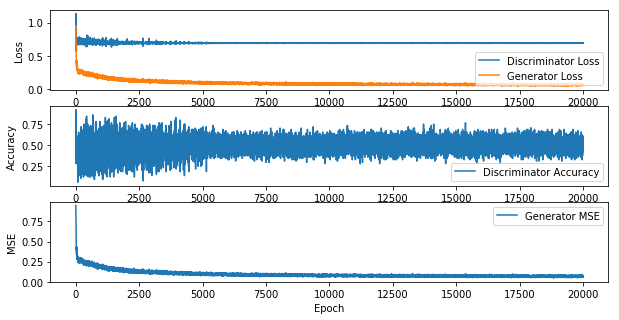

In [26]:
# plot training curves

plt.figure(figsize=(10,5))
plt.subplot(311)
plt.plot(d_loss_list, label = 'Discriminator Loss')
plt.plot(g_loss_list, label = 'Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(312)
plt.plot(d_acc_list, label = 'Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(313)
plt.plot(g_mse_list, label = 'Generator MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

TODO: rerun without recompiling discriminator. Are the curves better?

In [27]:
# def save(model, model_name):
#     model_path = "saved_model/%s.json" % model_name
#     weights_path = "saved_model/%s_weights.h5" % model_name
#     options = {"file_arch": model_path,
#                "file_weight": weights_path}
#     json_string = model.to_json()
#     open(options['file_arch'], 'w').write(json_string)
#     model.save_weights(options['file_weight'])

In [28]:
# unique_name = petname.name()

# generator_model_filename = 'aae_generator_' + unique_name + '.h5'
# discriminator_model_filename = 'aae_discriminator_' + unique_name + '.h5'

# # TODO:
# # need to write a model for generator 
# # it is a encoder-decoder pair
# # and save it instead of adversarial_autoencoder
# save(adversarial_autoencoder, generator_model_filename)
# save(discriminator, discriminator_model_filename)